In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 558)
(3944610, 8)
validation
(464344, 558)
(464344, 8)
test
(574820, 558)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:50 - loss: 2.3338 - STD: 0.0991 - MAE: 0.2184

  4/395 [..............................] - ETA: 7s - loss: 2.1565 - STD: 0.0665 - MAE: 0.2164   

  7/395 [..............................] - ETA: 7s - loss: 2.1265 - STD: 0.0553 - MAE: 0.2167

 10/395 [..............................] - ETA: 7s - loss: 2.1158 - STD: 0.0514 - MAE: 0.2169

 13/395 [..............................] - ETA: 7s - loss: 2.1029 - STD: 0.0485 - MAE: 0.2168

 16/395 [>.............................] - ETA: 7s - loss: 2.0935 - STD: 0.0465 - MAE: 0.2167

 19/395 [>.............................] - ETA: 7s - loss: 2.0884 - STD: 0.0448 - MAE: 0.2167

 22/395 [>.............................] - ETA: 7s - loss: 2.0844 - STD: 0.0433 - MAE: 0.2167

 25/395 [>.............................] - ETA: 7s - loss: 2.0806 - STD: 0.0422 - MAE: 0.2167

 28/395 [=>............................] - ETA: 7s - loss: 2.0769 - STD: 0.0412 - MAE: 0.2167

 31/395 [=>............................] - ETA: 6s - loss: 2.0742 - STD: 0.0406 - MAE: 0.2167

 34/395 [=>............................] - ETA: 6s - loss: 2.0717 - STD: 0.0401 - MAE: 0.2166

 37/395 [=>............................] - ETA: 6s - loss: 2.0696 - STD: 0.0395 - MAE: 0.2166

 40/395 [==>...........................] - ETA: 6s - loss: 2.0673 - STD: 0.0389 - MAE: 0.2166

 43/395 [==>...........................] - ETA: 6s - loss: 2.0649 - STD: 0.0385 - MAE: 0.2165

 46/395 [==>...........................] - ETA: 6s - loss: 2.0622 - STD: 0.0381 - MAE: 0.2165

 49/395 [==>...........................] - ETA: 6s - loss: 2.0587 - STD: 0.0380 - MAE: 0.2164

 52/395 [==>...........................] - ETA: 6s - loss: 2.0545 - STD: 0.0380 - MAE: 0.2162

 55/395 [===>..........................] - ETA: 6s - loss: 2.0494 - STD: 0.0383 - MAE: 0.2160

 58/395 [===>..........................] - ETA: 6s - loss: 2.0436 - STD: 0.0392 - MAE: 0.2158

 61/395 [===>..........................] - ETA: 6s - loss: 2.0373 - STD: 0.0404 - MAE: 0.2154

 64/395 [===>..........................] - ETA: 6s - loss: 2.0305 - STD: 0.0415 - MAE: 0.2151

 67/395 [====>.........................] - ETA: 6s - loss: 2.0234 - STD: 0.0428 - MAE: 0.2147

 70/395 [====>.........................] - ETA: 6s - loss: 2.0160 - STD: 0.0442 - MAE: 0.2143

 73/395 [====>.........................] - ETA: 6s - loss: 2.0083 - STD: 0.0454 - MAE: 0.2139

 76/395 [====>.........................] - ETA: 6s - loss: 2.0002 - STD: 0.0468 - MAE: 0.2135

 79/395 [=====>........................] - ETA: 6s - loss: 1.9913 - STD: 0.0483 - MAE: 0.2130

 82/395 [=====>........................] - ETA: 5s - loss: 1.9822 - STD: 0.0498 - MAE: 0.2126

 85/395 [=====>........................] - ETA: 5s - loss: 1.9728 - STD: 0.0513 - MAE: 0.2121

 88/395 [=====>........................] - ETA: 5s - loss: 1.9629 - STD: 0.0528 - MAE: 0.2115

 91/395 [=====>........................] - ETA: 5s - loss: 1.9526 - STD: 0.0544 - MAE: 0.2110

 94/395 [======>.......................] - ETA: 5s - loss: 1.9417 - STD: 0.0560 - MAE: 0.2104

 97/395 [======>.......................] - ETA: 5s - loss: 1.9305 - STD: 0.0578 - MAE: 0.2097

100/395 [======>.......................] - ETA: 5s - loss: 1.9193 - STD: 0.0595 - MAE: 0.2091

103/395 [======>.......................] - ETA: 5s - loss: 1.9083 - STD: 0.0613 - MAE: 0.2084

106/395 [=======>......................] - ETA: 5s - loss: 1.8972 - STD: 0.0631 - MAE: 0.2077

109/395 [=======>......................] - ETA: 5s - loss: 1.8865 - STD: 0.0649 - MAE: 0.2070

112/395 [=======>......................] - ETA: 5s - loss: 1.8761 - STD: 0.0667 - MAE: 0.2064

115/395 [=======>......................] - ETA: 5s - loss: 1.8661 - STD: 0.0683 - MAE: 0.2057

118/395 [=======>......................] - ETA: 5s - loss: 1.8565 - STD: 0.0700 - MAE: 0.2051

121/395 [========>.....................] - ETA: 5s - loss: 1.8471 - STD: 0.0716 - MAE: 0.2045

124/395 [========>.....................] - ETA: 5s - loss: 1.8381 - STD: 0.0731 - MAE: 0.2039

127/395 [========>.....................] - ETA: 5s - loss: 1.8291 - STD: 0.0746 - MAE: 0.2033

130/395 [========>.....................] - ETA: 5s - loss: 1.8207 - STD: 0.0760 - MAE: 0.2027

133/395 [=========>....................] - ETA: 4s - loss: 1.8127 - STD: 0.0774 - MAE: 0.2022

136/395 [=========>....................] - ETA: 4s - loss: 1.8046 - STD: 0.0787 - MAE: 0.2017

139/395 [=========>....................] - ETA: 4s - loss: 1.7967 - STD: 0.0800 - MAE: 0.2011

142/395 [=========>....................] - ETA: 4s - loss: 1.7893 - STD: 0.0813 - MAE: 0.2006

145/395 [==========>...................] - ETA: 4s - loss: 1.7821 - STD: 0.0825 - MAE: 0.2002

148/395 [==========>...................] - ETA: 4s - loss: 1.7748 - STD: 0.0837 - MAE: 0.1997

151/395 [==========>...................] - ETA: 4s - loss: 1.7677 - STD: 0.0849 - MAE: 0.1992

154/395 [==========>...................] - ETA: 4s - loss: 1.7610 - STD: 0.0860 - MAE: 0.1987

157/395 [==========>...................] - ETA: 4s - loss: 1.7544 - STD: 0.0871 - MAE: 0.1982

160/395 [===========>..................] - ETA: 4s - loss: 1.7479 - STD: 0.0882 - MAE: 0.1978

163/395 [===========>..................] - ETA: 4s - loss: 1.7416 - STD: 0.0893 - MAE: 0.1973

166/395 [===========>..................] - ETA: 4s - loss: 1.7353 - STD: 0.0903 - MAE: 0.1969

169/395 [===========>..................] - ETA: 4s - loss: 1.7292 - STD: 0.0913 - MAE: 0.1965

172/395 [============>.................] - ETA: 4s - loss: 1.7232 - STD: 0.0923 - MAE: 0.1960

175/395 [============>.................] - ETA: 4s - loss: 1.7175 - STD: 0.0933 - MAE: 0.1956

178/395 [============>.................] - ETA: 4s - loss: 1.7117 - STD: 0.0942 - MAE: 0.1952

181/395 [============>.................] - ETA: 4s - loss: 1.7062 - STD: 0.0952 - MAE: 0.1948

184/395 [============>.................] - ETA: 4s - loss: 1.7008 - STD: 0.0961 - MAE: 0.1944

187/395 [=============>................] - ETA: 3s - loss: 1.6955 - STD: 0.0970 - MAE: 0.1940

190/395 [=============>................] - ETA: 3s - loss: 1.6902 - STD: 0.0978 - MAE: 0.1936

193/395 [=============>................] - ETA: 3s - loss: 1.6850 - STD: 0.0987 - MAE: 0.1933

196/395 [=============>................] - ETA: 3s - loss: 1.6799 - STD: 0.0995 - MAE: 0.1929

199/395 [==============>...............] - ETA: 3s - loss: 1.6749 - STD: 0.1004 - MAE: 0.1925

202/395 [==============>...............] - ETA: 3s - loss: 1.6700 - STD: 0.1012 - MAE: 0.1921

205/395 [==============>...............] - ETA: 3s - loss: 1.6651 - STD: 0.1020 - MAE: 0.1918

207/395 [==============>...............] - ETA: 4s - loss: 1.6629 - STD: 0.1025 - MAE: 0.1915

210/395 [==============>...............] - ETA: 4s - loss: 1.6581 - STD: 0.1033 - MAE: 0.1912

213/395 [===============>..............] - ETA: 4s - loss: 1.6535 - STD: 0.1041 - MAE: 0.1908

216/395 [===============>..............] - ETA: 4s - loss: 1.6489 - STD: 0.1049 - MAE: 0.1904

219/395 [===============>..............] - ETA: 4s - loss: 1.6444 - STD: 0.1056 - MAE: 0.1901

222/395 [===============>..............] - ETA: 3s - loss: 1.6402 - STD: 0.1064 - MAE: 0.1898

225/395 [================>.............] - ETA: 3s - loss: 1.6358 - STD: 0.1071 - MAE: 0.1894

228/395 [================>.............] - ETA: 3s - loss: 1.6317 - STD: 0.1078 - MAE: 0.1891

231/395 [================>.............] - ETA: 3s - loss: 1.6274 - STD: 0.1085 - MAE: 0.1887

234/395 [================>.............] - ETA: 3s - loss: 1.6233 - STD: 0.1092 - MAE: 0.1884

237/395 [=================>............] - ETA: 3s - loss: 1.6191 - STD: 0.1099 - MAE: 0.1881

240/395 [=================>............] - ETA: 3s - loss: 1.6152 - STD: 0.1106 - MAE: 0.1878

243/395 [=================>............] - ETA: 3s - loss: 1.6112 - STD: 0.1113 - MAE: 0.1874

246/395 [=================>............] - ETA: 3s - loss: 1.6074 - STD: 0.1119 - MAE: 0.1871

249/395 [=================>............] - ETA: 3s - loss: 1.6038 - STD: 0.1126 - MAE: 0.1868

252/395 [==================>...........] - ETA: 3s - loss: 1.6002 - STD: 0.1132 - MAE: 0.1865

255/395 [==================>...........] - ETA: 3s - loss: 1.5966 - STD: 0.1139 - MAE: 0.1862

258/395 [==================>...........] - ETA: 3s - loss: 1.5932 - STD: 0.1145 - MAE: 0.1860

261/395 [==================>...........] - ETA: 3s - loss: 1.5897 - STD: 0.1151 - MAE: 0.1857

264/395 [===================>..........] - ETA: 2s - loss: 1.5863 - STD: 0.1157 - MAE: 0.1854

267/395 [===================>..........] - ETA: 2s - loss: 1.5830 - STD: 0.1163 - MAE: 0.1851

270/395 [===================>..........] - ETA: 2s - loss: 1.5795 - STD: 0.1169 - MAE: 0.1848

273/395 [===================>..........] - ETA: 2s - loss: 1.5763 - STD: 0.1174 - MAE: 0.1845

276/395 [===================>..........] - ETA: 2s - loss: 1.5731 - STD: 0.1180 - MAE: 0.1843

279/395 [====================>.........] - ETA: 2s - loss: 1.5699 - STD: 0.1186 - MAE: 0.1840

282/395 [====================>.........] - ETA: 2s - loss: 1.5667 - STD: 0.1191 - MAE: 0.1837

285/395 [====================>.........] - ETA: 2s - loss: 1.5634 - STD: 0.1196 - MAE: 0.1835

288/395 [====================>.........] - ETA: 2s - loss: 1.5603 - STD: 0.1202 - MAE: 0.1832

291/395 [=====================>........] - ETA: 2s - loss: 1.5571 - STD: 0.1207 - MAE: 0.1829

294/395 [=====================>........] - ETA: 2s - loss: 1.5541 - STD: 0.1212 - MAE: 0.1827

297/395 [=====================>........] - ETA: 2s - loss: 1.5511 - STD: 0.1218 - MAE: 0.1824

300/395 [=====================>........] - ETA: 2s - loss: 1.5481 - STD: 0.1223 - MAE: 0.1822

303/395 [======================>.......] - ETA: 2s - loss: 1.5452 - STD: 0.1228 - MAE: 0.1819

306/395 [======================>.......] - ETA: 1s - loss: 1.5424 - STD: 0.1233 - MAE: 0.1817

309/395 [======================>.......] - ETA: 1s - loss: 1.5396 - STD: 0.1238 - MAE: 0.1814

312/395 [======================>.......] - ETA: 1s - loss: 1.5368 - STD: 0.1243 - MAE: 0.1812

315/395 [======================>.......] - ETA: 1s - loss: 1.5341 - STD: 0.1247 - MAE: 0.1810

318/395 [=======================>......] - ETA: 1s - loss: 1.5315 - STD: 0.1252 - MAE: 0.1807

321/395 [=======================>......] - ETA: 1s - loss: 1.5288 - STD: 0.1257 - MAE: 0.1805

324/395 [=======================>......] - ETA: 1s - loss: 1.5262 - STD: 0.1261 - MAE: 0.1803

327/395 [=======================>......] - ETA: 1s - loss: 1.5236 - STD: 0.1266 - MAE: 0.1801

330/395 [========================>.....] - ETA: 1s - loss: 1.5211 - STD: 0.1270 - MAE: 0.1798

333/395 [========================>.....] - ETA: 1s - loss: 1.5186 - STD: 0.1275 - MAE: 0.1796

336/395 [========================>.....] - ETA: 1s - loss: 1.5162 - STD: 0.1279 - MAE: 0.1794

339/395 [========================>.....] - ETA: 1s - loss: 1.5137 - STD: 0.1283 - MAE: 0.1792

342/395 [========================>.....] - ETA: 1s - loss: 1.5113 - STD: 0.1287 - MAE: 0.1790

345/395 [=========================>....] - ETA: 1s - loss: 1.5089 - STD: 0.1291 - MAE: 0.1788

348/395 [=========================>....] - ETA: 1s - loss: 1.5067 - STD: 0.1296 - MAE: 0.1786

351/395 [=========================>....] - ETA: 0s - loss: 1.5044 - STD: 0.1299 - MAE: 0.1784

354/395 [=========================>....] - ETA: 0s - loss: 1.5021 - STD: 0.1303 - MAE: 0.1782

357/395 [==========================>...] - ETA: 0s - loss: 1.4997 - STD: 0.1307 - MAE: 0.1780

360/395 [==========================>...] - ETA: 0s - loss: 1.4974 - STD: 0.1312 - MAE: 0.1778

363/395 [==========================>...] - ETA: 0s - loss: 1.4952 - STD: 0.1315 - MAE: 0.1776

366/395 [==========================>...] - ETA: 0s - loss: 1.4930 - STD: 0.1319 - MAE: 0.1774

369/395 [===========================>..] - ETA: 0s - loss: 1.4908 - STD: 0.1323 - MAE: 0.1772

372/395 [===========================>..] - ETA: 0s - loss: 1.4888 - STD: 0.1327 - MAE: 0.1770

375/395 [===========================>..] - ETA: 0s - loss: 1.4867 - STD: 0.1330 - MAE: 0.1768

378/395 [===========================>..] - ETA: 0s - loss: 1.4847 - STD: 0.1334 - MAE: 0.1767

381/395 [===========================>..] - ETA: 0s - loss: 1.4826 - STD: 0.1338 - MAE: 0.1765

384/395 [============================>.] - ETA: 0s - loss: 1.4805 - STD: 0.1341 - MAE: 0.1763

387/395 [============================>.] - ETA: 0s - loss: 1.4785 - STD: 0.1344 - MAE: 0.1761

390/395 [============================>.] - ETA: 0s - loss: 1.4764 - STD: 0.1348 - MAE: 0.1759

393/395 [============================>.] - ETA: 0s - loss: 1.4744 - STD: 0.1351 - MAE: 0.1758

395/395 [==============================] - 11s 24ms/step - loss: 1.4730 - STD: 0.1354 - MAE: 0.1756 - val_loss: 1.2230 - val_STD: 0.1793 - val_MAE: 0.1518


Epoch 2/10000


  1/395 [..............................] - ETA: 16s - loss: 1.1953 - STD: 0.1809 - MAE: 0.1515

  4/395 [..............................] - ETA: 7s - loss: 1.2119 - STD: 0.1807 - MAE: 0.1525 

  7/395 [..............................] - ETA: 7s - loss: 1.2232 - STD: 0.1811 - MAE: 0.1528

 10/395 [..............................] - ETA: 7s - loss: 1.2198 - STD: 0.1806 - MAE: 0.1528

 13/395 [..............................] - ETA: 7s - loss: 1.2183 - STD: 0.1806 - MAE: 0.1527

 16/395 [>.............................] - ETA: 7s - loss: 1.2178 - STD: 0.1807 - MAE: 0.1527

 19/395 [>.............................] - ETA: 6s - loss: 1.2168 - STD: 0.1807 - MAE: 0.1526

 22/395 [>.............................] - ETA: 6s - loss: 1.2185 - STD: 0.1808 - MAE: 0.1527

 25/395 [>.............................] - ETA: 6s - loss: 1.2186 - STD: 0.1808 - MAE: 0.1526

 28/395 [=>............................] - ETA: 6s - loss: 1.2195 - STD: 0.1808 - MAE: 0.1527

 31/395 [=>............................] - ETA: 6s - loss: 1.2208 - STD: 0.1808 - MAE: 0.1527

 34/395 [=>............................] - ETA: 6s - loss: 1.2214 - STD: 0.1807 - MAE: 0.1528

 37/395 [=>............................] - ETA: 6s - loss: 1.2204 - STD: 0.1808 - MAE: 0.1527

 40/395 [==>...........................] - ETA: 6s - loss: 1.2189 - STD: 0.1809 - MAE: 0.1526

 43/395 [==>...........................] - ETA: 6s - loss: 1.2174 - STD: 0.1809 - MAE: 0.1525

 46/395 [==>...........................] - ETA: 6s - loss: 1.2160 - STD: 0.1810 - MAE: 0.1524

 49/395 [==>...........................] - ETA: 6s - loss: 1.2149 - STD: 0.1810 - MAE: 0.1523

 52/395 [==>...........................] - ETA: 6s - loss: 1.2138 - STD: 0.1811 - MAE: 0.1523

 55/395 [===>..........................] - ETA: 6s - loss: 1.2133 - STD: 0.1811 - MAE: 0.1522

 58/395 [===>..........................] - ETA: 6s - loss: 1.2124 - STD: 0.1812 - MAE: 0.1521

 61/395 [===>..........................] - ETA: 6s - loss: 1.2117 - STD: 0.1813 - MAE: 0.1521

 64/395 [===>..........................] - ETA: 6s - loss: 1.2109 - STD: 0.1814 - MAE: 0.1520

 67/395 [====>.........................] - ETA: 6s - loss: 1.2102 - STD: 0.1814 - MAE: 0.1520

 70/395 [====>.........................] - ETA: 6s - loss: 1.2091 - STD: 0.1815 - MAE: 0.1519

 73/395 [====>.........................] - ETA: 6s - loss: 1.2083 - STD: 0.1816 - MAE: 0.1518

 76/395 [====>.........................] - ETA: 5s - loss: 1.2077 - STD: 0.1816 - MAE: 0.1518

 79/395 [=====>........................] - ETA: 5s - loss: 1.2067 - STD: 0.1817 - MAE: 0.1517

 82/395 [=====>........................] - ETA: 5s - loss: 1.2065 - STD: 0.1818 - MAE: 0.1517

 85/395 [=====>........................] - ETA: 5s - loss: 1.2060 - STD: 0.1818 - MAE: 0.1516

 88/395 [=====>........................] - ETA: 5s - loss: 1.2051 - STD: 0.1819 - MAE: 0.1515

 91/395 [=====>........................] - ETA: 5s - loss: 1.2046 - STD: 0.1820 - MAE: 0.1515

 94/395 [======>.......................] - ETA: 5s - loss: 1.2042 - STD: 0.1821 - MAE: 0.1514

 97/395 [======>.......................] - ETA: 5s - loss: 1.2040 - STD: 0.1821 - MAE: 0.1514

100/395 [======>.......................] - ETA: 5s - loss: 1.2033 - STD: 0.1822 - MAE: 0.1513

103/395 [======>.......................] - ETA: 5s - loss: 1.2027 - STD: 0.1823 - MAE: 0.1513

106/395 [=======>......................] - ETA: 5s - loss: 1.2022 - STD: 0.1823 - MAE: 0.1512

109/395 [=======>......................] - ETA: 5s - loss: 1.2019 - STD: 0.1824 - MAE: 0.1512

112/395 [=======>......................] - ETA: 5s - loss: 1.2012 - STD: 0.1825 - MAE: 0.1511

115/395 [=======>......................] - ETA: 5s - loss: 1.2005 - STD: 0.1826 - MAE: 0.1510

118/395 [=======>......................] - ETA: 5s - loss: 1.1998 - STD: 0.1827 - MAE: 0.1510

121/395 [========>.....................] - ETA: 5s - loss: 1.1991 - STD: 0.1828 - MAE: 0.1509

124/395 [========>.....................] - ETA: 5s - loss: 1.1986 - STD: 0.1828 - MAE: 0.1509

127/395 [========>.....................] - ETA: 5s - loss: 1.1979 - STD: 0.1829 - MAE: 0.1508

130/395 [========>.....................] - ETA: 4s - loss: 1.1974 - STD: 0.1829 - MAE: 0.1508

133/395 [=========>....................] - ETA: 4s - loss: 1.1968 - STD: 0.1830 - MAE: 0.1507

136/395 [=========>....................] - ETA: 4s - loss: 1.1964 - STD: 0.1831 - MAE: 0.1507

139/395 [=========>....................] - ETA: 4s - loss: 1.1958 - STD: 0.1831 - MAE: 0.1506

142/395 [=========>....................] - ETA: 4s - loss: 1.1951 - STD: 0.1832 - MAE: 0.1506

145/395 [==========>...................] - ETA: 4s - loss: 1.1946 - STD: 0.1833 - MAE: 0.1505

148/395 [==========>...................] - ETA: 4s - loss: 1.1942 - STD: 0.1833 - MAE: 0.1505

151/395 [==========>...................] - ETA: 4s - loss: 1.1935 - STD: 0.1834 - MAE: 0.1504

154/395 [==========>...................] - ETA: 4s - loss: 1.1930 - STD: 0.1835 - MAE: 0.1503

157/395 [==========>...................] - ETA: 4s - loss: 1.1924 - STD: 0.1836 - MAE: 0.1503

160/395 [===========>..................] - ETA: 4s - loss: 1.1919 - STD: 0.1837 - MAE: 0.1502

163/395 [===========>..................] - ETA: 4s - loss: 1.1915 - STD: 0.1838 - MAE: 0.1502

166/395 [===========>..................] - ETA: 4s - loss: 1.1908 - STD: 0.1838 - MAE: 0.1501

169/395 [===========>..................] - ETA: 4s - loss: 1.1901 - STD: 0.1839 - MAE: 0.1501

172/395 [============>.................] - ETA: 4s - loss: 1.1896 - STD: 0.1840 - MAE: 0.1500

175/395 [============>.................] - ETA: 4s - loss: 1.1892 - STD: 0.1840 - MAE: 0.1500

178/395 [============>.................] - ETA: 4s - loss: 1.1888 - STD: 0.1841 - MAE: 0.1499

181/395 [============>.................] - ETA: 4s - loss: 1.1884 - STD: 0.1841 - MAE: 0.1499

184/395 [============>.................] - ETA: 4s - loss: 1.1881 - STD: 0.1842 - MAE: 0.1499

187/395 [=============>................] - ETA: 3s - loss: 1.1877 - STD: 0.1842 - MAE: 0.1498

190/395 [=============>................] - ETA: 3s - loss: 1.1872 - STD: 0.1843 - MAE: 0.1498

193/395 [=============>................] - ETA: 3s - loss: 1.1867 - STD: 0.1844 - MAE: 0.1497

196/395 [=============>................] - ETA: 3s - loss: 1.1863 - STD: 0.1844 - MAE: 0.1497

199/395 [==============>...............] - ETA: 3s - loss: 1.1859 - STD: 0.1845 - MAE: 0.1496

202/395 [==============>...............] - ETA: 3s - loss: 1.1854 - STD: 0.1846 - MAE: 0.1496

205/395 [==============>...............] - ETA: 3s - loss: 1.1850 - STD: 0.1846 - MAE: 0.1496

208/395 [==============>...............] - ETA: 3s - loss: 1.1844 - STD: 0.1847 - MAE: 0.1495

211/395 [===============>..............] - ETA: 3s - loss: 1.1839 - STD: 0.1847 - MAE: 0.1495

214/395 [===============>..............] - ETA: 3s - loss: 1.1834 - STD: 0.1848 - MAE: 0.1494

217/395 [===============>..............] - ETA: 3s - loss: 1.1830 - STD: 0.1848 - MAE: 0.1494

220/395 [===============>..............] - ETA: 3s - loss: 1.1828 - STD: 0.1849 - MAE: 0.1493

223/395 [===============>..............] - ETA: 3s - loss: 1.1824 - STD: 0.1850 - MAE: 0.1493

226/395 [================>.............] - ETA: 3s - loss: 1.1819 - STD: 0.1850 - MAE: 0.1492

229/395 [================>.............] - ETA: 3s - loss: 1.1814 - STD: 0.1851 - MAE: 0.1492

232/395 [================>.............] - ETA: 3s - loss: 1.1811 - STD: 0.1852 - MAE: 0.1492

235/395 [================>.............] - ETA: 3s - loss: 1.1807 - STD: 0.1852 - MAE: 0.1491

238/395 [=================>............] - ETA: 3s - loss: 1.1808 - STD: 0.1853 - MAE: 0.1491

241/395 [=================>............] - ETA: 2s - loss: 1.1804 - STD: 0.1853 - MAE: 0.1491

244/395 [=================>............] - ETA: 2s - loss: 1.1800 - STD: 0.1854 - MAE: 0.1490

247/395 [=================>............] - ETA: 2s - loss: 1.1796 - STD: 0.1854 - MAE: 0.1490

250/395 [=================>............] - ETA: 2s - loss: 1.1793 - STD: 0.1855 - MAE: 0.1490

253/395 [==================>...........] - ETA: 2s - loss: 1.1790 - STD: 0.1855 - MAE: 0.1489

256/395 [==================>...........] - ETA: 2s - loss: 1.1786 - STD: 0.1856 - MAE: 0.1489

259/395 [==================>...........] - ETA: 2s - loss: 1.1782 - STD: 0.1856 - MAE: 0.1488

262/395 [==================>...........] - ETA: 2s - loss: 1.1778 - STD: 0.1857 - MAE: 0.1488

265/395 [===================>..........] - ETA: 2s - loss: 1.1774 - STD: 0.1857 - MAE: 0.1488

268/395 [===================>..........] - ETA: 2s - loss: 1.1769 - STD: 0.1858 - MAE: 0.1487

271/395 [===================>..........] - ETA: 2s - loss: 1.1765 - STD: 0.1858 - MAE: 0.1487

274/395 [===================>..........] - ETA: 2s - loss: 1.1761 - STD: 0.1859 - MAE: 0.1487

277/395 [====================>.........] - ETA: 2s - loss: 1.1755 - STD: 0.1859 - MAE: 0.1486

280/395 [====================>.........] - ETA: 2s - loss: 1.1750 - STD: 0.1860 - MAE: 0.1486

283/395 [====================>.........] - ETA: 2s - loss: 1.1746 - STD: 0.1860 - MAE: 0.1485

286/395 [====================>.........] - ETA: 2s - loss: 1.1742 - STD: 0.1861 - MAE: 0.1485

289/395 [====================>.........] - ETA: 2s - loss: 1.1737 - STD: 0.1861 - MAE: 0.1484

292/395 [=====================>........] - ETA: 1s - loss: 1.1733 - STD: 0.1862 - MAE: 0.1484

295/395 [=====================>........] - ETA: 1s - loss: 1.1729 - STD: 0.1862 - MAE: 0.1484

298/395 [=====================>........] - ETA: 1s - loss: 1.1725 - STD: 0.1863 - MAE: 0.1483

301/395 [=====================>........] - ETA: 1s - loss: 1.1720 - STD: 0.1863 - MAE: 0.1483

304/395 [======================>.......] - ETA: 1s - loss: 1.1715 - STD: 0.1864 - MAE: 0.1482

307/395 [======================>.......] - ETA: 1s - loss: 1.1710 - STD: 0.1865 - MAE: 0.1482

310/395 [======================>.......] - ETA: 1s - loss: 1.1707 - STD: 0.1865 - MAE: 0.1482

313/395 [======================>.......] - ETA: 1s - loss: 1.1702 - STD: 0.1866 - MAE: 0.1481

316/395 [=======================>......] - ETA: 1s - loss: 1.1699 - STD: 0.1866 - MAE: 0.1481

319/395 [=======================>......] - ETA: 1s - loss: 1.1695 - STD: 0.1867 - MAE: 0.1480

322/395 [=======================>......] - ETA: 1s - loss: 1.1690 - STD: 0.1867 - MAE: 0.1480

325/395 [=======================>......] - ETA: 1s - loss: 1.1686 - STD: 0.1868 - MAE: 0.1480

328/395 [=======================>......] - ETA: 1s - loss: 1.1682 - STD: 0.1868 - MAE: 0.1479

331/395 [========================>.....] - ETA: 1s - loss: 1.1677 - STD: 0.1869 - MAE: 0.1479

334/395 [========================>.....] - ETA: 1s - loss: 1.1672 - STD: 0.1869 - MAE: 0.1478

337/395 [========================>.....] - ETA: 1s - loss: 1.1668 - STD: 0.1870 - MAE: 0.1478

340/395 [========================>.....] - ETA: 1s - loss: 1.1664 - STD: 0.1870 - MAE: 0.1478

343/395 [=========================>....] - ETA: 1s - loss: 1.1660 - STD: 0.1871 - MAE: 0.1477

346/395 [=========================>....] - ETA: 0s - loss: 1.1657 - STD: 0.1871 - MAE: 0.1477

349/395 [=========================>....] - ETA: 0s - loss: 1.1652 - STD: 0.1872 - MAE: 0.1476

352/395 [=========================>....] - ETA: 0s - loss: 1.1648 - STD: 0.1872 - MAE: 0.1476

355/395 [=========================>....] - ETA: 0s - loss: 1.1644 - STD: 0.1873 - MAE: 0.1476

358/395 [==========================>...] - ETA: 0s - loss: 1.1641 - STD: 0.1873 - MAE: 0.1475

361/395 [==========================>...] - ETA: 0s - loss: 1.1638 - STD: 0.1874 - MAE: 0.1475

364/395 [==========================>...] - ETA: 0s - loss: 1.1639 - STD: 0.1874 - MAE: 0.1475

367/395 [==========================>...] - ETA: 0s - loss: 1.1638 - STD: 0.1875 - MAE: 0.1475

370/395 [===========================>..] - ETA: 0s - loss: 1.1636 - STD: 0.1875 - MAE: 0.1474

373/395 [===========================>..] - ETA: 0s - loss: 1.1637 - STD: 0.1876 - MAE: 0.1474

376/395 [===========================>..] - ETA: 0s - loss: 1.1637 - STD: 0.1876 - MAE: 0.1474

379/395 [===========================>..] - ETA: 0s - loss: 1.1634 - STD: 0.1876 - MAE: 0.1474

382/395 [============================>.] - ETA: 0s - loss: 1.1631 - STD: 0.1877 - MAE: 0.1473

385/395 [============================>.] - ETA: 0s - loss: 1.1628 - STD: 0.1877 - MAE: 0.1473

388/395 [============================>.] - ETA: 0s - loss: 1.1624 - STD: 0.1878 - MAE: 0.1473

391/395 [============================>.] - ETA: 0s - loss: 1.1621 - STD: 0.1878 - MAE: 0.1473

394/395 [============================>.] - ETA: 0s - loss: 1.1617 - STD: 0.1878 - MAE: 0.1472

395/395 [==============================] - 8s 21ms/step - loss: 1.1615 - STD: 0.1878 - MAE: 0.1472 - val_loss: 1.1727 - val_STD: 0.1944 - val_MAE: 0.1438


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1024 - STD: 0.1931 - MAE: 0.1424

  4/395 [..............................] - ETA: 8s - loss: 1.1073 - STD: 0.1935 - MAE: 0.1424 

  7/395 [..............................] - ETA: 8s - loss: 1.1071 - STD: 0.1931 - MAE: 0.1425

 10/395 [..............................] - ETA: 8s - loss: 1.1084 - STD: 0.1931 - MAE: 0.1426

 13/395 [..............................] - ETA: 8s - loss: 1.1075 - STD: 0.1930 - MAE: 0.1427

 16/395 [>.............................] - ETA: 7s - loss: 1.1044 - STD: 0.1930 - MAE: 0.1425

 19/395 [>.............................] - ETA: 7s - loss: 1.1034 - STD: 0.1932 - MAE: 0.1423

 22/395 [>.............................] - ETA: 7s - loss: 1.1036 - STD: 0.1933 - MAE: 0.1422

 25/395 [>.............................] - ETA: 7s - loss: 1.1026 - STD: 0.1935 - MAE: 0.1421

 28/395 [=>............................] - ETA: 7s - loss: 1.1016 - STD: 0.1937 - MAE: 0.1420

 31/395 [=>............................] - ETA: 7s - loss: 1.1015 - STD: 0.1939 - MAE: 0.1419

 34/395 [=>............................] - ETA: 7s - loss: 1.1010 - STD: 0.1940 - MAE: 0.1418

 37/395 [=>............................] - ETA: 7s - loss: 1.0998 - STD: 0.1942 - MAE: 0.1417

 40/395 [==>...........................] - ETA: 6s - loss: 1.0997 - STD: 0.1943 - MAE: 0.1417

 43/395 [==>...........................] - ETA: 6s - loss: 1.0993 - STD: 0.1944 - MAE: 0.1416

 46/395 [==>...........................] - ETA: 6s - loss: 1.0992 - STD: 0.1945 - MAE: 0.1416

 49/395 [==>...........................] - ETA: 6s - loss: 1.0995 - STD: 0.1946 - MAE: 0.1415

 52/395 [==>...........................] - ETA: 6s - loss: 1.0990 - STD: 0.1946 - MAE: 0.1415

 55/395 [===>..........................] - ETA: 6s - loss: 1.0990 - STD: 0.1947 - MAE: 0.1415

 58/395 [===>..........................] - ETA: 6s - loss: 1.0988 - STD: 0.1948 - MAE: 0.1414

 61/395 [===>..........................] - ETA: 6s - loss: 1.0989 - STD: 0.1949 - MAE: 0.1414

 64/395 [===>..........................] - ETA: 6s - loss: 1.0992 - STD: 0.1949 - MAE: 0.1414

 67/395 [====>.........................] - ETA: 6s - loss: 1.0993 - STD: 0.1950 - MAE: 0.1414

 70/395 [====>.........................] - ETA: 6s - loss: 1.1002 - STD: 0.1950 - MAE: 0.1414

 73/395 [====>.........................] - ETA: 6s - loss: 1.0999 - STD: 0.1950 - MAE: 0.1414

 76/395 [====>.........................] - ETA: 6s - loss: 1.1002 - STD: 0.1950 - MAE: 0.1414

 79/395 [=====>........................] - ETA: 6s - loss: 1.1003 - STD: 0.1950 - MAE: 0.1414

 82/395 [=====>........................] - ETA: 6s - loss: 1.1001 - STD: 0.1951 - MAE: 0.1414

 85/395 [=====>........................] - ETA: 6s - loss: 1.0999 - STD: 0.1951 - MAE: 0.1413

 88/395 [=====>........................] - ETA: 6s - loss: 1.0998 - STD: 0.1951 - MAE: 0.1413

 91/395 [=====>........................] - ETA: 5s - loss: 1.0997 - STD: 0.1952 - MAE: 0.1413

 94/395 [======>.......................] - ETA: 5s - loss: 1.0991 - STD: 0.1952 - MAE: 0.1413

 97/395 [======>.......................] - ETA: 5s - loss: 1.0985 - STD: 0.1952 - MAE: 0.1412

100/395 [======>.......................] - ETA: 5s - loss: 1.0980 - STD: 0.1953 - MAE: 0.1412

103/395 [======>.......................] - ETA: 5s - loss: 1.0975 - STD: 0.1953 - MAE: 0.1411

106/395 [=======>......................] - ETA: 5s - loss: 1.0972 - STD: 0.1953 - MAE: 0.1411

109/395 [=======>......................] - ETA: 5s - loss: 1.0968 - STD: 0.1954 - MAE: 0.1411

112/395 [=======>......................] - ETA: 5s - loss: 1.0964 - STD: 0.1955 - MAE: 0.1410

115/395 [=======>......................] - ETA: 5s - loss: 1.0959 - STD: 0.1955 - MAE: 0.1410

118/395 [=======>......................] - ETA: 5s - loss: 1.0956 - STD: 0.1955 - MAE: 0.1410

121/395 [========>.....................] - ETA: 5s - loss: 1.0951 - STD: 0.1956 - MAE: 0.1409

124/395 [========>.....................] - ETA: 5s - loss: 1.0948 - STD: 0.1956 - MAE: 0.1409

127/395 [========>.....................] - ETA: 5s - loss: 1.0943 - STD: 0.1956 - MAE: 0.1409

130/395 [========>.....................] - ETA: 5s - loss: 1.0938 - STD: 0.1957 - MAE: 0.1408

133/395 [=========>....................] - ETA: 5s - loss: 1.0934 - STD: 0.1957 - MAE: 0.1408

136/395 [=========>....................] - ETA: 5s - loss: 1.0935 - STD: 0.1958 - MAE: 0.1408

139/395 [=========>....................] - ETA: 5s - loss: 1.0933 - STD: 0.1958 - MAE: 0.1407

142/395 [=========>....................] - ETA: 5s - loss: 1.0928 - STD: 0.1959 - MAE: 0.1407

145/395 [==========>...................] - ETA: 4s - loss: 1.0925 - STD: 0.1959 - MAE: 0.1406

148/395 [==========>...................] - ETA: 4s - loss: 1.0922 - STD: 0.1960 - MAE: 0.1406

151/395 [==========>...................] - ETA: 4s - loss: 1.0920 - STD: 0.1960 - MAE: 0.1406

154/395 [==========>...................] - ETA: 4s - loss: 1.0915 - STD: 0.1961 - MAE: 0.1405

157/395 [==========>...................] - ETA: 4s - loss: 1.0914 - STD: 0.1961 - MAE: 0.1405

160/395 [===========>..................] - ETA: 4s - loss: 1.0910 - STD: 0.1961 - MAE: 0.1405

163/395 [===========>..................] - ETA: 4s - loss: 1.0907 - STD: 0.1962 - MAE: 0.1405

166/395 [===========>..................] - ETA: 4s - loss: 1.0904 - STD: 0.1962 - MAE: 0.1404

169/395 [===========>..................] - ETA: 4s - loss: 1.0902 - STD: 0.1963 - MAE: 0.1404

172/395 [============>.................] - ETA: 4s - loss: 1.0898 - STD: 0.1963 - MAE: 0.1404

175/395 [============>.................] - ETA: 4s - loss: 1.0894 - STD: 0.1963 - MAE: 0.1404

178/395 [============>.................] - ETA: 4s - loss: 1.0891 - STD: 0.1964 - MAE: 0.1403

181/395 [============>.................] - ETA: 4s - loss: 1.0891 - STD: 0.1964 - MAE: 0.1403

184/395 [============>.................] - ETA: 4s - loss: 1.0889 - STD: 0.1965 - MAE: 0.1403

187/395 [=============>................] - ETA: 4s - loss: 1.0889 - STD: 0.1965 - MAE: 0.1402

190/395 [=============>................] - ETA: 4s - loss: 1.0885 - STD: 0.1965 - MAE: 0.1402

193/395 [=============>................] - ETA: 3s - loss: 1.0883 - STD: 0.1966 - MAE: 0.1402

196/395 [=============>................] - ETA: 3s - loss: 1.0881 - STD: 0.1966 - MAE: 0.1402

199/395 [==============>...............] - ETA: 3s - loss: 1.0879 - STD: 0.1967 - MAE: 0.1401

202/395 [==============>...............] - ETA: 3s - loss: 1.0876 - STD: 0.1967 - MAE: 0.1401

205/395 [==============>...............] - ETA: 3s - loss: 1.0873 - STD: 0.1967 - MAE: 0.1401

208/395 [==============>...............] - ETA: 3s - loss: 1.0872 - STD: 0.1968 - MAE: 0.1401

211/395 [===============>..............] - ETA: 3s - loss: 1.0871 - STD: 0.1968 - MAE: 0.1400

214/395 [===============>..............] - ETA: 3s - loss: 1.0868 - STD: 0.1968 - MAE: 0.1400

217/395 [===============>..............] - ETA: 3s - loss: 1.0867 - STD: 0.1969 - MAE: 0.1400

220/395 [===============>..............] - ETA: 3s - loss: 1.0866 - STD: 0.1969 - MAE: 0.1400

223/395 [===============>..............] - ETA: 3s - loss: 1.0863 - STD: 0.1969 - MAE: 0.1400

226/395 [================>.............] - ETA: 3s - loss: 1.0861 - STD: 0.1970 - MAE: 0.1399

229/395 [================>.............] - ETA: 3s - loss: 1.0859 - STD: 0.1970 - MAE: 0.1399

232/395 [================>.............] - ETA: 3s - loss: 1.0857 - STD: 0.1970 - MAE: 0.1399

235/395 [================>.............] - ETA: 3s - loss: 1.0854 - STD: 0.1971 - MAE: 0.1399

238/395 [=================>............] - ETA: 3s - loss: 1.0851 - STD: 0.1971 - MAE: 0.1398

241/395 [=================>............] - ETA: 3s - loss: 1.0849 - STD: 0.1971 - MAE: 0.1398

244/395 [=================>............] - ETA: 2s - loss: 1.0847 - STD: 0.1972 - MAE: 0.1398

247/395 [=================>............] - ETA: 2s - loss: 1.0844 - STD: 0.1972 - MAE: 0.1398

250/395 [=================>............] - ETA: 2s - loss: 1.0841 - STD: 0.1972 - MAE: 0.1397

253/395 [==================>...........] - ETA: 2s - loss: 1.0838 - STD: 0.1973 - MAE: 0.1397

256/395 [==================>...........] - ETA: 2s - loss: 1.0835 - STD: 0.1973 - MAE: 0.1397

259/395 [==================>...........] - ETA: 2s - loss: 1.0831 - STD: 0.1973 - MAE: 0.1396

262/395 [==================>...........] - ETA: 2s - loss: 1.0829 - STD: 0.1974 - MAE: 0.1396

265/395 [===================>..........] - ETA: 2s - loss: 1.0826 - STD: 0.1974 - MAE: 0.1396

268/395 [===================>..........] - ETA: 2s - loss: 1.0824 - STD: 0.1974 - MAE: 0.1395

271/395 [===================>..........] - ETA: 2s - loss: 1.0821 - STD: 0.1975 - MAE: 0.1395

274/395 [===================>..........] - ETA: 2s - loss: 1.0819 - STD: 0.1975 - MAE: 0.1395

277/395 [====================>.........] - ETA: 2s - loss: 1.0815 - STD: 0.1976 - MAE: 0.1394

280/395 [====================>.........] - ETA: 2s - loss: 1.0813 - STD: 0.1976 - MAE: 0.1394

283/395 [====================>.........] - ETA: 2s - loss: 1.0814 - STD: 0.1976 - MAE: 0.1394

286/395 [====================>.........] - ETA: 2s - loss: 1.0811 - STD: 0.1977 - MAE: 0.1394

289/395 [====================>.........] - ETA: 2s - loss: 1.0808 - STD: 0.1977 - MAE: 0.1394

292/395 [=====================>........] - ETA: 2s - loss: 1.0804 - STD: 0.1977 - MAE: 0.1393

295/395 [=====================>........] - ETA: 1s - loss: 1.0800 - STD: 0.1978 - MAE: 0.1393

298/395 [=====================>........] - ETA: 1s - loss: 1.0798 - STD: 0.1978 - MAE: 0.1393

301/395 [=====================>........] - ETA: 1s - loss: 1.0794 - STD: 0.1978 - MAE: 0.1392

304/395 [======================>.......] - ETA: 1s - loss: 1.0790 - STD: 0.1979 - MAE: 0.1392

307/395 [======================>.......] - ETA: 1s - loss: 1.0786 - STD: 0.1979 - MAE: 0.1391

310/395 [======================>.......] - ETA: 1s - loss: 1.0783 - STD: 0.1980 - MAE: 0.1391

313/395 [======================>.......] - ETA: 1s - loss: 1.0779 - STD: 0.1980 - MAE: 0.1391

316/395 [=======================>......] - ETA: 1s - loss: 1.0775 - STD: 0.1980 - MAE: 0.1390

319/395 [=======================>......] - ETA: 1s - loss: 1.0772 - STD: 0.1981 - MAE: 0.1390

322/395 [=======================>......] - ETA: 1s - loss: 1.0770 - STD: 0.1981 - MAE: 0.1390

325/395 [=======================>......] - ETA: 1s - loss: 1.0766 - STD: 0.1982 - MAE: 0.1389

328/395 [=======================>......] - ETA: 1s - loss: 1.0764 - STD: 0.1982 - MAE: 0.1389

331/395 [========================>.....] - ETA: 1s - loss: 1.0763 - STD: 0.1982 - MAE: 0.1389

334/395 [========================>.....] - ETA: 1s - loss: 1.0760 - STD: 0.1983 - MAE: 0.1389

337/395 [========================>.....] - ETA: 1s - loss: 1.0758 - STD: 0.1983 - MAE: 0.1388

340/395 [========================>.....] - ETA: 1s - loss: 1.0754 - STD: 0.1983 - MAE: 0.1388

343/395 [=========================>....] - ETA: 1s - loss: 1.0752 - STD: 0.1984 - MAE: 0.1388

346/395 [=========================>....] - ETA: 0s - loss: 1.0750 - STD: 0.1984 - MAE: 0.1388

349/395 [=========================>....] - ETA: 0s - loss: 1.0747 - STD: 0.1985 - MAE: 0.1387

352/395 [=========================>....] - ETA: 0s - loss: 1.0744 - STD: 0.1985 - MAE: 0.1387

355/395 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.1985 - MAE: 0.1387

358/395 [==========================>...] - ETA: 0s - loss: 1.0738 - STD: 0.1986 - MAE: 0.1386

361/395 [==========================>...] - ETA: 0s - loss: 1.0734 - STD: 0.1986 - MAE: 0.1386

364/395 [==========================>...] - ETA: 0s - loss: 1.0731 - STD: 0.1986 - MAE: 0.1386

367/395 [==========================>...] - ETA: 0s - loss: 1.0728 - STD: 0.1987 - MAE: 0.1385

370/395 [===========================>..] - ETA: 0s - loss: 1.0726 - STD: 0.1987 - MAE: 0.1385

373/395 [===========================>..] - ETA: 0s - loss: 1.0722 - STD: 0.1987 - MAE: 0.1385

376/395 [===========================>..] - ETA: 0s - loss: 1.0720 - STD: 0.1988 - MAE: 0.1385

379/395 [===========================>..] - ETA: 0s - loss: 1.0717 - STD: 0.1988 - MAE: 0.1384

382/395 [============================>.] - ETA: 0s - loss: 1.0722 - STD: 0.1988 - MAE: 0.1384

385/395 [============================>.] - ETA: 0s - loss: 1.0721 - STD: 0.1989 - MAE: 0.1384

388/395 [============================>.] - ETA: 0s - loss: 1.0720 - STD: 0.1989 - MAE: 0.1384

391/395 [============================>.] - ETA: 0s - loss: 1.0719 - STD: 0.1989 - MAE: 0.1384

394/395 [============================>.] - ETA: 0s - loss: 1.0719 - STD: 0.1990 - MAE: 0.1384

395/395 [==============================] - 9s 22ms/step - loss: 1.0718 - STD: 0.1990 - MAE: 0.1384 - val_loss: 1.1580 - val_STD: 0.2055 - val_MAE: 0.1388


Epoch 4/10000


  1/395 [..............................] - ETA: 20s - loss: 1.0843 - STD: 0.2036 - MAE: 0.1370

  4/395 [..............................] - ETA: 7s - loss: 1.0580 - STD: 0.2029 - MAE: 0.1362 

  7/395 [..............................] - ETA: 7s - loss: 1.0499 - STD: 0.2023 - MAE: 0.1359

 10/395 [..............................] - ETA: 7s - loss: 1.0497 - STD: 0.2022 - MAE: 0.1358

 13/395 [..............................] - ETA: 7s - loss: 1.0457 - STD: 0.2023 - MAE: 0.1356

 16/395 [>.............................] - ETA: 7s - loss: 1.0443 - STD: 0.2023 - MAE: 0.1355

 19/395 [>.............................] - ETA: 7s - loss: 1.0421 - STD: 0.2023 - MAE: 0.1354

 22/395 [>.............................] - ETA: 7s - loss: 1.0432 - STD: 0.2023 - MAE: 0.1355

 25/395 [>.............................] - ETA: 7s - loss: 1.0425 - STD: 0.2024 - MAE: 0.1354

 28/395 [=>............................] - ETA: 7s - loss: 1.0416 - STD: 0.2024 - MAE: 0.1353

 31/395 [=>............................] - ETA: 7s - loss: 1.0405 - STD: 0.2026 - MAE: 0.1352

 34/395 [=>............................] - ETA: 7s - loss: 1.0397 - STD: 0.2026 - MAE: 0.1351

 37/395 [=>............................] - ETA: 7s - loss: 1.0387 - STD: 0.2028 - MAE: 0.1350

 40/395 [==>...........................] - ETA: 7s - loss: 1.0378 - STD: 0.2028 - MAE: 0.1350

 43/395 [==>...........................] - ETA: 7s - loss: 1.0369 - STD: 0.2029 - MAE: 0.1349

 46/395 [==>...........................] - ETA: 6s - loss: 1.0355 - STD: 0.2030 - MAE: 0.1347

 49/395 [==>...........................] - ETA: 6s - loss: 1.0347 - STD: 0.2031 - MAE: 0.1347

 52/395 [==>...........................] - ETA: 6s - loss: 1.0339 - STD: 0.2032 - MAE: 0.1346

 55/395 [===>..........................] - ETA: 6s - loss: 1.0332 - STD: 0.2034 - MAE: 0.1345

 58/395 [===>..........................] - ETA: 6s - loss: 1.0328 - STD: 0.2035 - MAE: 0.1344

 61/395 [===>..........................] - ETA: 6s - loss: 1.0326 - STD: 0.2036 - MAE: 0.1344

 64/395 [===>..........................] - ETA: 6s - loss: 1.0317 - STD: 0.2036 - MAE: 0.1343

 67/395 [====>.........................] - ETA: 6s - loss: 1.0310 - STD: 0.2037 - MAE: 0.1342

 70/395 [====>.........................] - ETA: 6s - loss: 1.0306 - STD: 0.2037 - MAE: 0.1342

 73/395 [====>.........................] - ETA: 6s - loss: 1.0309 - STD: 0.2039 - MAE: 0.1342

 76/395 [====>.........................] - ETA: 6s - loss: 1.0313 - STD: 0.2039 - MAE: 0.1342

 79/395 [=====>........................] - ETA: 6s - loss: 1.0311 - STD: 0.2040 - MAE: 0.1341

 82/395 [=====>........................] - ETA: 6s - loss: 1.0308 - STD: 0.2040 - MAE: 0.1341

 85/395 [=====>........................] - ETA: 6s - loss: 1.0306 - STD: 0.2041 - MAE: 0.1341

 88/395 [=====>........................] - ETA: 6s - loss: 1.0304 - STD: 0.2041 - MAE: 0.1341

 91/395 [=====>........................] - ETA: 6s - loss: 1.0301 - STD: 0.2041 - MAE: 0.1340

 94/395 [======>.......................] - ETA: 6s - loss: 1.0296 - STD: 0.2041 - MAE: 0.1340

 97/395 [======>.......................] - ETA: 5s - loss: 1.0295 - STD: 0.2042 - MAE: 0.1340

100/395 [======>.......................] - ETA: 5s - loss: 1.0293 - STD: 0.2042 - MAE: 0.1339

103/395 [======>.......................] - ETA: 5s - loss: 1.0292 - STD: 0.2043 - MAE: 0.1339

106/395 [=======>......................] - ETA: 5s - loss: 1.0291 - STD: 0.2043 - MAE: 0.1339

109/395 [=======>......................] - ETA: 5s - loss: 1.0286 - STD: 0.2043 - MAE: 0.1338

112/395 [=======>......................] - ETA: 5s - loss: 1.0279 - STD: 0.2044 - MAE: 0.1338

115/395 [=======>......................] - ETA: 5s - loss: 1.0275 - STD: 0.2044 - MAE: 0.1337

118/395 [=======>......................] - ETA: 5s - loss: 1.0270 - STD: 0.2045 - MAE: 0.1337

121/395 [========>.....................] - ETA: 5s - loss: 1.0266 - STD: 0.2045 - MAE: 0.1336

124/395 [========>.....................] - ETA: 5s - loss: 1.0261 - STD: 0.2046 - MAE: 0.1336

127/395 [========>.....................] - ETA: 5s - loss: 1.0258 - STD: 0.2046 - MAE: 0.1336

130/395 [========>.....................] - ETA: 5s - loss: 1.0254 - STD: 0.2047 - MAE: 0.1335

133/395 [=========>....................] - ETA: 5s - loss: 1.0253 - STD: 0.2047 - MAE: 0.1335

136/395 [=========>....................] - ETA: 5s - loss: 1.0250 - STD: 0.2047 - MAE: 0.1335

139/395 [=========>....................] - ETA: 5s - loss: 1.0247 - STD: 0.2048 - MAE: 0.1335

142/395 [=========>....................] - ETA: 5s - loss: 1.0243 - STD: 0.2048 - MAE: 0.1334

145/395 [==========>...................] - ETA: 4s - loss: 1.0238 - STD: 0.2048 - MAE: 0.1334

148/395 [==========>...................] - ETA: 4s - loss: 1.0237 - STD: 0.2049 - MAE: 0.1334

151/395 [==========>...................] - ETA: 4s - loss: 1.0237 - STD: 0.2049 - MAE: 0.1333

154/395 [==========>...................] - ETA: 4s - loss: 1.0237 - STD: 0.2050 - MAE: 0.1333

157/395 [==========>...................] - ETA: 4s - loss: 1.0240 - STD: 0.2050 - MAE: 0.1333

160/395 [===========>..................] - ETA: 4s - loss: 1.0241 - STD: 0.2050 - MAE: 0.1333

163/395 [===========>..................] - ETA: 4s - loss: 1.0242 - STD: 0.2051 - MAE: 0.1333

166/395 [===========>..................] - ETA: 4s - loss: 1.0245 - STD: 0.2051 - MAE: 0.1333

169/395 [===========>..................] - ETA: 4s - loss: 1.0245 - STD: 0.2051 - MAE: 0.1333

172/395 [============>.................] - ETA: 4s - loss: 1.0241 - STD: 0.2051 - MAE: 0.1333

175/395 [============>.................] - ETA: 4s - loss: 1.0237 - STD: 0.2052 - MAE: 0.1332

178/395 [============>.................] - ETA: 4s - loss: 1.0236 - STD: 0.2052 - MAE: 0.1332

181/395 [============>.................] - ETA: 4s - loss: 1.0234 - STD: 0.2052 - MAE: 0.1332

184/395 [============>.................] - ETA: 4s - loss: 1.0232 - STD: 0.2052 - MAE: 0.1332

187/395 [=============>................] - ETA: 4s - loss: 1.0229 - STD: 0.2052 - MAE: 0.1332

190/395 [=============>................] - ETA: 4s - loss: 1.0225 - STD: 0.2053 - MAE: 0.1331

193/395 [=============>................] - ETA: 4s - loss: 1.0223 - STD: 0.2053 - MAE: 0.1331

196/395 [=============>................] - ETA: 3s - loss: 1.0222 - STD: 0.2053 - MAE: 0.1331

199/395 [==============>...............] - ETA: 3s - loss: 1.0220 - STD: 0.2053 - MAE: 0.1331

202/395 [==============>...............] - ETA: 3s - loss: 1.0217 - STD: 0.2053 - MAE: 0.1331

205/395 [==============>...............] - ETA: 3s - loss: 1.0217 - STD: 0.2053 - MAE: 0.1331

208/395 [==============>...............] - ETA: 3s - loss: 1.0214 - STD: 0.2054 - MAE: 0.1330

211/395 [===============>..............] - ETA: 3s - loss: 1.0211 - STD: 0.2054 - MAE: 0.1330

214/395 [===============>..............] - ETA: 3s - loss: 1.0209 - STD: 0.2054 - MAE: 0.1330

217/395 [===============>..............] - ETA: 3s - loss: 1.0206 - STD: 0.2054 - MAE: 0.1330

220/395 [===============>..............] - ETA: 3s - loss: 1.0203 - STD: 0.2055 - MAE: 0.1329

223/395 [===============>..............] - ETA: 3s - loss: 1.0202 - STD: 0.2055 - MAE: 0.1329

226/395 [================>.............] - ETA: 3s - loss: 1.0200 - STD: 0.2056 - MAE: 0.1329

229/395 [================>.............] - ETA: 3s - loss: 1.0200 - STD: 0.2056 - MAE: 0.1329

232/395 [================>.............] - ETA: 3s - loss: 1.0200 - STD: 0.2056 - MAE: 0.1329

235/395 [================>.............] - ETA: 3s - loss: 1.0202 - STD: 0.2056 - MAE: 0.1328

238/395 [=================>............] - ETA: 3s - loss: 1.0201 - STD: 0.2057 - MAE: 0.1328

241/395 [=================>............] - ETA: 3s - loss: 1.0199 - STD: 0.2057 - MAE: 0.1328

244/395 [=================>............] - ETA: 2s - loss: 1.0198 - STD: 0.2057 - MAE: 0.1328

247/395 [=================>............] - ETA: 2s - loss: 1.0196 - STD: 0.2058 - MAE: 0.1328

250/395 [=================>............] - ETA: 2s - loss: 1.0193 - STD: 0.2058 - MAE: 0.1327

253/395 [==================>...........] - ETA: 2s - loss: 1.0191 - STD: 0.2058 - MAE: 0.1327

256/395 [==================>...........] - ETA: 2s - loss: 1.0189 - STD: 0.2058 - MAE: 0.1327

259/395 [==================>...........] - ETA: 2s - loss: 1.0187 - STD: 0.2059 - MAE: 0.1327

262/395 [==================>...........] - ETA: 2s - loss: 1.0186 - STD: 0.2059 - MAE: 0.1327

265/395 [===================>..........] - ETA: 2s - loss: 1.0184 - STD: 0.2059 - MAE: 0.1326

268/395 [===================>..........] - ETA: 2s - loss: 1.0183 - STD: 0.2059 - MAE: 0.1326

271/395 [===================>..........] - ETA: 2s - loss: 1.0181 - STD: 0.2059 - MAE: 0.1326

274/395 [===================>..........] - ETA: 2s - loss: 1.0180 - STD: 0.2060 - MAE: 0.1326

277/395 [====================>.........] - ETA: 2s - loss: 1.0177 - STD: 0.2060 - MAE: 0.1326

280/395 [====================>.........] - ETA: 2s - loss: 1.0175 - STD: 0.2060 - MAE: 0.1325

283/395 [====================>.........] - ETA: 2s - loss: 1.0173 - STD: 0.2060 - MAE: 0.1325

286/395 [====================>.........] - ETA: 2s - loss: 1.0171 - STD: 0.2061 - MAE: 0.1325

289/395 [====================>.........] - ETA: 2s - loss: 1.0167 - STD: 0.2061 - MAE: 0.1325

292/395 [=====================>........] - ETA: 2s - loss: 1.0164 - STD: 0.2061 - MAE: 0.1324

295/395 [=====================>........] - ETA: 1s - loss: 1.0161 - STD: 0.2061 - MAE: 0.1324

298/395 [=====================>........] - ETA: 1s - loss: 1.0158 - STD: 0.2062 - MAE: 0.1324

301/395 [=====================>........] - ETA: 1s - loss: 1.0157 - STD: 0.2062 - MAE: 0.1324

304/395 [======================>.......] - ETA: 1s - loss: 1.0157 - STD: 0.2062 - MAE: 0.1324

307/395 [======================>.......] - ETA: 1s - loss: 1.0155 - STD: 0.2062 - MAE: 0.1323

310/395 [======================>.......] - ETA: 1s - loss: 1.0154 - STD: 0.2063 - MAE: 0.1323

313/395 [======================>.......] - ETA: 1s - loss: 1.0152 - STD: 0.2063 - MAE: 0.1323

316/395 [=======================>......] - ETA: 1s - loss: 1.0149 - STD: 0.2063 - MAE: 0.1323

319/395 [=======================>......] - ETA: 1s - loss: 1.0149 - STD: 0.2064 - MAE: 0.1322

322/395 [=======================>......] - ETA: 1s - loss: 1.0148 - STD: 0.2064 - MAE: 0.1322

325/395 [=======================>......] - ETA: 1s - loss: 1.0148 - STD: 0.2064 - MAE: 0.1322

328/395 [=======================>......] - ETA: 1s - loss: 1.0147 - STD: 0.2065 - MAE: 0.1322

331/395 [========================>.....] - ETA: 1s - loss: 1.0145 - STD: 0.2065 - MAE: 0.1322

334/395 [========================>.....] - ETA: 1s - loss: 1.0144 - STD: 0.2065 - MAE: 0.1322

337/395 [========================>.....] - ETA: 1s - loss: 1.0142 - STD: 0.2065 - MAE: 0.1322

340/395 [========================>.....] - ETA: 1s - loss: 1.0140 - STD: 0.2065 - MAE: 0.1321

343/395 [=========================>....] - ETA: 1s - loss: 1.0138 - STD: 0.2065 - MAE: 0.1321

346/395 [=========================>....] - ETA: 0s - loss: 1.0135 - STD: 0.2066 - MAE: 0.1321

349/395 [=========================>....] - ETA: 0s - loss: 1.0134 - STD: 0.2066 - MAE: 0.1321

352/395 [=========================>....] - ETA: 0s - loss: 1.0132 - STD: 0.2066 - MAE: 0.1321

355/395 [=========================>....] - ETA: 0s - loss: 1.0130 - STD: 0.2066 - MAE: 0.1320

358/395 [==========================>...] - ETA: 0s - loss: 1.0128 - STD: 0.2067 - MAE: 0.1320

361/395 [==========================>...] - ETA: 0s - loss: 1.0126 - STD: 0.2067 - MAE: 0.1320

364/395 [==========================>...] - ETA: 0s - loss: 1.0124 - STD: 0.2067 - MAE: 0.1320

367/395 [==========================>...] - ETA: 0s - loss: 1.0123 - STD: 0.2067 - MAE: 0.1320

370/395 [===========================>..] - ETA: 0s - loss: 1.0122 - STD: 0.2068 - MAE: 0.1319

373/395 [===========================>..] - ETA: 0s - loss: 1.0121 - STD: 0.2068 - MAE: 0.1319

376/395 [===========================>..] - ETA: 0s - loss: 1.0118 - STD: 0.2068 - MAE: 0.1319

379/395 [===========================>..] - ETA: 0s - loss: 1.0117 - STD: 0.2068 - MAE: 0.1319

382/395 [============================>.] - ETA: 0s - loss: 1.0115 - STD: 0.2069 - MAE: 0.1319

385/395 [============================>.] - ETA: 0s - loss: 1.0113 - STD: 0.2069 - MAE: 0.1318

388/395 [============================>.] - ETA: 0s - loss: 1.0111 - STD: 0.2069 - MAE: 0.1318

391/395 [============================>.] - ETA: 0s - loss: 1.0109 - STD: 0.2069 - MAE: 0.1318

394/395 [============================>.] - ETA: 0s - loss: 1.0108 - STD: 0.2070 - MAE: 0.1318

395/395 [==============================] - 9s 22ms/step - loss: 1.0108 - STD: 0.2070 - MAE: 0.1318 - val_loss: 1.1618 - val_STD: 0.2097 - val_MAE: 0.1380


Epoch 5/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9857 - STD: 0.2098 - MAE: 0.1291

  4/395 [..............................] - ETA: 7s - loss: 0.9929 - STD: 0.2093 - MAE: 0.1298 

  7/395 [..............................] - ETA: 7s - loss: 0.9890 - STD: 0.2095 - MAE: 0.1296

 10/395 [..............................] - ETA: 7s - loss: 0.9859 - STD: 0.2098 - MAE: 0.1293

 13/395 [..............................] - ETA: 7s - loss: 0.9868 - STD: 0.2098 - MAE: 0.1293

 16/395 [>.............................] - ETA: 7s - loss: 0.9853 - STD: 0.2097 - MAE: 0.1293

 19/395 [>.............................] - ETA: 7s - loss: 0.9843 - STD: 0.2097 - MAE: 0.1292

 22/395 [>.............................] - ETA: 7s - loss: 0.9851 - STD: 0.2098 - MAE: 0.1292

 25/395 [>.............................] - ETA: 7s - loss: 0.9895 - STD: 0.2101 - MAE: 0.1293

 28/395 [=>............................] - ETA: 7s - loss: 0.9911 - STD: 0.2101 - MAE: 0.1294

 31/395 [=>............................] - ETA: 7s - loss: 0.9916 - STD: 0.2100 - MAE: 0.1294

 34/395 [=>............................] - ETA: 7s - loss: 0.9919 - STD: 0.2100 - MAE: 0.1294

 37/395 [=>............................] - ETA: 7s - loss: 0.9912 - STD: 0.2101 - MAE: 0.1294

 40/395 [==>...........................] - ETA: 6s - loss: 0.9906 - STD: 0.2101 - MAE: 0.1293

 43/395 [==>...........................] - ETA: 6s - loss: 0.9906 - STD: 0.2101 - MAE: 0.1293

 46/395 [==>...........................] - ETA: 6s - loss: 0.9904 - STD: 0.2101 - MAE: 0.1293

 49/395 [==>...........................] - ETA: 6s - loss: 0.9895 - STD: 0.2102 - MAE: 0.1292

 52/395 [==>...........................] - ETA: 6s - loss: 0.9886 - STD: 0.2102 - MAE: 0.1291

 55/395 [===>..........................] - ETA: 6s - loss: 0.9879 - STD: 0.2102 - MAE: 0.1291

 58/395 [===>..........................] - ETA: 6s - loss: 0.9871 - STD: 0.2102 - MAE: 0.1291

 61/395 [===>..........................] - ETA: 6s - loss: 0.9863 - STD: 0.2102 - MAE: 0.1290

 64/395 [===>..........................] - ETA: 6s - loss: 0.9859 - STD: 0.2102 - MAE: 0.1290

 67/395 [====>.........................] - ETA: 6s - loss: 0.9857 - STD: 0.2102 - MAE: 0.1290

 70/395 [====>.........................] - ETA: 6s - loss: 0.9853 - STD: 0.2102 - MAE: 0.1290

 73/395 [====>.........................] - ETA: 6s - loss: 0.9849 - STD: 0.2102 - MAE: 0.1289

 76/395 [====>.........................] - ETA: 6s - loss: 0.9853 - STD: 0.2103 - MAE: 0.1289

 79/395 [=====>........................] - ETA: 6s - loss: 0.9848 - STD: 0.2103 - MAE: 0.1289

 82/395 [=====>........................] - ETA: 6s - loss: 0.9843 - STD: 0.2104 - MAE: 0.1288

 85/395 [=====>........................] - ETA: 6s - loss: 0.9849 - STD: 0.2105 - MAE: 0.1288

 88/395 [=====>........................] - ETA: 6s - loss: 0.9845 - STD: 0.2105 - MAE: 0.1288

 91/395 [=====>........................] - ETA: 6s - loss: 0.9839 - STD: 0.2105 - MAE: 0.1288

 94/395 [======>.......................] - ETA: 5s - loss: 0.9837 - STD: 0.2105 - MAE: 0.1288

 97/395 [======>.......................] - ETA: 5s - loss: 0.9835 - STD: 0.2106 - MAE: 0.1287

100/395 [======>.......................] - ETA: 5s - loss: 0.9832 - STD: 0.2106 - MAE: 0.1287

103/395 [======>.......................] - ETA: 5s - loss: 0.9829 - STD: 0.2107 - MAE: 0.1287

106/395 [=======>......................] - ETA: 5s - loss: 0.9824 - STD: 0.2107 - MAE: 0.1286

109/395 [=======>......................] - ETA: 5s - loss: 0.9827 - STD: 0.2108 - MAE: 0.1286

112/395 [=======>......................] - ETA: 5s - loss: 0.9825 - STD: 0.2108 - MAE: 0.1286

115/395 [=======>......................] - ETA: 5s - loss: 0.9820 - STD: 0.2108 - MAE: 0.1286

118/395 [=======>......................] - ETA: 5s - loss: 0.9815 - STD: 0.2108 - MAE: 0.1285

121/395 [========>.....................] - ETA: 5s - loss: 0.9812 - STD: 0.2108 - MAE: 0.1285

124/395 [========>.....................] - ETA: 5s - loss: 0.9808 - STD: 0.2109 - MAE: 0.1285

127/395 [========>.....................] - ETA: 5s - loss: 0.9805 - STD: 0.2109 - MAE: 0.1284

130/395 [========>.....................] - ETA: 5s - loss: 0.9802 - STD: 0.2109 - MAE: 0.1284

133/395 [=========>....................] - ETA: 5s - loss: 0.9801 - STD: 0.2109 - MAE: 0.1284

136/395 [=========>....................] - ETA: 5s - loss: 0.9800 - STD: 0.2110 - MAE: 0.1284

139/395 [=========>....................] - ETA: 5s - loss: 0.9813 - STD: 0.2110 - MAE: 0.1284

142/395 [=========>....................] - ETA: 5s - loss: 0.9814 - STD: 0.2110 - MAE: 0.1284

145/395 [==========>...................] - ETA: 4s - loss: 0.9815 - STD: 0.2110 - MAE: 0.1284

148/395 [==========>...................] - ETA: 4s - loss: 0.9816 - STD: 0.2110 - MAE: 0.1284

151/395 [==========>...................] - ETA: 4s - loss: 0.9818 - STD: 0.2111 - MAE: 0.1284

154/395 [==========>...................] - ETA: 4s - loss: 0.9817 - STD: 0.2111 - MAE: 0.1284

157/395 [==========>...................] - ETA: 4s - loss: 0.9815 - STD: 0.2111 - MAE: 0.1284

160/395 [===========>..................] - ETA: 4s - loss: 0.9813 - STD: 0.2111 - MAE: 0.1284

163/395 [===========>..................] - ETA: 4s - loss: 0.9810 - STD: 0.2111 - MAE: 0.1284

166/395 [===========>..................] - ETA: 4s - loss: 0.9807 - STD: 0.2111 - MAE: 0.1283

169/395 [===========>..................] - ETA: 4s - loss: 0.9804 - STD: 0.2112 - MAE: 0.1283

172/395 [============>.................] - ETA: 4s - loss: 0.9802 - STD: 0.2112 - MAE: 0.1283

175/395 [============>.................] - ETA: 4s - loss: 0.9798 - STD: 0.2112 - MAE: 0.1282

178/395 [============>.................] - ETA: 4s - loss: 0.9796 - STD: 0.2112 - MAE: 0.1282

181/395 [============>.................] - ETA: 4s - loss: 0.9792 - STD: 0.2112 - MAE: 0.1282

184/395 [============>.................] - ETA: 4s - loss: 0.9790 - STD: 0.2113 - MAE: 0.1282

187/395 [=============>................] - ETA: 4s - loss: 0.9786 - STD: 0.2113 - MAE: 0.1281

190/395 [=============>................] - ETA: 4s - loss: 0.9784 - STD: 0.2113 - MAE: 0.1281

193/395 [=============>................] - ETA: 4s - loss: 0.9782 - STD: 0.2113 - MAE: 0.1281

196/395 [=============>................] - ETA: 3s - loss: 0.9781 - STD: 0.2113 - MAE: 0.1281

199/395 [==============>...............] - ETA: 3s - loss: 0.9778 - STD: 0.2114 - MAE: 0.1280

202/395 [==============>...............] - ETA: 3s - loss: 0.9777 - STD: 0.2114 - MAE: 0.1280

205/395 [==============>...............] - ETA: 3s - loss: 0.9778 - STD: 0.2114 - MAE: 0.1280

208/395 [==============>...............] - ETA: 3s - loss: 0.9776 - STD: 0.2114 - MAE: 0.1280

211/395 [===============>..............] - ETA: 3s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1280

214/395 [===============>..............] - ETA: 3s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1280

217/395 [===============>..............] - ETA: 3s - loss: 0.9771 - STD: 0.2115 - MAE: 0.1279

220/395 [===============>..............] - ETA: 3s - loss: 0.9772 - STD: 0.2115 - MAE: 0.1279

223/395 [===============>..............] - ETA: 3s - loss: 0.9770 - STD: 0.2116 - MAE: 0.1279

226/395 [================>.............] - ETA: 3s - loss: 0.9768 - STD: 0.2116 - MAE: 0.1279

229/395 [================>.............] - ETA: 3s - loss: 0.9768 - STD: 0.2116 - MAE: 0.1279

232/395 [================>.............] - ETA: 3s - loss: 0.9767 - STD: 0.2116 - MAE: 0.1279

235/395 [================>.............] - ETA: 3s - loss: 0.9766 - STD: 0.2116 - MAE: 0.1279

238/395 [=================>............] - ETA: 3s - loss: 0.9765 - STD: 0.2116 - MAE: 0.1279

241/395 [=================>............] - ETA: 3s - loss: 0.9763 - STD: 0.2117 - MAE: 0.1278

244/395 [=================>............] - ETA: 3s - loss: 0.9759 - STD: 0.2117 - MAE: 0.1278

247/395 [=================>............] - ETA: 2s - loss: 0.9756 - STD: 0.2117 - MAE: 0.1278

250/395 [=================>............] - ETA: 2s - loss: 0.9753 - STD: 0.2117 - MAE: 0.1277

253/395 [==================>...........] - ETA: 2s - loss: 0.9752 - STD: 0.2118 - MAE: 0.1277

256/395 [==================>...........] - ETA: 2s - loss: 0.9750 - STD: 0.2118 - MAE: 0.1277

259/395 [==================>...........] - ETA: 2s - loss: 0.9748 - STD: 0.2118 - MAE: 0.1277

262/395 [==================>...........] - ETA: 2s - loss: 0.9747 - STD: 0.2118 - MAE: 0.1277

265/395 [===================>..........] - ETA: 2s - loss: 0.9746 - STD: 0.2118 - MAE: 0.1277

268/395 [===================>..........] - ETA: 2s - loss: 0.9747 - STD: 0.2118 - MAE: 0.1277

271/395 [===================>..........] - ETA: 2s - loss: 0.9745 - STD: 0.2119 - MAE: 0.1277

274/395 [===================>..........] - ETA: 2s - loss: 0.9742 - STD: 0.2119 - MAE: 0.1276

277/395 [====================>.........] - ETA: 2s - loss: 0.9739 - STD: 0.2119 - MAE: 0.1276

280/395 [====================>.........] - ETA: 2s - loss: 0.9737 - STD: 0.2119 - MAE: 0.1276

283/395 [====================>.........] - ETA: 2s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1276

286/395 [====================>.........] - ETA: 2s - loss: 0.9735 - STD: 0.2120 - MAE: 0.1275

289/395 [====================>.........] - ETA: 2s - loss: 0.9733 - STD: 0.2120 - MAE: 0.1275

292/395 [=====================>........] - ETA: 2s - loss: 0.9734 - STD: 0.2120 - MAE: 0.1275

295/395 [=====================>........] - ETA: 1s - loss: 0.9732 - STD: 0.2120 - MAE: 0.1275

298/395 [=====================>........] - ETA: 1s - loss: 0.9730 - STD: 0.2120 - MAE: 0.1275

301/395 [=====================>........] - ETA: 1s - loss: 0.9730 - STD: 0.2121 - MAE: 0.1275

304/395 [======================>.......] - ETA: 1s - loss: 0.9727 - STD: 0.2121 - MAE: 0.1274

307/395 [======================>.......] - ETA: 1s - loss: 0.9725 - STD: 0.2121 - MAE: 0.1274

310/395 [======================>.......] - ETA: 1s - loss: 0.9722 - STD: 0.2121 - MAE: 0.1274

313/395 [======================>.......] - ETA: 1s - loss: 0.9720 - STD: 0.2121 - MAE: 0.1274

316/395 [=======================>......] - ETA: 1s - loss: 0.9716 - STD: 0.2121 - MAE: 0.1274

319/395 [=======================>......] - ETA: 1s - loss: 0.9714 - STD: 0.2122 - MAE: 0.1273

322/395 [=======================>......] - ETA: 1s - loss: 0.9712 - STD: 0.2122 - MAE: 0.1273

325/395 [=======================>......] - ETA: 1s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1273

328/395 [=======================>......] - ETA: 1s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1273

331/395 [========================>.....] - ETA: 1s - loss: 0.9709 - STD: 0.2122 - MAE: 0.1273

334/395 [========================>.....] - ETA: 1s - loss: 0.9707 - STD: 0.2123 - MAE: 0.1272

337/395 [========================>.....] - ETA: 1s - loss: 0.9705 - STD: 0.2123 - MAE: 0.1272

340/395 [========================>.....] - ETA: 1s - loss: 0.9705 - STD: 0.2123 - MAE: 0.1272

343/395 [=========================>....] - ETA: 1s - loss: 0.9703 - STD: 0.2123 - MAE: 0.1272

346/395 [=========================>....] - ETA: 0s - loss: 0.9702 - STD: 0.2123 - MAE: 0.1272

349/395 [=========================>....] - ETA: 0s - loss: 0.9703 - STD: 0.2124 - MAE: 0.1272

352/395 [=========================>....] - ETA: 0s - loss: 0.9702 - STD: 0.2124 - MAE: 0.1272

355/395 [=========================>....] - ETA: 0s - loss: 0.9701 - STD: 0.2124 - MAE: 0.1271

358/395 [==========================>...] - ETA: 0s - loss: 0.9699 - STD: 0.2124 - MAE: 0.1271

361/395 [==========================>...] - ETA: 0s - loss: 0.9697 - STD: 0.2124 - MAE: 0.1271

364/395 [==========================>...] - ETA: 0s - loss: 0.9695 - STD: 0.2125 - MAE: 0.1271

367/395 [==========================>...] - ETA: 0s - loss: 0.9693 - STD: 0.2125 - MAE: 0.1271

370/395 [===========================>..] - ETA: 0s - loss: 0.9691 - STD: 0.2125 - MAE: 0.1271

373/395 [===========================>..] - ETA: 0s - loss: 0.9692 - STD: 0.2125 - MAE: 0.1270

376/395 [===========================>..] - ETA: 0s - loss: 0.9692 - STD: 0.2125 - MAE: 0.1270

379/395 [===========================>..] - ETA: 0s - loss: 0.9691 - STD: 0.2126 - MAE: 0.1270

382/395 [============================>.] - ETA: 0s - loss: 0.9688 - STD: 0.2126 - MAE: 0.1270

385/395 [============================>.] - ETA: 0s - loss: 0.9686 - STD: 0.2126 - MAE: 0.1270

388/395 [============================>.] - ETA: 0s - loss: 0.9687 - STD: 0.2126 - MAE: 0.1270

391/395 [============================>.] - ETA: 0s - loss: 0.9685 - STD: 0.2126 - MAE: 0.1270

394/395 [============================>.] - ETA: 0s - loss: 0.9683 - STD: 0.2127 - MAE: 0.1269

395/395 [==============================] - 9s 22ms/step - loss: 0.9682 - STD: 0.2127 - MAE: 0.1269 - val_loss: 1.1451 - val_STD: 0.2152 - val_MAE: 0.1353


Epoch 6/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9416 - STD: 0.2150 - MAE: 0.1242

  4/395 [..............................] - ETA: 7s - loss: 0.9477 - STD: 0.2151 - MAE: 0.1246 

  7/395 [..............................] - ETA: 7s - loss: 0.9478 - STD: 0.2150 - MAE: 0.1247

 10/395 [..............................] - ETA: 7s - loss: 0.9516 - STD: 0.2151 - MAE: 0.1249

 13/395 [..............................] - ETA: 7s - loss: 0.9508 - STD: 0.2152 - MAE: 0.1248

 16/395 [>.............................] - ETA: 7s - loss: 0.9520 - STD: 0.2154 - MAE: 0.1248

 19/395 [>.............................] - ETA: 7s - loss: 0.9529 - STD: 0.2152 - MAE: 0.1249

 22/395 [>.............................] - ETA: 7s - loss: 0.9524 - STD: 0.2152 - MAE: 0.1249

 25/395 [>.............................] - ETA: 7s - loss: 0.9517 - STD: 0.2150 - MAE: 0.1249

 28/395 [=>............................] - ETA: 7s - loss: 0.9520 - STD: 0.2151 - MAE: 0.1249

 31/395 [=>............................] - ETA: 7s - loss: 0.9522 - STD: 0.2152 - MAE: 0.1249

 34/395 [=>............................] - ETA: 7s - loss: 0.9525 - STD: 0.2152 - MAE: 0.1249

 37/395 [=>............................] - ETA: 7s - loss: 0.9522 - STD: 0.2151 - MAE: 0.1250

 40/395 [==>...........................] - ETA: 7s - loss: 0.9532 - STD: 0.2151 - MAE: 0.1250

 43/395 [==>...........................] - ETA: 7s - loss: 0.9536 - STD: 0.2152 - MAE: 0.1250

 46/395 [==>...........................] - ETA: 6s - loss: 0.9539 - STD: 0.2153 - MAE: 0.1250

 49/395 [==>...........................] - ETA: 6s - loss: 0.9541 - STD: 0.2153 - MAE: 0.1251

 52/395 [==>...........................] - ETA: 6s - loss: 0.9539 - STD: 0.2153 - MAE: 0.1251

 55/395 [===>..........................] - ETA: 6s - loss: 0.9541 - STD: 0.2153 - MAE: 0.1251

 58/395 [===>..........................] - ETA: 6s - loss: 0.9537 - STD: 0.2152 - MAE: 0.1251

 61/395 [===>..........................] - ETA: 6s - loss: 0.9531 - STD: 0.2151 - MAE: 0.1251

 64/395 [===>..........................] - ETA: 6s - loss: 0.9528 - STD: 0.2151 - MAE: 0.1251

 67/395 [====>.........................] - ETA: 6s - loss: 0.9524 - STD: 0.2151 - MAE: 0.1250

 70/395 [====>.........................] - ETA: 6s - loss: 0.9514 - STD: 0.2151 - MAE: 0.1250

 73/395 [====>.........................] - ETA: 6s - loss: 0.9511 - STD: 0.2152 - MAE: 0.1249

 76/395 [====>.........................] - ETA: 6s - loss: 0.9505 - STD: 0.2151 - MAE: 0.1249

 79/395 [=====>........................] - ETA: 6s - loss: 0.9515 - STD: 0.2151 - MAE: 0.1249

 82/395 [=====>........................] - ETA: 6s - loss: 0.9538 - STD: 0.2152 - MAE: 0.1250

 85/395 [=====>........................] - ETA: 6s - loss: 0.9540 - STD: 0.2152 - MAE: 0.1250

 88/395 [=====>........................] - ETA: 6s - loss: 0.9539 - STD: 0.2152 - MAE: 0.1250

 91/395 [=====>........................] - ETA: 6s - loss: 0.9538 - STD: 0.2152 - MAE: 0.1250

 94/395 [======>.......................] - ETA: 5s - loss: 0.9532 - STD: 0.2153 - MAE: 0.1250

 97/395 [======>.......................] - ETA: 5s - loss: 0.9531 - STD: 0.2153 - MAE: 0.1249

100/395 [======>.......................] - ETA: 5s - loss: 0.9525 - STD: 0.2153 - MAE: 0.1249

103/395 [======>.......................] - ETA: 5s - loss: 0.9520 - STD: 0.2152 - MAE: 0.1249

106/395 [=======>......................] - ETA: 5s - loss: 0.9517 - STD: 0.2152 - MAE: 0.1249

109/395 [=======>......................] - ETA: 5s - loss: 0.9513 - STD: 0.2152 - MAE: 0.1249

112/395 [=======>......................] - ETA: 5s - loss: 0.9509 - STD: 0.2152 - MAE: 0.1248

115/395 [=======>......................] - ETA: 5s - loss: 0.9506 - STD: 0.2152 - MAE: 0.1248

118/395 [=======>......................] - ETA: 5s - loss: 0.9503 - STD: 0.2153 - MAE: 0.1248

121/395 [========>.....................] - ETA: 5s - loss: 0.9499 - STD: 0.2152 - MAE: 0.1248

124/395 [========>.....................] - ETA: 5s - loss: 0.9494 - STD: 0.2153 - MAE: 0.1247

127/395 [========>.....................] - ETA: 5s - loss: 0.9492 - STD: 0.2153 - MAE: 0.1247

130/395 [========>.....................] - ETA: 5s - loss: 0.9489 - STD: 0.2153 - MAE: 0.1247

133/395 [=========>....................] - ETA: 5s - loss: 0.9484 - STD: 0.2153 - MAE: 0.1246

136/395 [=========>....................] - ETA: 5s - loss: 0.9481 - STD: 0.2154 - MAE: 0.1246

139/395 [=========>....................] - ETA: 5s - loss: 0.9475 - STD: 0.2154 - MAE: 0.1246

142/395 [=========>....................] - ETA: 5s - loss: 0.9471 - STD: 0.2154 - MAE: 0.1245

145/395 [==========>...................] - ETA: 4s - loss: 0.9468 - STD: 0.2154 - MAE: 0.1245

148/395 [==========>...................] - ETA: 4s - loss: 0.9464 - STD: 0.2155 - MAE: 0.1245

151/395 [==========>...................] - ETA: 4s - loss: 0.9463 - STD: 0.2155 - MAE: 0.1245

154/395 [==========>...................] - ETA: 4s - loss: 0.9464 - STD: 0.2155 - MAE: 0.1245

157/395 [==========>...................] - ETA: 4s - loss: 0.9462 - STD: 0.2155 - MAE: 0.1244

160/395 [===========>..................] - ETA: 4s - loss: 0.9463 - STD: 0.2155 - MAE: 0.1244

163/395 [===========>..................] - ETA: 4s - loss: 0.9459 - STD: 0.2156 - MAE: 0.1244

166/395 [===========>..................] - ETA: 4s - loss: 0.9456 - STD: 0.2156 - MAE: 0.1244

169/395 [===========>..................] - ETA: 4s - loss: 0.9454 - STD: 0.2156 - MAE: 0.1243

172/395 [============>.................] - ETA: 4s - loss: 0.9454 - STD: 0.2156 - MAE: 0.1243

175/395 [============>.................] - ETA: 4s - loss: 0.9452 - STD: 0.2156 - MAE: 0.1243

178/395 [============>.................] - ETA: 4s - loss: 0.9452 - STD: 0.2156 - MAE: 0.1243

181/395 [============>.................] - ETA: 4s - loss: 0.9451 - STD: 0.2157 - MAE: 0.1243

184/395 [============>.................] - ETA: 4s - loss: 0.9453 - STD: 0.2157 - MAE: 0.1243

187/395 [=============>................] - ETA: 4s - loss: 0.9454 - STD: 0.2157 - MAE: 0.1243

190/395 [=============>................] - ETA: 4s - loss: 0.9452 - STD: 0.2157 - MAE: 0.1243

193/395 [=============>................] - ETA: 4s - loss: 0.9450 - STD: 0.2157 - MAE: 0.1243

196/395 [=============>................] - ETA: 3s - loss: 0.9449 - STD: 0.2157 - MAE: 0.1243

199/395 [==============>...............] - ETA: 3s - loss: 0.9447 - STD: 0.2158 - MAE: 0.1242

202/395 [==============>...............] - ETA: 3s - loss: 0.9445 - STD: 0.2158 - MAE: 0.1242

205/395 [==============>...............] - ETA: 3s - loss: 0.9442 - STD: 0.2158 - MAE: 0.1242

208/395 [==============>...............] - ETA: 3s - loss: 0.9440 - STD: 0.2158 - MAE: 0.1242

211/395 [===============>..............] - ETA: 3s - loss: 0.9438 - STD: 0.2158 - MAE: 0.1242

214/395 [===============>..............] - ETA: 3s - loss: 0.9434 - STD: 0.2159 - MAE: 0.1241

217/395 [===============>..............] - ETA: 3s - loss: 0.9431 - STD: 0.2159 - MAE: 0.1241

220/395 [===============>..............] - ETA: 3s - loss: 0.9429 - STD: 0.2159 - MAE: 0.1241

223/395 [===============>..............] - ETA: 3s - loss: 0.9427 - STD: 0.2159 - MAE: 0.1241

226/395 [================>.............] - ETA: 3s - loss: 0.9426 - STD: 0.2159 - MAE: 0.1241

229/395 [================>.............] - ETA: 3s - loss: 0.9425 - STD: 0.2159 - MAE: 0.1240

232/395 [================>.............] - ETA: 3s - loss: 0.9422 - STD: 0.2160 - MAE: 0.1240

235/395 [================>.............] - ETA: 3s - loss: 0.9423 - STD: 0.2160 - MAE: 0.1240

238/395 [=================>............] - ETA: 3s - loss: 0.9423 - STD: 0.2160 - MAE: 0.1240

241/395 [=================>............] - ETA: 3s - loss: 0.9420 - STD: 0.2160 - MAE: 0.1240

244/395 [=================>............] - ETA: 2s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1240

247/395 [=================>............] - ETA: 2s - loss: 0.9416 - STD: 0.2160 - MAE: 0.1239

250/395 [=================>............] - ETA: 2s - loss: 0.9414 - STD: 0.2160 - MAE: 0.1239

253/395 [==================>...........] - ETA: 2s - loss: 0.9411 - STD: 0.2161 - MAE: 0.1239

256/395 [==================>...........] - ETA: 2s - loss: 0.9409 - STD: 0.2161 - MAE: 0.1239

259/395 [==================>...........] - ETA: 2s - loss: 0.9408 - STD: 0.2161 - MAE: 0.1239

262/395 [==================>...........] - ETA: 2s - loss: 0.9404 - STD: 0.2161 - MAE: 0.1238

265/395 [===================>..........] - ETA: 2s - loss: 0.9402 - STD: 0.2161 - MAE: 0.1238

268/395 [===================>..........] - ETA: 2s - loss: 0.9399 - STD: 0.2161 - MAE: 0.1238

271/395 [===================>..........] - ETA: 2s - loss: 0.9397 - STD: 0.2162 - MAE: 0.1238

274/395 [===================>..........] - ETA: 2s - loss: 0.9395 - STD: 0.2162 - MAE: 0.1237

277/395 [====================>.........] - ETA: 2s - loss: 0.9392 - STD: 0.2162 - MAE: 0.1237

280/395 [====================>.........] - ETA: 2s - loss: 0.9390 - STD: 0.2162 - MAE: 0.1237

283/395 [====================>.........] - ETA: 2s - loss: 0.9387 - STD: 0.2163 - MAE: 0.1237

286/395 [====================>.........] - ETA: 2s - loss: 0.9385 - STD: 0.2163 - MAE: 0.1236

289/395 [====================>.........] - ETA: 2s - loss: 0.9384 - STD: 0.2163 - MAE: 0.1236

292/395 [=====================>........] - ETA: 2s - loss: 0.9381 - STD: 0.2163 - MAE: 0.1236

295/395 [=====================>........] - ETA: 1s - loss: 0.9380 - STD: 0.2164 - MAE: 0.1236

298/395 [=====================>........] - ETA: 1s - loss: 0.9380 - STD: 0.2164 - MAE: 0.1236

301/395 [=====================>........] - ETA: 1s - loss: 0.9379 - STD: 0.2164 - MAE: 0.1236

304/395 [======================>.......] - ETA: 1s - loss: 0.9378 - STD: 0.2164 - MAE: 0.1235

307/395 [======================>.......] - ETA: 1s - loss: 0.9377 - STD: 0.2164 - MAE: 0.1235

310/395 [======================>.......] - ETA: 1s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1235

313/395 [======================>.......] - ETA: 1s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1235

316/395 [=======================>......] - ETA: 1s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1235

319/395 [=======================>......] - ETA: 1s - loss: 0.9377 - STD: 0.2165 - MAE: 0.1235

322/395 [=======================>......] - ETA: 1s - loss: 0.9379 - STD: 0.2166 - MAE: 0.1235

325/395 [=======================>......] - ETA: 1s - loss: 0.9380 - STD: 0.2166 - MAE: 0.1235

328/395 [=======================>......] - ETA: 1s - loss: 0.9380 - STD: 0.2166 - MAE: 0.1235

331/395 [========================>.....] - ETA: 1s - loss: 0.9378 - STD: 0.2166 - MAE: 0.1235

334/395 [========================>.....] - ETA: 1s - loss: 0.9377 - STD: 0.2166 - MAE: 0.1235

337/395 [========================>.....] - ETA: 1s - loss: 0.9375 - STD: 0.2166 - MAE: 0.1234

340/395 [========================>.....] - ETA: 1s - loss: 0.9373 - STD: 0.2166 - MAE: 0.1234

343/395 [=========================>....] - ETA: 1s - loss: 0.9371 - STD: 0.2166 - MAE: 0.1234

346/395 [=========================>....] - ETA: 0s - loss: 0.9370 - STD: 0.2166 - MAE: 0.1234

349/395 [=========================>....] - ETA: 0s - loss: 0.9368 - STD: 0.2166 - MAE: 0.1234

352/395 [=========================>....] - ETA: 0s - loss: 0.9367 - STD: 0.2166 - MAE: 0.1234

355/395 [=========================>....] - ETA: 0s - loss: 0.9365 - STD: 0.2166 - MAE: 0.1234

358/395 [==========================>...] - ETA: 0s - loss: 0.9363 - STD: 0.2167 - MAE: 0.1233

361/395 [==========================>...] - ETA: 0s - loss: 0.9361 - STD: 0.2167 - MAE: 0.1233

364/395 [==========================>...] - ETA: 0s - loss: 0.9361 - STD: 0.2167 - MAE: 0.1233

367/395 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2167 - MAE: 0.1233

370/395 [===========================>..] - ETA: 0s - loss: 0.9359 - STD: 0.2167 - MAE: 0.1233

373/395 [===========================>..] - ETA: 0s - loss: 0.9358 - STD: 0.2167 - MAE: 0.1233

376/395 [===========================>..] - ETA: 0s - loss: 0.9356 - STD: 0.2167 - MAE: 0.1233

379/395 [===========================>..] - ETA: 0s - loss: 0.9354 - STD: 0.2168 - MAE: 0.1232

382/395 [============================>.] - ETA: 0s - loss: 0.9352 - STD: 0.2168 - MAE: 0.1232

385/395 [============================>.] - ETA: 0s - loss: 0.9350 - STD: 0.2168 - MAE: 0.1232

388/395 [============================>.] - ETA: 0s - loss: 0.9348 - STD: 0.2168 - MAE: 0.1232

391/395 [============================>.] - ETA: 0s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1232

394/395 [============================>.] - ETA: 0s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1232

395/395 [==============================] - 9s 22ms/step - loss: 0.9346 - STD: 0.2169 - MAE: 0.1231 - val_loss: 1.1193 - val_STD: 0.2180 - val_MAE: 0.1329


Epoch 7/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9107 - STD: 0.2200 - MAE: 0.1201

  4/395 [..............................] - ETA: 8s - loss: 0.9411 - STD: 0.2191 - MAE: 0.1223 

  7/395 [..............................] - ETA: 8s - loss: 0.9377 - STD: 0.2189 - MAE: 0.1223

 10/395 [..............................] - ETA: 8s - loss: 0.9339 - STD: 0.2188 - MAE: 0.1221

 13/395 [..............................] - ETA: 7s - loss: 0.9319 - STD: 0.2188 - MAE: 0.1221

 16/395 [>.............................] - ETA: 7s - loss: 0.9290 - STD: 0.2190 - MAE: 0.1218

 19/395 [>.............................] - ETA: 7s - loss: 0.9261 - STD: 0.2190 - MAE: 0.1217

 22/395 [>.............................] - ETA: 7s - loss: 0.9244 - STD: 0.2189 - MAE: 0.1216

 25/395 [>.............................] - ETA: 7s - loss: 0.9244 - STD: 0.2188 - MAE: 0.1217

 28/395 [=>............................] - ETA: 7s - loss: 0.9226 - STD: 0.2188 - MAE: 0.1216

 31/395 [=>............................] - ETA: 7s - loss: 0.9217 - STD: 0.2188 - MAE: 0.1215

 34/395 [=>............................] - ETA: 7s - loss: 0.9213 - STD: 0.2187 - MAE: 0.1215

 37/395 [=>............................] - ETA: 7s - loss: 0.9215 - STD: 0.2187 - MAE: 0.1215

 40/395 [==>...........................] - ETA: 7s - loss: 0.9226 - STD: 0.2186 - MAE: 0.1216

 43/395 [==>...........................] - ETA: 6s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1216

 46/395 [==>...........................] - ETA: 6s - loss: 0.9223 - STD: 0.2187 - MAE: 0.1216

 49/395 [==>...........................] - ETA: 6s - loss: 0.9226 - STD: 0.2187 - MAE: 0.1216

 52/395 [==>...........................] - ETA: 6s - loss: 0.9222 - STD: 0.2188 - MAE: 0.1215

 55/395 [===>..........................] - ETA: 6s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1215

 58/395 [===>..........................] - ETA: 6s - loss: 0.9213 - STD: 0.2189 - MAE: 0.1215

 61/395 [===>..........................] - ETA: 6s - loss: 0.9210 - STD: 0.2189 - MAE: 0.1214

 64/395 [===>..........................] - ETA: 6s - loss: 0.9208 - STD: 0.2189 - MAE: 0.1214

 67/395 [====>.........................] - ETA: 6s - loss: 0.9201 - STD: 0.2188 - MAE: 0.1214

 70/395 [====>.........................] - ETA: 6s - loss: 0.9195 - STD: 0.2188 - MAE: 0.1214

 73/395 [====>.........................] - ETA: 6s - loss: 0.9194 - STD: 0.2189 - MAE: 0.1213

 76/395 [====>.........................] - ETA: 6s - loss: 0.9192 - STD: 0.2189 - MAE: 0.1213

 79/395 [=====>........................] - ETA: 6s - loss: 0.9192 - STD: 0.2189 - MAE: 0.1213

 82/395 [=====>........................] - ETA: 6s - loss: 0.9190 - STD: 0.2189 - MAE: 0.1213

 85/395 [=====>........................] - ETA: 6s - loss: 0.9187 - STD: 0.2190 - MAE: 0.1213

 89/395 [=====>........................] - ETA: 6s - loss: 0.9184 - STD: 0.2189 - MAE: 0.1213

 92/395 [=====>........................] - ETA: 5s - loss: 0.9179 - STD: 0.2190 - MAE: 0.1212

 95/395 [======>.......................] - ETA: 5s - loss: 0.9173 - STD: 0.2190 - MAE: 0.1212

 98/395 [======>.......................] - ETA: 5s - loss: 0.9168 - STD: 0.2190 - MAE: 0.1211

101/395 [======>.......................] - ETA: 5s - loss: 0.9162 - STD: 0.2191 - MAE: 0.1211

104/395 [======>.......................] - ETA: 5s - loss: 0.9159 - STD: 0.2191 - MAE: 0.1211

107/395 [=======>......................] - ETA: 5s - loss: 0.9158 - STD: 0.2191 - MAE: 0.1211

110/395 [=======>......................] - ETA: 5s - loss: 0.9155 - STD: 0.2191 - MAE: 0.1210

113/395 [=======>......................] - ETA: 5s - loss: 0.9152 - STD: 0.2191 - MAE: 0.1210

116/395 [=======>......................] - ETA: 5s - loss: 0.9148 - STD: 0.2191 - MAE: 0.1210

119/395 [========>.....................] - ETA: 5s - loss: 0.9145 - STD: 0.2192 - MAE: 0.1210

122/395 [========>.....................] - ETA: 5s - loss: 0.9141 - STD: 0.2192 - MAE: 0.1209

125/395 [========>.....................] - ETA: 5s - loss: 0.9139 - STD: 0.2192 - MAE: 0.1209

128/395 [========>.....................] - ETA: 5s - loss: 0.9136 - STD: 0.2193 - MAE: 0.1208

131/395 [========>.....................] - ETA: 5s - loss: 0.9141 - STD: 0.2193 - MAE: 0.1209

134/395 [=========>....................] - ETA: 5s - loss: 0.9138 - STD: 0.2193 - MAE: 0.1208

137/395 [=========>....................] - ETA: 5s - loss: 0.9134 - STD: 0.2193 - MAE: 0.1208

140/395 [=========>....................] - ETA: 5s - loss: 0.9130 - STD: 0.2194 - MAE: 0.1208

143/395 [=========>....................] - ETA: 4s - loss: 0.9127 - STD: 0.2194 - MAE: 0.1207

146/395 [==========>...................] - ETA: 4s - loss: 0.9124 - STD: 0.2194 - MAE: 0.1207

149/395 [==========>...................] - ETA: 4s - loss: 0.9121 - STD: 0.2194 - MAE: 0.1207

152/395 [==========>...................] - ETA: 4s - loss: 0.9118 - STD: 0.2194 - MAE: 0.1207

155/395 [==========>...................] - ETA: 4s - loss: 0.9114 - STD: 0.2195 - MAE: 0.1206

158/395 [===========>..................] - ETA: 4s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1206

161/395 [===========>..................] - ETA: 4s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1206

164/395 [===========>..................] - ETA: 4s - loss: 0.9107 - STD: 0.2195 - MAE: 0.1206

167/395 [===========>..................] - ETA: 4s - loss: 0.9104 - STD: 0.2196 - MAE: 0.1205

170/395 [===========>..................] - ETA: 4s - loss: 0.9102 - STD: 0.2196 - MAE: 0.1205

173/395 [============>.................] - ETA: 4s - loss: 0.9100 - STD: 0.2196 - MAE: 0.1205

176/395 [============>.................] - ETA: 4s - loss: 0.9098 - STD: 0.2196 - MAE: 0.1205

179/395 [============>.................] - ETA: 4s - loss: 0.9094 - STD: 0.2197 - MAE: 0.1204

182/395 [============>.................] - ETA: 4s - loss: 0.9090 - STD: 0.2197 - MAE: 0.1204

185/395 [=============>................] - ETA: 4s - loss: 0.9086 - STD: 0.2197 - MAE: 0.1203

188/395 [=============>................] - ETA: 4s - loss: 0.9083 - STD: 0.2198 - MAE: 0.1203

191/395 [=============>................] - ETA: 4s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1203

194/395 [=============>................] - ETA: 3s - loss: 0.9078 - STD: 0.2198 - MAE: 0.1203

197/395 [=============>................] - ETA: 3s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1202

200/395 [==============>...............] - ETA: 3s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1202

203/395 [==============>...............] - ETA: 3s - loss: 0.9075 - STD: 0.2199 - MAE: 0.1202

206/395 [==============>...............] - ETA: 3s - loss: 0.9074 - STD: 0.2199 - MAE: 0.1202

209/395 [==============>...............] - ETA: 3s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1202

212/395 [===============>..............] - ETA: 3s - loss: 0.9070 - STD: 0.2199 - MAE: 0.1202

215/395 [===============>..............] - ETA: 3s - loss: 0.9070 - STD: 0.2199 - MAE: 0.1202

218/395 [===============>..............] - ETA: 3s - loss: 0.9068 - STD: 0.2199 - MAE: 0.1201

221/395 [===============>..............] - ETA: 3s - loss: 0.9067 - STD: 0.2200 - MAE: 0.1201

224/395 [================>.............] - ETA: 3s - loss: 0.9067 - STD: 0.2200 - MAE: 0.1201

227/395 [================>.............] - ETA: 3s - loss: 0.9067 - STD: 0.2200 - MAE: 0.1201

230/395 [================>.............] - ETA: 3s - loss: 0.9067 - STD: 0.2200 - MAE: 0.1201

233/395 [================>.............] - ETA: 3s - loss: 0.9066 - STD: 0.2201 - MAE: 0.1201

236/395 [================>.............] - ETA: 3s - loss: 0.9067 - STD: 0.2201 - MAE: 0.1201

239/395 [=================>............] - ETA: 3s - loss: 0.9066 - STD: 0.2201 - MAE: 0.1201

242/395 [=================>............] - ETA: 3s - loss: 0.9066 - STD: 0.2201 - MAE: 0.1201

245/395 [=================>............] - ETA: 2s - loss: 0.9067 - STD: 0.2201 - MAE: 0.1201

248/395 [=================>............] - ETA: 2s - loss: 0.9065 - STD: 0.2201 - MAE: 0.1200

251/395 [==================>...........] - ETA: 2s - loss: 0.9065 - STD: 0.2202 - MAE: 0.1200

254/395 [==================>...........] - ETA: 2s - loss: 0.9063 - STD: 0.2202 - MAE: 0.1200

257/395 [==================>...........] - ETA: 2s - loss: 0.9061 - STD: 0.2202 - MAE: 0.1200

260/395 [==================>...........] - ETA: 2s - loss: 0.9060 - STD: 0.2202 - MAE: 0.1200

263/395 [==================>...........] - ETA: 2s - loss: 0.9058 - STD: 0.2202 - MAE: 0.1200

266/395 [===================>..........] - ETA: 2s - loss: 0.9058 - STD: 0.2202 - MAE: 0.1200

269/395 [===================>..........] - ETA: 2s - loss: 0.9057 - STD: 0.2202 - MAE: 0.1200

272/395 [===================>..........] - ETA: 2s - loss: 0.9063 - STD: 0.2202 - MAE: 0.1200

275/395 [===================>..........] - ETA: 2s - loss: 0.9063 - STD: 0.2203 - MAE: 0.1200

278/395 [====================>.........] - ETA: 2s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1200

281/395 [====================>.........] - ETA: 2s - loss: 0.9068 - STD: 0.2203 - MAE: 0.1200

284/395 [====================>.........] - ETA: 2s - loss: 0.9066 - STD: 0.2203 - MAE: 0.1200

287/395 [====================>.........] - ETA: 2s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1199

290/395 [=====================>........] - ETA: 2s - loss: 0.9064 - STD: 0.2204 - MAE: 0.1199

293/395 [=====================>........] - ETA: 2s - loss: 0.9062 - STD: 0.2204 - MAE: 0.1199

296/395 [=====================>........] - ETA: 1s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1199

299/395 [=====================>........] - ETA: 1s - loss: 0.9060 - STD: 0.2204 - MAE: 0.1199

302/395 [=====================>........] - ETA: 1s - loss: 0.9060 - STD: 0.2204 - MAE: 0.1199

305/395 [======================>.......] - ETA: 1s - loss: 0.9059 - STD: 0.2204 - MAE: 0.1199

308/395 [======================>.......] - ETA: 1s - loss: 0.9057 - STD: 0.2204 - MAE: 0.1199

311/395 [======================>.......] - ETA: 1s - loss: 0.9056 - STD: 0.2204 - MAE: 0.1199

314/395 [======================>.......] - ETA: 1s - loss: 0.9054 - STD: 0.2204 - MAE: 0.1199

317/395 [=======================>......] - ETA: 1s - loss: 0.9053 - STD: 0.2204 - MAE: 0.1199

320/395 [=======================>......] - ETA: 1s - loss: 0.9050 - STD: 0.2204 - MAE: 0.1198

323/395 [=======================>......] - ETA: 1s - loss: 0.9049 - STD: 0.2204 - MAE: 0.1198

326/395 [=======================>......] - ETA: 1s - loss: 0.9047 - STD: 0.2204 - MAE: 0.1198

329/395 [=======================>......] - ETA: 1s - loss: 0.9048 - STD: 0.2204 - MAE: 0.1198

332/395 [========================>.....] - ETA: 1s - loss: 0.9046 - STD: 0.2205 - MAE: 0.1198

335/395 [========================>.....] - ETA: 1s - loss: 0.9044 - STD: 0.2205 - MAE: 0.1198

338/395 [========================>.....] - ETA: 1s - loss: 0.9042 - STD: 0.2205 - MAE: 0.1198

341/395 [========================>.....] - ETA: 1s - loss: 0.9041 - STD: 0.2205 - MAE: 0.1197

344/395 [=========================>....] - ETA: 1s - loss: 0.9040 - STD: 0.2205 - MAE: 0.1197

347/395 [=========================>....] - ETA: 0s - loss: 0.9039 - STD: 0.2206 - MAE: 0.1197

350/395 [=========================>....] - ETA: 0s - loss: 0.9037 - STD: 0.2206 - MAE: 0.1197

353/395 [=========================>....] - ETA: 0s - loss: 0.9035 - STD: 0.2206 - MAE: 0.1197

356/395 [==========================>...] - ETA: 0s - loss: 0.9035 - STD: 0.2206 - MAE: 0.1197

359/395 [==========================>...] - ETA: 0s - loss: 0.9032 - STD: 0.2206 - MAE: 0.1196

362/395 [==========================>...] - ETA: 0s - loss: 0.9030 - STD: 0.2206 - MAE: 0.1196

365/395 [==========================>...] - ETA: 0s - loss: 0.9029 - STD: 0.2206 - MAE: 0.1196

368/395 [==========================>...] - ETA: 0s - loss: 0.9027 - STD: 0.2206 - MAE: 0.1196

371/395 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2206 - MAE: 0.1196

374/395 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2207 - MAE: 0.1196

377/395 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2207 - MAE: 0.1196

380/395 [===========================>..] - ETA: 0s - loss: 0.9028 - STD: 0.2207 - MAE: 0.1196

383/395 [============================>.] - ETA: 0s - loss: 0.9027 - STD: 0.2207 - MAE: 0.1196

386/395 [============================>.] - ETA: 0s - loss: 0.9026 - STD: 0.2207 - MAE: 0.1196

389/395 [============================>.] - ETA: 0s - loss: 0.9026 - STD: 0.2207 - MAE: 0.1195

392/395 [============================>.] - ETA: 0s - loss: 0.9026 - STD: 0.2208 - MAE: 0.1195

395/395 [==============================] - ETA: 0s - loss: 0.9025 - STD: 0.2208 - MAE: 0.1195

395/395 [==============================] - 9s 21ms/step - loss: 0.9025 - STD: 0.2208 - MAE: 0.1195 - val_loss: 1.1311 - val_STD: 0.2172 - val_MAE: 0.1333


Epoch 8/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8890 - STD: 0.2199 - MAE: 0.1194

  4/395 [..............................] - ETA: 7s - loss: 0.8835 - STD: 0.2215 - MAE: 0.1180 

  7/395 [..............................] - ETA: 7s - loss: 0.8792 - STD: 0.2220 - MAE: 0.1176

 10/395 [..............................] - ETA: 7s - loss: 0.8805 - STD: 0.2222 - MAE: 0.1175

 13/395 [..............................] - ETA: 7s - loss: 0.8822 - STD: 0.2222 - MAE: 0.1176

 16/395 [>.............................] - ETA: 7s - loss: 0.8826 - STD: 0.2224 - MAE: 0.1176

 19/395 [>.............................] - ETA: 7s - loss: 0.8806 - STD: 0.2225 - MAE: 0.1174

 22/395 [>.............................] - ETA: 7s - loss: 0.8792 - STD: 0.2224 - MAE: 0.1174

 25/395 [>.............................] - ETA: 7s - loss: 0.8798 - STD: 0.2225 - MAE: 0.1174

 28/395 [=>............................] - ETA: 7s - loss: 0.8802 - STD: 0.2225 - MAE: 0.1174

 31/395 [=>............................] - ETA: 7s - loss: 0.8815 - STD: 0.2225 - MAE: 0.1175

 34/395 [=>............................] - ETA: 7s - loss: 0.8809 - STD: 0.2225 - MAE: 0.1175

 37/395 [=>............................] - ETA: 7s - loss: 0.8810 - STD: 0.2225 - MAE: 0.1175

 40/395 [==>...........................] - ETA: 7s - loss: 0.8821 - STD: 0.2225 - MAE: 0.1175

 43/395 [==>...........................] - ETA: 7s - loss: 0.8833 - STD: 0.2225 - MAE: 0.1176

 46/395 [==>...........................] - ETA: 7s - loss: 0.8834 - STD: 0.2225 - MAE: 0.1176

 49/395 [==>...........................] - ETA: 6s - loss: 0.8831 - STD: 0.2225 - MAE: 0.1176

 52/395 [==>...........................] - ETA: 6s - loss: 0.8835 - STD: 0.2225 - MAE: 0.1176

 55/395 [===>..........................] - ETA: 6s - loss: 0.8836 - STD: 0.2226 - MAE: 0.1176

 58/395 [===>..........................] - ETA: 6s - loss: 0.8835 - STD: 0.2226 - MAE: 0.1176

 61/395 [===>..........................] - ETA: 6s - loss: 0.8836 - STD: 0.2227 - MAE: 0.1176

 64/395 [===>..........................] - ETA: 6s - loss: 0.8842 - STD: 0.2227 - MAE: 0.1176

 67/395 [====>.........................] - ETA: 6s - loss: 0.8836 - STD: 0.2227 - MAE: 0.1176

 70/395 [====>.........................] - ETA: 6s - loss: 0.8832 - STD: 0.2227 - MAE: 0.1175

 73/395 [====>.........................] - ETA: 6s - loss: 0.8826 - STD: 0.2227 - MAE: 0.1175

 76/395 [====>.........................] - ETA: 6s - loss: 0.8825 - STD: 0.2228 - MAE: 0.1175

 79/395 [=====>........................] - ETA: 6s - loss: 0.8824 - STD: 0.2228 - MAE: 0.1175

 82/395 [=====>........................] - ETA: 6s - loss: 0.8821 - STD: 0.2228 - MAE: 0.1174

 85/395 [=====>........................] - ETA: 6s - loss: 0.8817 - STD: 0.2228 - MAE: 0.1174

 88/395 [=====>........................] - ETA: 6s - loss: 0.8814 - STD: 0.2228 - MAE: 0.1174

 91/395 [=====>........................] - ETA: 6s - loss: 0.8807 - STD: 0.2229 - MAE: 0.1173

 94/395 [======>.......................] - ETA: 6s - loss: 0.8803 - STD: 0.2229 - MAE: 0.1173

 97/395 [======>.......................] - ETA: 5s - loss: 0.8802 - STD: 0.2229 - MAE: 0.1173

100/395 [======>.......................] - ETA: 5s - loss: 0.8806 - STD: 0.2229 - MAE: 0.1173

103/395 [======>.......................] - ETA: 5s - loss: 0.8806 - STD: 0.2229 - MAE: 0.1173

106/395 [=======>......................] - ETA: 5s - loss: 0.8812 - STD: 0.2229 - MAE: 0.1173

109/395 [=======>......................] - ETA: 5s - loss: 0.8815 - STD: 0.2229 - MAE: 0.1173

112/395 [=======>......................] - ETA: 5s - loss: 0.8815 - STD: 0.2230 - MAE: 0.1173

115/395 [=======>......................] - ETA: 5s - loss: 0.8816 - STD: 0.2230 - MAE: 0.1173

118/395 [=======>......................] - ETA: 5s - loss: 0.8816 - STD: 0.2230 - MAE: 0.1173

121/395 [========>.....................] - ETA: 5s - loss: 0.8818 - STD: 0.2230 - MAE: 0.1173

124/395 [========>.....................] - ETA: 5s - loss: 0.8820 - STD: 0.2230 - MAE: 0.1173

127/395 [========>.....................] - ETA: 5s - loss: 0.8817 - STD: 0.2230 - MAE: 0.1173

130/395 [========>.....................] - ETA: 5s - loss: 0.8814 - STD: 0.2231 - MAE: 0.1173

133/395 [=========>....................] - ETA: 5s - loss: 0.8814 - STD: 0.2231 - MAE: 0.1173

136/395 [=========>....................] - ETA: 5s - loss: 0.8811 - STD: 0.2231 - MAE: 0.1172

139/395 [=========>....................] - ETA: 5s - loss: 0.8810 - STD: 0.2231 - MAE: 0.1172

142/395 [=========>....................] - ETA: 5s - loss: 0.8809 - STD: 0.2231 - MAE: 0.1172

145/395 [==========>...................] - ETA: 4s - loss: 0.8809 - STD: 0.2231 - MAE: 0.1172

148/395 [==========>...................] - ETA: 4s - loss: 0.8807 - STD: 0.2231 - MAE: 0.1172

151/395 [==========>...................] - ETA: 4s - loss: 0.8809 - STD: 0.2231 - MAE: 0.1172

154/395 [==========>...................] - ETA: 4s - loss: 0.8807 - STD: 0.2232 - MAE: 0.1172

157/395 [==========>...................] - ETA: 4s - loss: 0.8808 - STD: 0.2232 - MAE: 0.1172

160/395 [===========>..................] - ETA: 4s - loss: 0.8810 - STD: 0.2232 - MAE: 0.1172

163/395 [===========>..................] - ETA: 4s - loss: 0.8809 - STD: 0.2232 - MAE: 0.1172

166/395 [===========>..................] - ETA: 4s - loss: 0.8808 - STD: 0.2232 - MAE: 0.1172

169/395 [===========>..................] - ETA: 4s - loss: 0.8805 - STD: 0.2232 - MAE: 0.1172

172/395 [============>.................] - ETA: 4s - loss: 0.8806 - STD: 0.2232 - MAE: 0.1172

175/395 [============>.................] - ETA: 4s - loss: 0.8807 - STD: 0.2232 - MAE: 0.1172

178/395 [============>.................] - ETA: 4s - loss: 0.8806 - STD: 0.2232 - MAE: 0.1172

181/395 [============>.................] - ETA: 4s - loss: 0.8806 - STD: 0.2232 - MAE: 0.1171

184/395 [============>.................] - ETA: 4s - loss: 0.8806 - STD: 0.2233 - MAE: 0.1171

187/395 [=============>................] - ETA: 4s - loss: 0.8807 - STD: 0.2233 - MAE: 0.1171

190/395 [=============>................] - ETA: 4s - loss: 0.8806 - STD: 0.2233 - MAE: 0.1171

193/395 [=============>................] - ETA: 4s - loss: 0.8804 - STD: 0.2233 - MAE: 0.1171

196/395 [=============>................] - ETA: 3s - loss: 0.8801 - STD: 0.2233 - MAE: 0.1171

199/395 [==============>...............] - ETA: 3s - loss: 0.8799 - STD: 0.2233 - MAE: 0.1171

202/395 [==============>...............] - ETA: 3s - loss: 0.8796 - STD: 0.2233 - MAE: 0.1170

205/395 [==============>...............] - ETA: 3s - loss: 0.8795 - STD: 0.2234 - MAE: 0.1170

208/395 [==============>...............] - ETA: 3s - loss: 0.8795 - STD: 0.2234 - MAE: 0.1170

211/395 [===============>..............] - ETA: 3s - loss: 0.8794 - STD: 0.2234 - MAE: 0.1170

214/395 [===============>..............] - ETA: 3s - loss: 0.8793 - STD: 0.2234 - MAE: 0.1170

217/395 [===============>..............] - ETA: 3s - loss: 0.8792 - STD: 0.2234 - MAE: 0.1170

220/395 [===============>..............] - ETA: 3s - loss: 0.8790 - STD: 0.2234 - MAE: 0.1170

223/395 [===============>..............] - ETA: 3s - loss: 0.8789 - STD: 0.2234 - MAE: 0.1170

226/395 [================>.............] - ETA: 3s - loss: 0.8789 - STD: 0.2234 - MAE: 0.1170

229/395 [================>.............] - ETA: 3s - loss: 0.8789 - STD: 0.2234 - MAE: 0.1170

232/395 [================>.............] - ETA: 3s - loss: 0.8789 - STD: 0.2235 - MAE: 0.1169

235/395 [================>.............] - ETA: 3s - loss: 0.8786 - STD: 0.2235 - MAE: 0.1169

238/395 [=================>............] - ETA: 3s - loss: 0.8786 - STD: 0.2235 - MAE: 0.1169

241/395 [=================>............] - ETA: 3s - loss: 0.8784 - STD: 0.2235 - MAE: 0.1169

244/395 [=================>............] - ETA: 3s - loss: 0.8783 - STD: 0.2235 - MAE: 0.1169

247/395 [=================>............] - ETA: 2s - loss: 0.8785 - STD: 0.2235 - MAE: 0.1169

250/395 [=================>............] - ETA: 2s - loss: 0.8786 - STD: 0.2236 - MAE: 0.1169

253/395 [==================>...........] - ETA: 2s - loss: 0.8785 - STD: 0.2236 - MAE: 0.1169

256/395 [==================>...........] - ETA: 2s - loss: 0.8786 - STD: 0.2236 - MAE: 0.1169

259/395 [==================>...........] - ETA: 2s - loss: 0.8787 - STD: 0.2236 - MAE: 0.1169

262/395 [==================>...........] - ETA: 2s - loss: 0.8785 - STD: 0.2236 - MAE: 0.1168

265/395 [===================>..........] - ETA: 2s - loss: 0.8783 - STD: 0.2236 - MAE: 0.1168

268/395 [===================>..........] - ETA: 2s - loss: 0.8782 - STD: 0.2236 - MAE: 0.1168

271/395 [===================>..........] - ETA: 2s - loss: 0.8780 - STD: 0.2236 - MAE: 0.1168

274/395 [===================>..........] - ETA: 2s - loss: 0.8778 - STD: 0.2237 - MAE: 0.1168

278/395 [====================>.........] - ETA: 2s - loss: 0.8779 - STD: 0.2237 - MAE: 0.1168

281/395 [====================>.........] - ETA: 2s - loss: 0.8779 - STD: 0.2237 - MAE: 0.1168

284/395 [====================>.........] - ETA: 2s - loss: 0.8778 - STD: 0.2237 - MAE: 0.1168

287/395 [====================>.........] - ETA: 2s - loss: 0.8778 - STD: 0.2237 - MAE: 0.1168

290/395 [=====================>........] - ETA: 2s - loss: 0.8776 - STD: 0.2237 - MAE: 0.1167

293/395 [=====================>........] - ETA: 2s - loss: 0.8776 - STD: 0.2238 - MAE: 0.1167

296/395 [=====================>........] - ETA: 1s - loss: 0.8774 - STD: 0.2238 - MAE: 0.1167

299/395 [=====================>........] - ETA: 1s - loss: 0.8773 - STD: 0.2238 - MAE: 0.1167

302/395 [=====================>........] - ETA: 1s - loss: 0.8773 - STD: 0.2238 - MAE: 0.1167

305/395 [======================>.......] - ETA: 1s - loss: 0.8771 - STD: 0.2238 - MAE: 0.1167

308/395 [======================>.......] - ETA: 1s - loss: 0.8769 - STD: 0.2238 - MAE: 0.1167

311/395 [======================>.......] - ETA: 1s - loss: 0.8767 - STD: 0.2238 - MAE: 0.1167

314/395 [======================>.......] - ETA: 1s - loss: 0.8766 - STD: 0.2238 - MAE: 0.1166

317/395 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2238 - MAE: 0.1166

320/395 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2239 - MAE: 0.1166

323/395 [=======================>......] - ETA: 1s - loss: 0.8763 - STD: 0.2239 - MAE: 0.1166

326/395 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2239 - MAE: 0.1166

329/395 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2239 - MAE: 0.1166

332/395 [========================>.....] - ETA: 1s - loss: 0.8763 - STD: 0.2239 - MAE: 0.1166

335/395 [========================>.....] - ETA: 1s - loss: 0.8762 - STD: 0.2239 - MAE: 0.1166

338/395 [========================>.....] - ETA: 1s - loss: 0.8761 - STD: 0.2239 - MAE: 0.1166

341/395 [========================>.....] - ETA: 1s - loss: 0.8761 - STD: 0.2239 - MAE: 0.1166

344/395 [=========================>....] - ETA: 1s - loss: 0.8759 - STD: 0.2240 - MAE: 0.1165

347/395 [=========================>....] - ETA: 0s - loss: 0.8758 - STD: 0.2240 - MAE: 0.1165

350/395 [=========================>....] - ETA: 0s - loss: 0.8756 - STD: 0.2240 - MAE: 0.1165

353/395 [=========================>....] - ETA: 0s - loss: 0.8755 - STD: 0.2240 - MAE: 0.1165

356/395 [==========================>...] - ETA: 0s - loss: 0.8753 - STD: 0.2240 - MAE: 0.1165

359/395 [==========================>...] - ETA: 0s - loss: 0.8752 - STD: 0.2240 - MAE: 0.1165

362/395 [==========================>...] - ETA: 0s - loss: 0.8750 - STD: 0.2240 - MAE: 0.1165

365/395 [==========================>...] - ETA: 0s - loss: 0.8749 - STD: 0.2240 - MAE: 0.1164

368/395 [==========================>...] - ETA: 0s - loss: 0.8747 - STD: 0.2241 - MAE: 0.1164

371/395 [===========================>..] - ETA: 0s - loss: 0.8745 - STD: 0.2241 - MAE: 0.1164

374/395 [===========================>..] - ETA: 0s - loss: 0.8744 - STD: 0.2241 - MAE: 0.1164

377/395 [===========================>..] - ETA: 0s - loss: 0.8742 - STD: 0.2241 - MAE: 0.1164

380/395 [===========================>..] - ETA: 0s - loss: 0.8740 - STD: 0.2241 - MAE: 0.1164

383/395 [============================>.] - ETA: 0s - loss: 0.8739 - STD: 0.2241 - MAE: 0.1163

386/395 [============================>.] - ETA: 0s - loss: 0.8737 - STD: 0.2241 - MAE: 0.1163

389/395 [============================>.] - ETA: 0s - loss: 0.8736 - STD: 0.2242 - MAE: 0.1163

392/395 [============================>.] - ETA: 0s - loss: 0.8735 - STD: 0.2242 - MAE: 0.1163

395/395 [==============================] - ETA: 0s - loss: 0.8736 - STD: 0.2242 - MAE: 0.1163

395/395 [==============================] - 9s 22ms/step - loss: 0.8736 - STD: 0.2242 - MAE: 0.1163 - val_loss: 1.1640 - val_STD: 0.2203 - val_MAE: 0.1338


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8422 - STD: 0.2248 - MAE: 0.1142

  4/395 [..............................] - ETA: 7s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1148 

  7/395 [..............................] - ETA: 7s - loss: 0.8598 - STD: 0.2258 - MAE: 0.1148

 10/395 [..............................] - ETA: 7s - loss: 0.8598 - STD: 0.2259 - MAE: 0.1148

 13/395 [..............................] - ETA: 7s - loss: 0.8563 - STD: 0.2261 - MAE: 0.1144

 16/395 [>.............................] - ETA: 7s - loss: 0.8560 - STD: 0.2259 - MAE: 0.1145

 19/395 [>.............................] - ETA: 7s - loss: 0.8550 - STD: 0.2258 - MAE: 0.1146

 22/395 [>.............................] - ETA: 7s - loss: 0.8565 - STD: 0.2257 - MAE: 0.1147

 25/395 [>.............................] - ETA: 7s - loss: 0.8573 - STD: 0.2258 - MAE: 0.1147

 28/395 [=>............................] - ETA: 7s - loss: 0.8588 - STD: 0.2259 - MAE: 0.1147

 31/395 [=>............................] - ETA: 7s - loss: 0.8587 - STD: 0.2260 - MAE: 0.1147

 34/395 [=>............................] - ETA: 7s - loss: 0.8587 - STD: 0.2261 - MAE: 0.1146

 37/395 [=>............................] - ETA: 7s - loss: 0.8591 - STD: 0.2261 - MAE: 0.1147

 40/395 [==>...........................] - ETA: 7s - loss: 0.8582 - STD: 0.2261 - MAE: 0.1146

 43/395 [==>...........................] - ETA: 7s - loss: 0.8583 - STD: 0.2261 - MAE: 0.1145

 46/395 [==>...........................] - ETA: 6s - loss: 0.8582 - STD: 0.2262 - MAE: 0.1145

 49/395 [==>...........................] - ETA: 6s - loss: 0.8576 - STD: 0.2262 - MAE: 0.1145

 52/395 [==>...........................] - ETA: 6s - loss: 0.8574 - STD: 0.2263 - MAE: 0.1144

 55/395 [===>..........................] - ETA: 6s - loss: 0.8570 - STD: 0.2262 - MAE: 0.1144

 58/395 [===>..........................] - ETA: 6s - loss: 0.8566 - STD: 0.2263 - MAE: 0.1144

 61/395 [===>..........................] - ETA: 6s - loss: 0.8566 - STD: 0.2263 - MAE: 0.1143

 64/395 [===>..........................] - ETA: 6s - loss: 0.8566 - STD: 0.2263 - MAE: 0.1144

 67/395 [====>.........................] - ETA: 6s - loss: 0.8565 - STD: 0.2263 - MAE: 0.1144

 70/395 [====>.........................] - ETA: 6s - loss: 0.8562 - STD: 0.2263 - MAE: 0.1143

 73/395 [====>.........................] - ETA: 6s - loss: 0.8558 - STD: 0.2263 - MAE: 0.1143

 76/395 [====>.........................] - ETA: 6s - loss: 0.8553 - STD: 0.2263 - MAE: 0.1143

 79/395 [=====>........................] - ETA: 6s - loss: 0.8547 - STD: 0.2263 - MAE: 0.1143

 82/395 [=====>........................] - ETA: 6s - loss: 0.8544 - STD: 0.2263 - MAE: 0.1142

 85/395 [=====>........................] - ETA: 6s - loss: 0.8540 - STD: 0.2263 - MAE: 0.1142

 88/395 [=====>........................] - ETA: 6s - loss: 0.8536 - STD: 0.2263 - MAE: 0.1142

 91/395 [=====>........................] - ETA: 6s - loss: 0.8535 - STD: 0.2264 - MAE: 0.1142

 94/395 [======>.......................] - ETA: 5s - loss: 0.8537 - STD: 0.2263 - MAE: 0.1142

 97/395 [======>.......................] - ETA: 5s - loss: 0.8541 - STD: 0.2264 - MAE: 0.1142

100/395 [======>.......................] - ETA: 5s - loss: 0.8540 - STD: 0.2265 - MAE: 0.1141

103/395 [======>.......................] - ETA: 5s - loss: 0.8536 - STD: 0.2265 - MAE: 0.1141

106/395 [=======>......................] - ETA: 5s - loss: 0.8532 - STD: 0.2265 - MAE: 0.1141

109/395 [=======>......................] - ETA: 5s - loss: 0.8530 - STD: 0.2265 - MAE: 0.1140

112/395 [=======>......................] - ETA: 5s - loss: 0.8528 - STD: 0.2265 - MAE: 0.1140

115/395 [=======>......................] - ETA: 5s - loss: 0.8524 - STD: 0.2266 - MAE: 0.1140

118/395 [=======>......................] - ETA: 5s - loss: 0.8523 - STD: 0.2266 - MAE: 0.1140

121/395 [========>.....................] - ETA: 5s - loss: 0.8523 - STD: 0.2266 - MAE: 0.1140

124/395 [========>.....................] - ETA: 5s - loss: 0.8523 - STD: 0.2266 - MAE: 0.1140

127/395 [========>.....................] - ETA: 5s - loss: 0.8523 - STD: 0.2266 - MAE: 0.1140

130/395 [========>.....................] - ETA: 5s - loss: 0.8526 - STD: 0.2266 - MAE: 0.1140

133/395 [=========>....................] - ETA: 5s - loss: 0.8525 - STD: 0.2267 - MAE: 0.1140

136/395 [=========>....................] - ETA: 5s - loss: 0.8527 - STD: 0.2267 - MAE: 0.1140

139/395 [=========>....................] - ETA: 5s - loss: 0.8528 - STD: 0.2267 - MAE: 0.1140

142/395 [=========>....................] - ETA: 5s - loss: 0.8526 - STD: 0.2267 - MAE: 0.1139

145/395 [==========>...................] - ETA: 4s - loss: 0.8525 - STD: 0.2267 - MAE: 0.1139

148/395 [==========>...................] - ETA: 4s - loss: 0.8524 - STD: 0.2267 - MAE: 0.1139

151/395 [==========>...................] - ETA: 4s - loss: 0.8525 - STD: 0.2267 - MAE: 0.1139

154/395 [==========>...................] - ETA: 4s - loss: 0.8526 - STD: 0.2267 - MAE: 0.1139

157/395 [==========>...................] - ETA: 4s - loss: 0.8530 - STD: 0.2267 - MAE: 0.1140

160/395 [===========>..................] - ETA: 4s - loss: 0.8532 - STD: 0.2267 - MAE: 0.1140

163/395 [===========>..................] - ETA: 4s - loss: 0.8533 - STD: 0.2267 - MAE: 0.1140

166/395 [===========>..................] - ETA: 4s - loss: 0.8534 - STD: 0.2267 - MAE: 0.1140

169/395 [===========>..................] - ETA: 4s - loss: 0.8534 - STD: 0.2267 - MAE: 0.1140

172/395 [============>.................] - ETA: 4s - loss: 0.8534 - STD: 0.2267 - MAE: 0.1140

175/395 [============>.................] - ETA: 4s - loss: 0.8533 - STD: 0.2267 - MAE: 0.1140

178/395 [============>.................] - ETA: 4s - loss: 0.8532 - STD: 0.2267 - MAE: 0.1139

181/395 [============>.................] - ETA: 4s - loss: 0.8530 - STD: 0.2267 - MAE: 0.1139

184/395 [============>.................] - ETA: 4s - loss: 0.8528 - STD: 0.2267 - MAE: 0.1139

187/395 [=============>................] - ETA: 4s - loss: 0.8528 - STD: 0.2267 - MAE: 0.1139

190/395 [=============>................] - ETA: 4s - loss: 0.8527 - STD: 0.2268 - MAE: 0.1139

193/395 [=============>................] - ETA: 4s - loss: 0.8525 - STD: 0.2268 - MAE: 0.1139

196/395 [=============>................] - ETA: 3s - loss: 0.8525 - STD: 0.2268 - MAE: 0.1139

199/395 [==============>...............] - ETA: 3s - loss: 0.8524 - STD: 0.2268 - MAE: 0.1139

202/395 [==============>...............] - ETA: 3s - loss: 0.8521 - STD: 0.2268 - MAE: 0.1138

205/395 [==============>...............] - ETA: 3s - loss: 0.8521 - STD: 0.2268 - MAE: 0.1138

208/395 [==============>...............] - ETA: 3s - loss: 0.8520 - STD: 0.2268 - MAE: 0.1138

211/395 [===============>..............] - ETA: 3s - loss: 0.8519 - STD: 0.2268 - MAE: 0.1138

214/395 [===============>..............] - ETA: 3s - loss: 0.8517 - STD: 0.2268 - MAE: 0.1138

217/395 [===============>..............] - ETA: 3s - loss: 0.8516 - STD: 0.2269 - MAE: 0.1138

220/395 [===============>..............] - ETA: 3s - loss: 0.8515 - STD: 0.2269 - MAE: 0.1138

223/395 [===============>..............] - ETA: 3s - loss: 0.8513 - STD: 0.2269 - MAE: 0.1138

226/395 [================>.............] - ETA: 3s - loss: 0.8511 - STD: 0.2269 - MAE: 0.1138

229/395 [================>.............] - ETA: 3s - loss: 0.8509 - STD: 0.2269 - MAE: 0.1137

232/395 [================>.............] - ETA: 3s - loss: 0.8507 - STD: 0.2269 - MAE: 0.1137

235/395 [================>.............] - ETA: 3s - loss: 0.8505 - STD: 0.2269 - MAE: 0.1137

238/395 [=================>............] - ETA: 3s - loss: 0.8503 - STD: 0.2269 - MAE: 0.1137

241/395 [=================>............] - ETA: 3s - loss: 0.8502 - STD: 0.2269 - MAE: 0.1137

244/395 [=================>............] - ETA: 3s - loss: 0.8501 - STD: 0.2270 - MAE: 0.1137

247/395 [=================>............] - ETA: 2s - loss: 0.8499 - STD: 0.2270 - MAE: 0.1136

250/395 [=================>............] - ETA: 2s - loss: 0.8495 - STD: 0.2270 - MAE: 0.1136

253/395 [==================>...........] - ETA: 2s - loss: 0.8494 - STD: 0.2270 - MAE: 0.1136

256/395 [==================>...........] - ETA: 2s - loss: 0.8493 - STD: 0.2270 - MAE: 0.1136

259/395 [==================>...........] - ETA: 2s - loss: 0.8490 - STD: 0.2270 - MAE: 0.1136

262/395 [==================>...........] - ETA: 2s - loss: 0.8488 - STD: 0.2271 - MAE: 0.1135

265/395 [===================>..........] - ETA: 2s - loss: 0.8486 - STD: 0.2271 - MAE: 0.1135

268/395 [===================>..........] - ETA: 2s - loss: 0.8485 - STD: 0.2271 - MAE: 0.1135

271/395 [===================>..........] - ETA: 2s - loss: 0.8486 - STD: 0.2271 - MAE: 0.1135

274/395 [===================>..........] - ETA: 2s - loss: 0.8485 - STD: 0.2271 - MAE: 0.1135

277/395 [====================>.........] - ETA: 2s - loss: 0.8486 - STD: 0.2272 - MAE: 0.1135

280/395 [====================>.........] - ETA: 2s - loss: 0.8487 - STD: 0.2272 - MAE: 0.1135

283/395 [====================>.........] - ETA: 2s - loss: 0.8487 - STD: 0.2272 - MAE: 0.1135

286/395 [====================>.........] - ETA: 2s - loss: 0.8486 - STD: 0.2272 - MAE: 0.1135

289/395 [====================>.........] - ETA: 2s - loss: 0.8485 - STD: 0.2272 - MAE: 0.1135

292/395 [=====================>........] - ETA: 2s - loss: 0.8483 - STD: 0.2272 - MAE: 0.1134

295/395 [=====================>........] - ETA: 1s - loss: 0.8480 - STD: 0.2272 - MAE: 0.1134

298/395 [=====================>........] - ETA: 1s - loss: 0.8479 - STD: 0.2272 - MAE: 0.1134

301/395 [=====================>........] - ETA: 1s - loss: 0.8478 - STD: 0.2273 - MAE: 0.1134

304/395 [======================>.......] - ETA: 1s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1134

307/395 [======================>.......] - ETA: 1s - loss: 0.8475 - STD: 0.2273 - MAE: 0.1134

310/395 [======================>.......] - ETA: 1s - loss: 0.8475 - STD: 0.2273 - MAE: 0.1134

313/395 [======================>.......] - ETA: 1s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1134

316/395 [=======================>......] - ETA: 1s - loss: 0.8477 - STD: 0.2273 - MAE: 0.1134

319/395 [=======================>......] - ETA: 1s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1134

322/395 [=======================>......] - ETA: 1s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1133

325/395 [=======================>......] - ETA: 1s - loss: 0.8475 - STD: 0.2273 - MAE: 0.1133

328/395 [=======================>......] - ETA: 1s - loss: 0.8474 - STD: 0.2274 - MAE: 0.1133

331/395 [========================>.....] - ETA: 1s - loss: 0.8474 - STD: 0.2274 - MAE: 0.1133

334/395 [========================>.....] - ETA: 1s - loss: 0.8473 - STD: 0.2274 - MAE: 0.1133

337/395 [========================>.....] - ETA: 1s - loss: 0.8472 - STD: 0.2274 - MAE: 0.1133

340/395 [========================>.....] - ETA: 1s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1133

343/395 [=========================>....] - ETA: 1s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1133

346/395 [=========================>....] - ETA: 0s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1133

349/395 [=========================>....] - ETA: 0s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1133

352/395 [=========================>....] - ETA: 0s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1133

355/395 [=========================>....] - ETA: 0s - loss: 0.8472 - STD: 0.2274 - MAE: 0.1133

358/395 [==========================>...] - ETA: 0s - loss: 0.8472 - STD: 0.2275 - MAE: 0.1133

361/395 [==========================>...] - ETA: 0s - loss: 0.8471 - STD: 0.2275 - MAE: 0.1132

364/395 [==========================>...] - ETA: 0s - loss: 0.8471 - STD: 0.2275 - MAE: 0.1132

367/395 [==========================>...] - ETA: 0s - loss: 0.8469 - STD: 0.2275 - MAE: 0.1132

370/395 [===========================>..] - ETA: 0s - loss: 0.8468 - STD: 0.2275 - MAE: 0.1132

373/395 [===========================>..] - ETA: 0s - loss: 0.8467 - STD: 0.2275 - MAE: 0.1132

376/395 [===========================>..] - ETA: 0s - loss: 0.8466 - STD: 0.2275 - MAE: 0.1132

379/395 [===========================>..] - ETA: 0s - loss: 0.8466 - STD: 0.2275 - MAE: 0.1132

382/395 [============================>.] - ETA: 0s - loss: 0.8465 - STD: 0.2275 - MAE: 0.1132

385/395 [============================>.] - ETA: 0s - loss: 0.8464 - STD: 0.2275 - MAE: 0.1132

388/395 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2276 - MAE: 0.1132

391/395 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2276 - MAE: 0.1132

394/395 [============================>.] - ETA: 0s - loss: 0.8460 - STD: 0.2276 - MAE: 0.1131

395/395 [==============================] - 9s 22ms/step - loss: 0.8460 - STD: 0.2276 - MAE: 0.1131 - val_loss: 1.1496 - val_STD: 0.2241 - val_MAE: 0.1319


Epoch 10/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8748 - STD: 0.2323 - MAE: 0.1123

  4/395 [..............................] - ETA: 7s - loss: 0.8479 - STD: 0.2304 - MAE: 0.1117 

  7/395 [..............................] - ETA: 7s - loss: 0.8499 - STD: 0.2299 - MAE: 0.1122

 10/395 [..............................] - ETA: 7s - loss: 0.8554 - STD: 0.2296 - MAE: 0.1128

 13/395 [..............................] - ETA: 7s - loss: 0.8562 - STD: 0.2292 - MAE: 0.1130

 16/395 [>.............................] - ETA: 7s - loss: 0.8533 - STD: 0.2293 - MAE: 0.1127

 19/395 [>.............................] - ETA: 7s - loss: 0.8510 - STD: 0.2293 - MAE: 0.1126

 22/395 [>.............................] - ETA: 7s - loss: 0.8492 - STD: 0.2290 - MAE: 0.1126

 25/395 [>.............................] - ETA: 7s - loss: 0.8469 - STD: 0.2291 - MAE: 0.1124

 28/395 [=>............................] - ETA: 7s - loss: 0.8440 - STD: 0.2291 - MAE: 0.1123

 31/395 [=>............................] - ETA: 7s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1123

 34/395 [=>............................] - ETA: 7s - loss: 0.8419 - STD: 0.2288 - MAE: 0.1123

 37/395 [=>............................] - ETA: 7s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1122

 40/395 [==>...........................] - ETA: 6s - loss: 0.8396 - STD: 0.2289 - MAE: 0.1121

 43/395 [==>...........................] - ETA: 6s - loss: 0.8389 - STD: 0.2288 - MAE: 0.1121

 46/395 [==>...........................] - ETA: 6s - loss: 0.8379 - STD: 0.2289 - MAE: 0.1120

 49/395 [==>...........................] - ETA: 6s - loss: 0.8371 - STD: 0.2290 - MAE: 0.1119

 52/395 [==>...........................] - ETA: 6s - loss: 0.8366 - STD: 0.2290 - MAE: 0.1119

 55/395 [===>..........................] - ETA: 6s - loss: 0.8357 - STD: 0.2290 - MAE: 0.1119

 58/395 [===>..........................] - ETA: 6s - loss: 0.8354 - STD: 0.2290 - MAE: 0.1118

 61/395 [===>..........................] - ETA: 6s - loss: 0.8352 - STD: 0.2290 - MAE: 0.1118

 64/395 [===>..........................] - ETA: 6s - loss: 0.8351 - STD: 0.2290 - MAE: 0.1118

 67/395 [====>.........................] - ETA: 6s - loss: 0.8354 - STD: 0.2290 - MAE: 0.1118

 70/395 [====>.........................] - ETA: 6s - loss: 0.8351 - STD: 0.2291 - MAE: 0.1118

 73/395 [====>.........................] - ETA: 6s - loss: 0.8349 - STD: 0.2291 - MAE: 0.1118

 76/395 [====>.........................] - ETA: 6s - loss: 0.8350 - STD: 0.2290 - MAE: 0.1118

 79/395 [=====>........................] - ETA: 6s - loss: 0.8350 - STD: 0.2290 - MAE: 0.1118

 82/395 [=====>........................] - ETA: 6s - loss: 0.8349 - STD: 0.2291 - MAE: 0.1118

 85/395 [=====>........................] - ETA: 6s - loss: 0.8343 - STD: 0.2291 - MAE: 0.1118

 88/395 [=====>........................] - ETA: 6s - loss: 0.8342 - STD: 0.2291 - MAE: 0.1117

 91/395 [=====>........................] - ETA: 6s - loss: 0.8338 - STD: 0.2292 - MAE: 0.1117

 94/395 [======>.......................] - ETA: 6s - loss: 0.8330 - STD: 0.2292 - MAE: 0.1116

 97/395 [======>.......................] - ETA: 5s - loss: 0.8324 - STD: 0.2292 - MAE: 0.1116

100/395 [======>.......................] - ETA: 5s - loss: 0.8317 - STD: 0.2292 - MAE: 0.1115

103/395 [======>.......................] - ETA: 5s - loss: 0.8311 - STD: 0.2293 - MAE: 0.1115

106/395 [=======>......................] - ETA: 5s - loss: 0.8306 - STD: 0.2293 - MAE: 0.1114

109/395 [=======>......................] - ETA: 5s - loss: 0.8304 - STD: 0.2293 - MAE: 0.1114

112/395 [=======>......................] - ETA: 5s - loss: 0.8299 - STD: 0.2293 - MAE: 0.1114

115/395 [=======>......................] - ETA: 5s - loss: 0.8295 - STD: 0.2294 - MAE: 0.1113

118/395 [=======>......................] - ETA: 5s - loss: 0.8292 - STD: 0.2294 - MAE: 0.1113

121/395 [========>.....................] - ETA: 5s - loss: 0.8296 - STD: 0.2294 - MAE: 0.1113

124/395 [========>.....................] - ETA: 5s - loss: 0.8292 - STD: 0.2294 - MAE: 0.1113

127/395 [========>.....................] - ETA: 5s - loss: 0.8289 - STD: 0.2294 - MAE: 0.1113

130/395 [========>.....................] - ETA: 5s - loss: 0.8287 - STD: 0.2295 - MAE: 0.1112

133/395 [=========>....................] - ETA: 5s - loss: 0.8286 - STD: 0.2295 - MAE: 0.1112

136/395 [=========>....................] - ETA: 5s - loss: 0.8288 - STD: 0.2295 - MAE: 0.1112

139/395 [=========>....................] - ETA: 5s - loss: 0.8287 - STD: 0.2295 - MAE: 0.1112

142/395 [=========>....................] - ETA: 5s - loss: 0.8287 - STD: 0.2295 - MAE: 0.1112

145/395 [==========>...................] - ETA: 4s - loss: 0.8287 - STD: 0.2296 - MAE: 0.1112

148/395 [==========>...................] - ETA: 4s - loss: 0.8285 - STD: 0.2296 - MAE: 0.1111

151/395 [==========>...................] - ETA: 4s - loss: 0.8282 - STD: 0.2296 - MAE: 0.1111

154/395 [==========>...................] - ETA: 4s - loss: 0.8282 - STD: 0.2296 - MAE: 0.1111

157/395 [==========>...................] - ETA: 4s - loss: 0.8282 - STD: 0.2296 - MAE: 0.1111

160/395 [===========>..................] - ETA: 4s - loss: 0.8281 - STD: 0.2296 - MAE: 0.1111

163/395 [===========>..................] - ETA: 4s - loss: 0.8277 - STD: 0.2297 - MAE: 0.1111

166/395 [===========>..................] - ETA: 4s - loss: 0.8274 - STD: 0.2297 - MAE: 0.1111

169/395 [===========>..................] - ETA: 4s - loss: 0.8273 - STD: 0.2297 - MAE: 0.1111

172/395 [============>.................] - ETA: 4s - loss: 0.8271 - STD: 0.2297 - MAE: 0.1110

175/395 [============>.................] - ETA: 4s - loss: 0.8267 - STD: 0.2297 - MAE: 0.1110

178/395 [============>.................] - ETA: 4s - loss: 0.8264 - STD: 0.2297 - MAE: 0.1110

181/395 [============>.................] - ETA: 4s - loss: 0.8262 - STD: 0.2297 - MAE: 0.1110

184/395 [============>.................] - ETA: 4s - loss: 0.8259 - STD: 0.2297 - MAE: 0.1109

187/395 [=============>................] - ETA: 4s - loss: 0.8256 - STD: 0.2298 - MAE: 0.1109

190/395 [=============>................] - ETA: 4s - loss: 0.8254 - STD: 0.2298 - MAE: 0.1109

193/395 [=============>................] - ETA: 4s - loss: 0.8252 - STD: 0.2298 - MAE: 0.1109

196/395 [=============>................] - ETA: 3s - loss: 0.8251 - STD: 0.2298 - MAE: 0.1109

199/395 [==============>...............] - ETA: 3s - loss: 0.8250 - STD: 0.2298 - MAE: 0.1108

202/395 [==============>...............] - ETA: 3s - loss: 0.8247 - STD: 0.2298 - MAE: 0.1108

205/395 [==============>...............] - ETA: 3s - loss: 0.8244 - STD: 0.2298 - MAE: 0.1108

208/395 [==============>...............] - ETA: 3s - loss: 0.8243 - STD: 0.2298 - MAE: 0.1108

211/395 [===============>..............] - ETA: 3s - loss: 0.8241 - STD: 0.2299 - MAE: 0.1108

214/395 [===============>..............] - ETA: 3s - loss: 0.8239 - STD: 0.2299 - MAE: 0.1107

217/395 [===============>..............] - ETA: 3s - loss: 0.8240 - STD: 0.2299 - MAE: 0.1107

220/395 [===============>..............] - ETA: 3s - loss: 0.8240 - STD: 0.2299 - MAE: 0.1107

223/395 [===============>..............] - ETA: 3s - loss: 0.8239 - STD: 0.2299 - MAE: 0.1107

226/395 [================>.............] - ETA: 3s - loss: 0.8239 - STD: 0.2299 - MAE: 0.1107

229/395 [================>.............] - ETA: 3s - loss: 0.8238 - STD: 0.2299 - MAE: 0.1107

232/395 [================>.............] - ETA: 3s - loss: 0.8236 - STD: 0.2300 - MAE: 0.1107

235/395 [================>.............] - ETA: 3s - loss: 0.8233 - STD: 0.2300 - MAE: 0.1107

238/395 [=================>............] - ETA: 3s - loss: 0.8231 - STD: 0.2300 - MAE: 0.1106

241/395 [=================>............] - ETA: 3s - loss: 0.8233 - STD: 0.2300 - MAE: 0.1106

244/395 [=================>............] - ETA: 2s - loss: 0.8232 - STD: 0.2300 - MAE: 0.1106

247/395 [=================>............] - ETA: 2s - loss: 0.8230 - STD: 0.2300 - MAE: 0.1106

250/395 [=================>............] - ETA: 2s - loss: 0.8229 - STD: 0.2300 - MAE: 0.1106

253/395 [==================>...........] - ETA: 2s - loss: 0.8226 - STD: 0.2301 - MAE: 0.1106

256/395 [==================>...........] - ETA: 2s - loss: 0.8225 - STD: 0.2301 - MAE: 0.1106

259/395 [==================>...........] - ETA: 2s - loss: 0.8224 - STD: 0.2301 - MAE: 0.1105

262/395 [==================>...........] - ETA: 2s - loss: 0.8226 - STD: 0.2301 - MAE: 0.1105

265/395 [===================>..........] - ETA: 2s - loss: 0.8225 - STD: 0.2301 - MAE: 0.1105

268/395 [===================>..........] - ETA: 2s - loss: 0.8227 - STD: 0.2301 - MAE: 0.1105

271/395 [===================>..........] - ETA: 2s - loss: 0.8227 - STD: 0.2302 - MAE: 0.1105

274/395 [===================>..........] - ETA: 2s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1105

277/395 [====================>.........] - ETA: 2s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1105

280/395 [====================>.........] - ETA: 2s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1105

283/395 [====================>.........] - ETA: 2s - loss: 0.8227 - STD: 0.2302 - MAE: 0.1105

286/395 [====================>.........] - ETA: 2s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1105

289/395 [====================>.........] - ETA: 2s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1105

292/395 [=====================>........] - ETA: 2s - loss: 0.8225 - STD: 0.2302 - MAE: 0.1105

295/395 [=====================>........] - ETA: 1s - loss: 0.8224 - STD: 0.2302 - MAE: 0.1105

298/395 [=====================>........] - ETA: 1s - loss: 0.8224 - STD: 0.2302 - MAE: 0.1105

301/395 [=====================>........] - ETA: 1s - loss: 0.8222 - STD: 0.2302 - MAE: 0.1105

304/395 [======================>.......] - ETA: 1s - loss: 0.8221 - STD: 0.2302 - MAE: 0.1105

307/395 [======================>.......] - ETA: 1s - loss: 0.8220 - STD: 0.2302 - MAE: 0.1105

310/395 [======================>.......] - ETA: 1s - loss: 0.8219 - STD: 0.2303 - MAE: 0.1104

313/395 [======================>.......] - ETA: 1s - loss: 0.8218 - STD: 0.2303 - MAE: 0.1104

316/395 [=======================>......] - ETA: 1s - loss: 0.8220 - STD: 0.2303 - MAE: 0.1104

319/395 [=======================>......] - ETA: 1s - loss: 0.8220 - STD: 0.2303 - MAE: 0.1104

322/395 [=======================>......] - ETA: 1s - loss: 0.8222 - STD: 0.2303 - MAE: 0.1104

325/395 [=======================>......] - ETA: 1s - loss: 0.8223 - STD: 0.2303 - MAE: 0.1104

328/395 [=======================>......] - ETA: 1s - loss: 0.8223 - STD: 0.2303 - MAE: 0.1104

331/395 [========================>.....] - ETA: 1s - loss: 0.8223 - STD: 0.2303 - MAE: 0.1104

334/395 [========================>.....] - ETA: 1s - loss: 0.8222 - STD: 0.2303 - MAE: 0.1104

337/395 [========================>.....] - ETA: 1s - loss: 0.8222 - STD: 0.2303 - MAE: 0.1104

340/395 [========================>.....] - ETA: 1s - loss: 0.8220 - STD: 0.2304 - MAE: 0.1104

343/395 [=========================>....] - ETA: 1s - loss: 0.8219 - STD: 0.2304 - MAE: 0.1104

346/395 [=========================>....] - ETA: 0s - loss: 0.8218 - STD: 0.2304 - MAE: 0.1104

349/395 [=========================>....] - ETA: 0s - loss: 0.8217 - STD: 0.2304 - MAE: 0.1104

352/395 [=========================>....] - ETA: 0s - loss: 0.8215 - STD: 0.2304 - MAE: 0.1104

355/395 [=========================>....] - ETA: 0s - loss: 0.8213 - STD: 0.2304 - MAE: 0.1103

358/395 [==========================>...] - ETA: 0s - loss: 0.8212 - STD: 0.2304 - MAE: 0.1103

361/395 [==========================>...] - ETA: 0s - loss: 0.8211 - STD: 0.2304 - MAE: 0.1103

364/395 [==========================>...] - ETA: 0s - loss: 0.8210 - STD: 0.2304 - MAE: 0.1103

367/395 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2304 - MAE: 0.1103

370/395 [===========================>..] - ETA: 0s - loss: 0.8207 - STD: 0.2305 - MAE: 0.1103

373/395 [===========================>..] - ETA: 0s - loss: 0.8205 - STD: 0.2305 - MAE: 0.1103

376/395 [===========================>..] - ETA: 0s - loss: 0.8203 - STD: 0.2305 - MAE: 0.1102

379/395 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2305 - MAE: 0.1102

382/395 [============================>.] - ETA: 0s - loss: 0.8201 - STD: 0.2305 - MAE: 0.1102

385/395 [============================>.] - ETA: 0s - loss: 0.8199 - STD: 0.2305 - MAE: 0.1102

388/395 [============================>.] - ETA: 0s - loss: 0.8199 - STD: 0.2305 - MAE: 0.1102

391/395 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2305 - MAE: 0.1102

394/395 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2306 - MAE: 0.1102

395/395 [==============================] - 9s 21ms/step - loss: 0.8197 - STD: 0.2306 - MAE: 0.1102 - val_loss: 1.2261 - val_STD: 0.2252 - val_MAE: 0.1347


Epoch 11/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7929 - STD: 0.2320 - MAE: 0.1078

  4/395 [..............................] - ETA: 8s - loss: 0.7965 - STD: 0.2319 - MAE: 0.1081 

  7/395 [..............................] - ETA: 8s - loss: 0.7953 - STD: 0.2321 - MAE: 0.1080

 10/395 [..............................] - ETA: 8s - loss: 0.7962 - STD: 0.2324 - MAE: 0.1079

 13/395 [..............................] - ETA: 7s - loss: 0.7965 - STD: 0.2325 - MAE: 0.1078

 16/395 [>.............................] - ETA: 7s - loss: 0.7973 - STD: 0.2324 - MAE: 0.1079

 19/395 [>.............................] - ETA: 7s - loss: 0.7986 - STD: 0.2325 - MAE: 0.1079

 22/395 [>.............................] - ETA: 7s - loss: 0.7983 - STD: 0.2325 - MAE: 0.1079

 25/395 [>.............................] - ETA: 7s - loss: 0.7988 - STD: 0.2324 - MAE: 0.1080

 28/395 [=>............................] - ETA: 7s - loss: 0.8014 - STD: 0.2324 - MAE: 0.1082

 31/395 [=>............................] - ETA: 7s - loss: 0.8011 - STD: 0.2325 - MAE: 0.1081

 34/395 [=>............................] - ETA: 7s - loss: 0.8020 - STD: 0.2325 - MAE: 0.1081

 37/395 [=>............................] - ETA: 7s - loss: 0.8028 - STD: 0.2325 - MAE: 0.1082

 40/395 [==>...........................] - ETA: 7s - loss: 0.8027 - STD: 0.2325 - MAE: 0.1082

 43/395 [==>...........................] - ETA: 6s - loss: 0.8036 - STD: 0.2325 - MAE: 0.1083

 46/395 [==>...........................] - ETA: 6s - loss: 0.8029 - STD: 0.2325 - MAE: 0.1082

 49/395 [==>...........................] - ETA: 6s - loss: 0.8024 - STD: 0.2325 - MAE: 0.1082

 52/395 [==>...........................] - ETA: 6s - loss: 0.8031 - STD: 0.2326 - MAE: 0.1082

 55/395 [===>..........................] - ETA: 6s - loss: 0.8030 - STD: 0.2326 - MAE: 0.1082

 58/395 [===>..........................] - ETA: 6s - loss: 0.8026 - STD: 0.2326 - MAE: 0.1081

 61/395 [===>..........................] - ETA: 6s - loss: 0.8026 - STD: 0.2326 - MAE: 0.1081

 64/395 [===>..........................] - ETA: 6s - loss: 0.8031 - STD: 0.2326 - MAE: 0.1082

 67/395 [====>.........................] - ETA: 6s - loss: 0.8032 - STD: 0.2326 - MAE: 0.1082

 70/395 [====>.........................] - ETA: 6s - loss: 0.8031 - STD: 0.2327 - MAE: 0.1082

 73/395 [====>.........................] - ETA: 6s - loss: 0.8036 - STD: 0.2326 - MAE: 0.1082

 76/395 [====>.........................] - ETA: 6s - loss: 0.8036 - STD: 0.2326 - MAE: 0.1082

 79/395 [=====>........................] - ETA: 6s - loss: 0.8031 - STD: 0.2327 - MAE: 0.1082

 82/395 [=====>........................] - ETA: 6s - loss: 0.8035 - STD: 0.2327 - MAE: 0.1082

 85/395 [=====>........................] - ETA: 6s - loss: 0.8038 - STD: 0.2326 - MAE: 0.1082

 88/395 [=====>........................] - ETA: 6s - loss: 0.8046 - STD: 0.2326 - MAE: 0.1083

 91/395 [=====>........................] - ETA: 6s - loss: 0.8046 - STD: 0.2326 - MAE: 0.1083

 94/395 [======>.......................] - ETA: 5s - loss: 0.8043 - STD: 0.2326 - MAE: 0.1083

 97/395 [======>.......................] - ETA: 5s - loss: 0.8043 - STD: 0.2326 - MAE: 0.1082

100/395 [======>.......................] - ETA: 5s - loss: 0.8039 - STD: 0.2326 - MAE: 0.1082

103/395 [======>.......................] - ETA: 5s - loss: 0.8039 - STD: 0.2326 - MAE: 0.1082

106/395 [=======>......................] - ETA: 5s - loss: 0.8038 - STD: 0.2326 - MAE: 0.1082

109/395 [=======>......................] - ETA: 5s - loss: 0.8038 - STD: 0.2327 - MAE: 0.1082

112/395 [=======>......................] - ETA: 5s - loss: 0.8035 - STD: 0.2327 - MAE: 0.1082

115/395 [=======>......................] - ETA: 5s - loss: 0.8033 - STD: 0.2327 - MAE: 0.1082

118/395 [=======>......................] - ETA: 5s - loss: 0.8029 - STD: 0.2327 - MAE: 0.1081

121/395 [========>.....................] - ETA: 5s - loss: 0.8024 - STD: 0.2327 - MAE: 0.1081

124/395 [========>.....................] - ETA: 5s - loss: 0.8022 - STD: 0.2327 - MAE: 0.1081

127/395 [========>.....................] - ETA: 5s - loss: 0.8022 - STD: 0.2327 - MAE: 0.1081

130/395 [========>.....................] - ETA: 5s - loss: 0.8023 - STD: 0.2327 - MAE: 0.1081

133/395 [=========>....................] - ETA: 5s - loss: 0.8021 - STD: 0.2327 - MAE: 0.1081

136/395 [=========>....................] - ETA: 5s - loss: 0.8027 - STD: 0.2327 - MAE: 0.1081

139/395 [=========>....................] - ETA: 5s - loss: 0.8029 - STD: 0.2328 - MAE: 0.1081

142/395 [=========>....................] - ETA: 5s - loss: 0.8030 - STD: 0.2327 - MAE: 0.1081

145/395 [==========>...................] - ETA: 4s - loss: 0.8029 - STD: 0.2327 - MAE: 0.1081

148/395 [==========>...................] - ETA: 4s - loss: 0.8027 - STD: 0.2327 - MAE: 0.1081

151/395 [==========>...................] - ETA: 4s - loss: 0.8023 - STD: 0.2328 - MAE: 0.1081

154/395 [==========>...................] - ETA: 4s - loss: 0.8022 - STD: 0.2328 - MAE: 0.1081

157/395 [==========>...................] - ETA: 4s - loss: 0.8021 - STD: 0.2328 - MAE: 0.1080

160/395 [===========>..................] - ETA: 4s - loss: 0.8020 - STD: 0.2328 - MAE: 0.1080

163/395 [===========>..................] - ETA: 4s - loss: 0.8020 - STD: 0.2328 - MAE: 0.1080

166/395 [===========>..................] - ETA: 4s - loss: 0.8022 - STD: 0.2328 - MAE: 0.1080

169/395 [===========>..................] - ETA: 4s - loss: 0.8018 - STD: 0.2328 - MAE: 0.1080

172/395 [============>.................] - ETA: 4s - loss: 0.8017 - STD: 0.2328 - MAE: 0.1080

175/395 [============>.................] - ETA: 4s - loss: 0.8013 - STD: 0.2328 - MAE: 0.1080

178/395 [============>.................] - ETA: 4s - loss: 0.8014 - STD: 0.2328 - MAE: 0.1080

181/395 [============>.................] - ETA: 4s - loss: 0.8011 - STD: 0.2328 - MAE: 0.1080

184/395 [============>.................] - ETA: 4s - loss: 0.8009 - STD: 0.2328 - MAE: 0.1079

187/395 [=============>................] - ETA: 4s - loss: 0.8008 - STD: 0.2328 - MAE: 0.1079

190/395 [=============>................] - ETA: 4s - loss: 0.8009 - STD: 0.2329 - MAE: 0.1079

193/395 [=============>................] - ETA: 4s - loss: 0.8008 - STD: 0.2329 - MAE: 0.1079

196/395 [=============>................] - ETA: 3s - loss: 0.8006 - STD: 0.2329 - MAE: 0.1079

199/395 [==============>...............] - ETA: 3s - loss: 0.8005 - STD: 0.2329 - MAE: 0.1079

202/395 [==============>...............] - ETA: 3s - loss: 0.8004 - STD: 0.2329 - MAE: 0.1079

205/395 [==============>...............] - ETA: 3s - loss: 0.8002 - STD: 0.2329 - MAE: 0.1079

208/395 [==============>...............] - ETA: 3s - loss: 0.8007 - STD: 0.2329 - MAE: 0.1079

211/395 [===============>..............] - ETA: 3s - loss: 0.8007 - STD: 0.2329 - MAE: 0.1079

214/395 [===============>..............] - ETA: 3s - loss: 0.8010 - STD: 0.2329 - MAE: 0.1079

217/395 [===============>..............] - ETA: 3s - loss: 0.8011 - STD: 0.2329 - MAE: 0.1079

220/395 [===============>..............] - ETA: 3s - loss: 0.8011 - STD: 0.2329 - MAE: 0.1079

223/395 [===============>..............] - ETA: 3s - loss: 0.8009 - STD: 0.2330 - MAE: 0.1079

226/395 [================>.............] - ETA: 3s - loss: 0.8007 - STD: 0.2330 - MAE: 0.1079

229/395 [================>.............] - ETA: 3s - loss: 0.8005 - STD: 0.2330 - MAE: 0.1078

232/395 [================>.............] - ETA: 3s - loss: 0.8003 - STD: 0.2330 - MAE: 0.1078

235/395 [================>.............] - ETA: 3s - loss: 0.8001 - STD: 0.2330 - MAE: 0.1078

238/395 [=================>............] - ETA: 3s - loss: 0.8001 - STD: 0.2330 - MAE: 0.1078

241/395 [=================>............] - ETA: 3s - loss: 0.7999 - STD: 0.2330 - MAE: 0.1078

244/395 [=================>............] - ETA: 2s - loss: 0.7998 - STD: 0.2330 - MAE: 0.1078

247/395 [=================>............] - ETA: 2s - loss: 0.7999 - STD: 0.2330 - MAE: 0.1078

250/395 [=================>............] - ETA: 2s - loss: 0.8000 - STD: 0.2330 - MAE: 0.1078

253/395 [==================>...........] - ETA: 2s - loss: 0.8001 - STD: 0.2331 - MAE: 0.1078

256/395 [==================>...........] - ETA: 2s - loss: 0.8000 - STD: 0.2331 - MAE: 0.1078

259/395 [==================>...........] - ETA: 2s - loss: 0.8000 - STD: 0.2331 - MAE: 0.1078

262/395 [==================>...........] - ETA: 2s - loss: 0.8001 - STD: 0.2331 - MAE: 0.1078

265/395 [===================>..........] - ETA: 2s - loss: 0.8000 - STD: 0.2331 - MAE: 0.1078

268/395 [===================>..........] - ETA: 2s - loss: 0.7999 - STD: 0.2331 - MAE: 0.1078

271/395 [===================>..........] - ETA: 2s - loss: 0.7998 - STD: 0.2331 - MAE: 0.1077

274/395 [===================>..........] - ETA: 2s - loss: 0.7997 - STD: 0.2331 - MAE: 0.1077

277/395 [====================>.........] - ETA: 2s - loss: 0.7996 - STD: 0.2331 - MAE: 0.1077

280/395 [====================>.........] - ETA: 2s - loss: 0.7996 - STD: 0.2331 - MAE: 0.1077

283/395 [====================>.........] - ETA: 2s - loss: 0.7993 - STD: 0.2332 - MAE: 0.1077

286/395 [====================>.........] - ETA: 2s - loss: 0.7992 - STD: 0.2332 - MAE: 0.1077

289/395 [====================>.........] - ETA: 2s - loss: 0.7992 - STD: 0.2332 - MAE: 0.1077

292/395 [=====================>........] - ETA: 2s - loss: 0.7991 - STD: 0.2332 - MAE: 0.1077

295/395 [=====================>........] - ETA: 1s - loss: 0.7990 - STD: 0.2332 - MAE: 0.1076

298/395 [=====================>........] - ETA: 1s - loss: 0.7989 - STD: 0.2332 - MAE: 0.1076

301/395 [=====================>........] - ETA: 1s - loss: 0.7988 - STD: 0.2333 - MAE: 0.1076

304/395 [======================>.......] - ETA: 1s - loss: 0.7987 - STD: 0.2333 - MAE: 0.1076

307/395 [======================>.......] - ETA: 1s - loss: 0.7985 - STD: 0.2333 - MAE: 0.1076

310/395 [======================>.......] - ETA: 1s - loss: 0.7983 - STD: 0.2333 - MAE: 0.1076

313/395 [======================>.......] - ETA: 1s - loss: 0.7982 - STD: 0.2333 - MAE: 0.1076

316/395 [=======================>......] - ETA: 1s - loss: 0.7982 - STD: 0.2333 - MAE: 0.1076

319/395 [=======================>......] - ETA: 1s - loss: 0.7981 - STD: 0.2333 - MAE: 0.1076

322/395 [=======================>......] - ETA: 1s - loss: 0.7980 - STD: 0.2333 - MAE: 0.1075

325/395 [=======================>......] - ETA: 1s - loss: 0.7978 - STD: 0.2333 - MAE: 0.1075

328/395 [=======================>......] - ETA: 1s - loss: 0.7977 - STD: 0.2334 - MAE: 0.1075

331/395 [========================>.....] - ETA: 1s - loss: 0.7976 - STD: 0.2334 - MAE: 0.1075

334/395 [========================>.....] - ETA: 1s - loss: 0.7974 - STD: 0.2334 - MAE: 0.1075

337/395 [========================>.....] - ETA: 1s - loss: 0.7972 - STD: 0.2334 - MAE: 0.1075

340/395 [========================>.....] - ETA: 1s - loss: 0.7972 - STD: 0.2334 - MAE: 0.1075

343/395 [=========================>....] - ETA: 1s - loss: 0.7971 - STD: 0.2334 - MAE: 0.1075

346/395 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2334 - MAE: 0.1074

349/395 [=========================>....] - ETA: 0s - loss: 0.7969 - STD: 0.2334 - MAE: 0.1074

352/395 [=========================>....] - ETA: 0s - loss: 0.7967 - STD: 0.2334 - MAE: 0.1074

355/395 [=========================>....] - ETA: 0s - loss: 0.7966 - STD: 0.2334 - MAE: 0.1074

358/395 [==========================>...] - ETA: 0s - loss: 0.7965 - STD: 0.2334 - MAE: 0.1074

361/395 [==========================>...] - ETA: 0s - loss: 0.7963 - STD: 0.2334 - MAE: 0.1074

364/395 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2335 - MAE: 0.1074

367/395 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2335 - MAE: 0.1073

370/395 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2335 - MAE: 0.1073

373/395 [===========================>..] - ETA: 0s - loss: 0.7959 - STD: 0.2335 - MAE: 0.1073

376/395 [===========================>..] - ETA: 0s - loss: 0.7959 - STD: 0.2335 - MAE: 0.1073

379/395 [===========================>..] - ETA: 0s - loss: 0.7959 - STD: 0.2335 - MAE: 0.1073

382/395 [============================>.] - ETA: 0s - loss: 0.7958 - STD: 0.2335 - MAE: 0.1073

385/395 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2336 - MAE: 0.1073

388/395 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2336 - MAE: 0.1073

391/395 [============================>.] - ETA: 0s - loss: 0.7955 - STD: 0.2336 - MAE: 0.1073

394/395 [============================>.] - ETA: 0s - loss: 0.7954 - STD: 0.2336 - MAE: 0.1073

395/395 [==============================] - 9s 22ms/step - loss: 0.7954 - STD: 0.2336 - MAE: 0.1072 - val_loss: 1.2587 - val_STD: 0.2271 - val_MAE: 0.1347


Epoch 12/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7730 - STD: 0.2330 - MAE: 0.1060

  4/395 [..............................] - ETA: 7s - loss: 0.7830 - STD: 0.2344 - MAE: 0.1059 

  7/395 [..............................] - ETA: 7s - loss: 0.7839 - STD: 0.2345 - MAE: 0.1061

 10/395 [..............................] - ETA: 7s - loss: 0.7836 - STD: 0.2349 - MAE: 0.1059

 13/395 [..............................] - ETA: 7s - loss: 0.7842 - STD: 0.2351 - MAE: 0.1058

 16/395 [>.............................] - ETA: 7s - loss: 0.7866 - STD: 0.2350 - MAE: 0.1060

 19/395 [>.............................] - ETA: 7s - loss: 0.7857 - STD: 0.2347 - MAE: 0.1061

 22/395 [>.............................] - ETA: 7s - loss: 0.7868 - STD: 0.2346 - MAE: 0.1062

 25/395 [>.............................] - ETA: 7s - loss: 0.7866 - STD: 0.2348 - MAE: 0.1061

 28/395 [=>............................] - ETA: 7s - loss: 0.7873 - STD: 0.2348 - MAE: 0.1061

 31/395 [=>............................] - ETA: 7s - loss: 0.7873 - STD: 0.2347 - MAE: 0.1062

 34/395 [=>............................] - ETA: 7s - loss: 0.7859 - STD: 0.2347 - MAE: 0.1062

 37/395 [=>............................] - ETA: 7s - loss: 0.7851 - STD: 0.2347 - MAE: 0.1061

 40/395 [==>...........................] - ETA: 7s - loss: 0.7840 - STD: 0.2347 - MAE: 0.1060

 43/395 [==>...........................] - ETA: 7s - loss: 0.7834 - STD: 0.2347 - MAE: 0.1060

 46/395 [==>...........................] - ETA: 6s - loss: 0.7831 - STD: 0.2348 - MAE: 0.1059

 49/395 [==>...........................] - ETA: 6s - loss: 0.7822 - STD: 0.2348 - MAE: 0.1059

 52/395 [==>...........................] - ETA: 6s - loss: 0.7814 - STD: 0.2349 - MAE: 0.1058

 55/395 [===>..........................] - ETA: 6s - loss: 0.7810 - STD: 0.2349 - MAE: 0.1057

 58/395 [===>..........................] - ETA: 6s - loss: 0.7807 - STD: 0.2349 - MAE: 0.1057

 61/395 [===>..........................] - ETA: 6s - loss: 0.7806 - STD: 0.2350 - MAE: 0.1057

 64/395 [===>..........................] - ETA: 6s - loss: 0.7808 - STD: 0.2350 - MAE: 0.1057

 67/395 [====>.........................] - ETA: 6s - loss: 0.7818 - STD: 0.2349 - MAE: 0.1058

 70/395 [====>.........................] - ETA: 6s - loss: 0.7816 - STD: 0.2350 - MAE: 0.1057

 73/395 [====>.........................] - ETA: 6s - loss: 0.7813 - STD: 0.2351 - MAE: 0.1057

 76/395 [====>.........................] - ETA: 6s - loss: 0.7818 - STD: 0.2351 - MAE: 0.1057

 79/395 [=====>........................] - ETA: 6s - loss: 0.7822 - STD: 0.2352 - MAE: 0.1057

 82/395 [=====>........................] - ETA: 6s - loss: 0.7827 - STD: 0.2351 - MAE: 0.1057

 85/395 [=====>........................] - ETA: 6s - loss: 0.7825 - STD: 0.2352 - MAE: 0.1057

 88/395 [=====>........................] - ETA: 6s - loss: 0.7825 - STD: 0.2352 - MAE: 0.1057

 91/395 [=====>........................] - ETA: 6s - loss: 0.7827 - STD: 0.2352 - MAE: 0.1057

 94/395 [======>.......................] - ETA: 6s - loss: 0.7826 - STD: 0.2352 - MAE: 0.1057

 97/395 [======>.......................] - ETA: 5s - loss: 0.7823 - STD: 0.2352 - MAE: 0.1057

100/395 [======>.......................] - ETA: 5s - loss: 0.7823 - STD: 0.2352 - MAE: 0.1057

103/395 [======>.......................] - ETA: 5s - loss: 0.7826 - STD: 0.2352 - MAE: 0.1057

106/395 [=======>......................] - ETA: 5s - loss: 0.7824 - STD: 0.2351 - MAE: 0.1057

109/395 [=======>......................] - ETA: 5s - loss: 0.7824 - STD: 0.2352 - MAE: 0.1057

112/395 [=======>......................] - ETA: 5s - loss: 0.7821 - STD: 0.2352 - MAE: 0.1057

115/395 [=======>......................] - ETA: 5s - loss: 0.7819 - STD: 0.2352 - MAE: 0.1057

118/395 [=======>......................] - ETA: 5s - loss: 0.7818 - STD: 0.2352 - MAE: 0.1056

121/395 [========>.....................] - ETA: 5s - loss: 0.7812 - STD: 0.2352 - MAE: 0.1056

124/395 [========>.....................] - ETA: 5s - loss: 0.7811 - STD: 0.2353 - MAE: 0.1056

127/395 [========>.....................] - ETA: 5s - loss: 0.7807 - STD: 0.2353 - MAE: 0.1055

130/395 [========>.....................] - ETA: 5s - loss: 0.7804 - STD: 0.2353 - MAE: 0.1055

133/395 [=========>....................] - ETA: 5s - loss: 0.7803 - STD: 0.2353 - MAE: 0.1055

136/395 [=========>....................] - ETA: 5s - loss: 0.7803 - STD: 0.2354 - MAE: 0.1055

139/395 [=========>....................] - ETA: 5s - loss: 0.7801 - STD: 0.2354 - MAE: 0.1055

142/395 [=========>....................] - ETA: 5s - loss: 0.7798 - STD: 0.2354 - MAE: 0.1055

145/395 [==========>...................] - ETA: 4s - loss: 0.7796 - STD: 0.2354 - MAE: 0.1054

148/395 [==========>...................] - ETA: 4s - loss: 0.7793 - STD: 0.2354 - MAE: 0.1054

151/395 [==========>...................] - ETA: 4s - loss: 0.7792 - STD: 0.2354 - MAE: 0.1054

154/395 [==========>...................] - ETA: 4s - loss: 0.7790 - STD: 0.2354 - MAE: 0.1054

157/395 [==========>...................] - ETA: 4s - loss: 0.7788 - STD: 0.2354 - MAE: 0.1054

160/395 [===========>..................] - ETA: 4s - loss: 0.7783 - STD: 0.2354 - MAE: 0.1053

163/395 [===========>..................] - ETA: 4s - loss: 0.7783 - STD: 0.2354 - MAE: 0.1053

166/395 [===========>..................] - ETA: 4s - loss: 0.7781 - STD: 0.2355 - MAE: 0.1053

169/395 [===========>..................] - ETA: 4s - loss: 0.7780 - STD: 0.2355 - MAE: 0.1053

172/395 [============>.................] - ETA: 4s - loss: 0.7778 - STD: 0.2355 - MAE: 0.1053

175/395 [============>.................] - ETA: 4s - loss: 0.7777 - STD: 0.2355 - MAE: 0.1053

178/395 [============>.................] - ETA: 4s - loss: 0.7773 - STD: 0.2355 - MAE: 0.1052

181/395 [============>.................] - ETA: 4s - loss: 0.7771 - STD: 0.2355 - MAE: 0.1052

184/395 [============>.................] - ETA: 4s - loss: 0.7770 - STD: 0.2355 - MAE: 0.1052

187/395 [=============>................] - ETA: 4s - loss: 0.7767 - STD: 0.2356 - MAE: 0.1052

190/395 [=============>................] - ETA: 4s - loss: 0.7765 - STD: 0.2356 - MAE: 0.1051

193/395 [=============>................] - ETA: 4s - loss: 0.7763 - STD: 0.2356 - MAE: 0.1051

196/395 [=============>................] - ETA: 3s - loss: 0.7763 - STD: 0.2356 - MAE: 0.1051

199/395 [==============>...............] - ETA: 3s - loss: 0.7764 - STD: 0.2356 - MAE: 0.1051

202/395 [==============>...............] - ETA: 3s - loss: 0.7763 - STD: 0.2356 - MAE: 0.1051

205/395 [==============>...............] - ETA: 3s - loss: 0.7763 - STD: 0.2357 - MAE: 0.1051

208/395 [==============>...............] - ETA: 3s - loss: 0.7762 - STD: 0.2357 - MAE: 0.1051

211/395 [===============>..............] - ETA: 3s - loss: 0.7760 - STD: 0.2357 - MAE: 0.1051

214/395 [===============>..............] - ETA: 3s - loss: 0.7758 - STD: 0.2357 - MAE: 0.1050

217/395 [===============>..............] - ETA: 3s - loss: 0.7755 - STD: 0.2357 - MAE: 0.1050

220/395 [===============>..............] - ETA: 3s - loss: 0.7752 - STD: 0.2357 - MAE: 0.1050

223/395 [===============>..............] - ETA: 3s - loss: 0.7752 - STD: 0.2357 - MAE: 0.1050

226/395 [================>.............] - ETA: 3s - loss: 0.7750 - STD: 0.2357 - MAE: 0.1050

229/395 [================>.............] - ETA: 3s - loss: 0.7749 - STD: 0.2357 - MAE: 0.1050

232/395 [================>.............] - ETA: 3s - loss: 0.7747 - STD: 0.2358 - MAE: 0.1049

235/395 [================>.............] - ETA: 3s - loss: 0.7747 - STD: 0.2358 - MAE: 0.1049

238/395 [=================>............] - ETA: 3s - loss: 0.7749 - STD: 0.2358 - MAE: 0.1049

241/395 [=================>............] - ETA: 3s - loss: 0.7748 - STD: 0.2358 - MAE: 0.1049

244/395 [=================>............] - ETA: 3s - loss: 0.7746 - STD: 0.2358 - MAE: 0.1049

247/395 [=================>............] - ETA: 2s - loss: 0.7746 - STD: 0.2358 - MAE: 0.1049

250/395 [=================>............] - ETA: 2s - loss: 0.7745 - STD: 0.2359 - MAE: 0.1049

253/395 [==================>...........] - ETA: 2s - loss: 0.7743 - STD: 0.2359 - MAE: 0.1049

256/395 [==================>...........] - ETA: 2s - loss: 0.7742 - STD: 0.2359 - MAE: 0.1048

259/395 [==================>...........] - ETA: 2s - loss: 0.7739 - STD: 0.2359 - MAE: 0.1048

262/395 [==================>...........] - ETA: 2s - loss: 0.7737 - STD: 0.2359 - MAE: 0.1048

265/395 [===================>..........] - ETA: 2s - loss: 0.7738 - STD: 0.2359 - MAE: 0.1048

268/395 [===================>..........] - ETA: 2s - loss: 0.7739 - STD: 0.2359 - MAE: 0.1048

271/395 [===================>..........] - ETA: 2s - loss: 0.7739 - STD: 0.2359 - MAE: 0.1048

274/395 [===================>..........] - ETA: 2s - loss: 0.7738 - STD: 0.2359 - MAE: 0.1048

277/395 [====================>.........] - ETA: 2s - loss: 0.7736 - STD: 0.2360 - MAE: 0.1048

280/395 [====================>.........] - ETA: 2s - loss: 0.7735 - STD: 0.2360 - MAE: 0.1048

283/395 [====================>.........] - ETA: 2s - loss: 0.7733 - STD: 0.2360 - MAE: 0.1047

286/395 [====================>.........] - ETA: 2s - loss: 0.7730 - STD: 0.2360 - MAE: 0.1047

290/395 [=====================>........] - ETA: 2s - loss: 0.7728 - STD: 0.2360 - MAE: 0.1047

293/395 [=====================>........] - ETA: 2s - loss: 0.7727 - STD: 0.2360 - MAE: 0.1047

296/395 [=====================>........] - ETA: 1s - loss: 0.7727 - STD: 0.2360 - MAE: 0.1047

299/395 [=====================>........] - ETA: 1s - loss: 0.7727 - STD: 0.2360 - MAE: 0.1047

302/395 [=====================>........] - ETA: 1s - loss: 0.7728 - STD: 0.2361 - MAE: 0.1047

305/395 [======================>.......] - ETA: 1s - loss: 0.7729 - STD: 0.2361 - MAE: 0.1047

308/395 [======================>.......] - ETA: 1s - loss: 0.7730 - STD: 0.2361 - MAE: 0.1047

311/395 [======================>.......] - ETA: 1s - loss: 0.7729 - STD: 0.2361 - MAE: 0.1047

314/395 [======================>.......] - ETA: 1s - loss: 0.7728 - STD: 0.2361 - MAE: 0.1047

317/395 [=======================>......] - ETA: 1s - loss: 0.7728 - STD: 0.2361 - MAE: 0.1047

320/395 [=======================>......] - ETA: 1s - loss: 0.7727 - STD: 0.2361 - MAE: 0.1046

323/395 [=======================>......] - ETA: 1s - loss: 0.7726 - STD: 0.2361 - MAE: 0.1046

326/395 [=======================>......] - ETA: 1s - loss: 0.7725 - STD: 0.2361 - MAE: 0.1046

329/395 [=======================>......] - ETA: 1s - loss: 0.7723 - STD: 0.2361 - MAE: 0.1046

332/395 [========================>.....] - ETA: 1s - loss: 0.7723 - STD: 0.2361 - MAE: 0.1046

335/395 [========================>.....] - ETA: 1s - loss: 0.7722 - STD: 0.2362 - MAE: 0.1046

338/395 [========================>.....] - ETA: 1s - loss: 0.7721 - STD: 0.2362 - MAE: 0.1046

341/395 [========================>.....] - ETA: 1s - loss: 0.7720 - STD: 0.2362 - MAE: 0.1046

344/395 [=========================>....] - ETA: 0s - loss: 0.7720 - STD: 0.2362 - MAE: 0.1046

347/395 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2362 - MAE: 0.1045

350/395 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2362 - MAE: 0.1045

353/395 [=========================>....] - ETA: 0s - loss: 0.7717 - STD: 0.2362 - MAE: 0.1045

356/395 [==========================>...] - ETA: 0s - loss: 0.7716 - STD: 0.2362 - MAE: 0.1045

359/395 [==========================>...] - ETA: 0s - loss: 0.7715 - STD: 0.2363 - MAE: 0.1045

362/395 [==========================>...] - ETA: 0s - loss: 0.7714 - STD: 0.2363 - MAE: 0.1045

365/395 [==========================>...] - ETA: 0s - loss: 0.7712 - STD: 0.2363 - MAE: 0.1045

368/395 [==========================>...] - ETA: 0s - loss: 0.7711 - STD: 0.2363 - MAE: 0.1045

371/395 [===========================>..] - ETA: 0s - loss: 0.7711 - STD: 0.2363 - MAE: 0.1045

374/395 [===========================>..] - ETA: 0s - loss: 0.7709 - STD: 0.2363 - MAE: 0.1044

377/395 [===========================>..] - ETA: 0s - loss: 0.7707 - STD: 0.2363 - MAE: 0.1044

380/395 [===========================>..] - ETA: 0s - loss: 0.7706 - STD: 0.2363 - MAE: 0.1044

383/395 [============================>.] - ETA: 0s - loss: 0.7705 - STD: 0.2364 - MAE: 0.1044

386/395 [============================>.] - ETA: 0s - loss: 0.7703 - STD: 0.2364 - MAE: 0.1044

389/395 [============================>.] - ETA: 0s - loss: 0.7702 - STD: 0.2364 - MAE: 0.1044

392/395 [============================>.] - ETA: 0s - loss: 0.7702 - STD: 0.2364 - MAE: 0.1044

395/395 [==============================] - ETA: 0s - loss: 0.7701 - STD: 0.2364 - MAE: 0.1043

395/395 [==============================] - 8s 21ms/step - loss: 0.7701 - STD: 0.2364 - MAE: 0.1043 - val_loss: 1.2099 - val_STD: 0.2297 - val_MAE: 0.1317


Epoch 13/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7395 - STD: 0.2393 - MAE: 0.1008

  5/395 [..............................] - ETA: 6s - loss: 0.7525 - STD: 0.2379 - MAE: 0.1026 

  8/395 [..............................] - ETA: 6s - loss: 0.7491 - STD: 0.2380 - MAE: 0.1023

 11/395 [..............................] - ETA: 6s - loss: 0.7514 - STD: 0.2379 - MAE: 0.1025

 14/395 [>.............................] - ETA: 6s - loss: 0.7520 - STD: 0.2380 - MAE: 0.1024

 17/395 [>.............................] - ETA: 6s - loss: 0.7535 - STD: 0.2381 - MAE: 0.1025

 20/395 [>.............................] - ETA: 6s - loss: 0.7539 - STD: 0.2381 - MAE: 0.1026

 23/395 [>.............................] - ETA: 6s - loss: 0.7541 - STD: 0.2382 - MAE: 0.1025

 26/395 [>.............................] - ETA: 6s - loss: 0.7541 - STD: 0.2383 - MAE: 0.1025

 29/395 [=>............................] - ETA: 6s - loss: 0.7540 - STD: 0.2384 - MAE: 0.1024

 32/395 [=>............................] - ETA: 6s - loss: 0.7555 - STD: 0.2385 - MAE: 0.1025

 35/395 [=>............................] - ETA: 6s - loss: 0.7553 - STD: 0.2384 - MAE: 0.1025

 38/395 [=>............................] - ETA: 6s - loss: 0.7562 - STD: 0.2384 - MAE: 0.1026

 41/395 [==>...........................] - ETA: 6s - loss: 0.7561 - STD: 0.2384 - MAE: 0.1026

 44/395 [==>...........................] - ETA: 6s - loss: 0.7582 - STD: 0.2383 - MAE: 0.1027

 47/395 [==>...........................] - ETA: 6s - loss: 0.7582 - STD: 0.2383 - MAE: 0.1027

 50/395 [==>...........................] - ETA: 6s - loss: 0.7584 - STD: 0.2383 - MAE: 0.1027

 53/395 [===>..........................] - ETA: 6s - loss: 0.7589 - STD: 0.2382 - MAE: 0.1028

 56/395 [===>..........................] - ETA: 6s - loss: 0.7582 - STD: 0.2382 - MAE: 0.1028

 59/395 [===>..........................] - ETA: 6s - loss: 0.7577 - STD: 0.2382 - MAE: 0.1027

 62/395 [===>..........................] - ETA: 5s - loss: 0.7573 - STD: 0.2382 - MAE: 0.1027

 65/395 [===>..........................] - ETA: 5s - loss: 0.7575 - STD: 0.2382 - MAE: 0.1028

 68/395 [====>.........................] - ETA: 5s - loss: 0.7571 - STD: 0.2381 - MAE: 0.1028

 71/395 [====>.........................] - ETA: 5s - loss: 0.7569 - STD: 0.2382 - MAE: 0.1027

 74/395 [====>.........................] - ETA: 5s - loss: 0.7561 - STD: 0.2382 - MAE: 0.1027

 77/395 [====>.........................] - ETA: 5s - loss: 0.7556 - STD: 0.2381 - MAE: 0.1026

 80/395 [=====>........................] - ETA: 5s - loss: 0.7550 - STD: 0.2382 - MAE: 0.1026

 83/395 [=====>........................] - ETA: 5s - loss: 0.7547 - STD: 0.2382 - MAE: 0.1025

 86/395 [=====>........................] - ETA: 5s - loss: 0.7546 - STD: 0.2382 - MAE: 0.1025

 89/395 [=====>........................] - ETA: 5s - loss: 0.7546 - STD: 0.2382 - MAE: 0.1025

 92/395 [=====>........................] - ETA: 5s - loss: 0.7545 - STD: 0.2382 - MAE: 0.1025

 95/395 [======>.......................] - ETA: 5s - loss: 0.7542 - STD: 0.2382 - MAE: 0.1025

 98/395 [======>.......................] - ETA: 5s - loss: 0.7537 - STD: 0.2383 - MAE: 0.1024

101/395 [======>.......................] - ETA: 5s - loss: 0.7534 - STD: 0.2383 - MAE: 0.1024

104/395 [======>.......................] - ETA: 5s - loss: 0.7535 - STD: 0.2383 - MAE: 0.1024

107/395 [=======>......................] - ETA: 5s - loss: 0.7534 - STD: 0.2383 - MAE: 0.1024

110/395 [=======>......................] - ETA: 5s - loss: 0.7531 - STD: 0.2384 - MAE: 0.1024

113/395 [=======>......................] - ETA: 5s - loss: 0.7529 - STD: 0.2384 - MAE: 0.1023

116/395 [=======>......................] - ETA: 5s - loss: 0.7526 - STD: 0.2384 - MAE: 0.1023

119/395 [========>.....................] - ETA: 4s - loss: 0.7522 - STD: 0.2384 - MAE: 0.1023

122/395 [========>.....................] - ETA: 4s - loss: 0.7520 - STD: 0.2384 - MAE: 0.1023

125/395 [========>.....................] - ETA: 4s - loss: 0.7520 - STD: 0.2385 - MAE: 0.1022

128/395 [========>.....................] - ETA: 4s - loss: 0.7519 - STD: 0.2385 - MAE: 0.1022

131/395 [========>.....................] - ETA: 4s - loss: 0.7519 - STD: 0.2385 - MAE: 0.1022

134/395 [=========>....................] - ETA: 4s - loss: 0.7522 - STD: 0.2385 - MAE: 0.1022

137/395 [=========>....................] - ETA: 4s - loss: 0.7525 - STD: 0.2385 - MAE: 0.1022

140/395 [=========>....................] - ETA: 4s - loss: 0.7524 - STD: 0.2385 - MAE: 0.1022

143/395 [=========>....................] - ETA: 4s - loss: 0.7524 - STD: 0.2385 - MAE: 0.1022

146/395 [==========>...................] - ETA: 4s - loss: 0.7522 - STD: 0.2385 - MAE: 0.1022

149/395 [==========>...................] - ETA: 4s - loss: 0.7522 - STD: 0.2385 - MAE: 0.1022

152/395 [==========>...................] - ETA: 4s - loss: 0.7520 - STD: 0.2386 - MAE: 0.1022

155/395 [==========>...................] - ETA: 4s - loss: 0.7519 - STD: 0.2386 - MAE: 0.1022

158/395 [===========>..................] - ETA: 4s - loss: 0.7516 - STD: 0.2386 - MAE: 0.1022

161/395 [===========>..................] - ETA: 4s - loss: 0.7515 - STD: 0.2386 - MAE: 0.1022

164/395 [===========>..................] - ETA: 4s - loss: 0.7512 - STD: 0.2386 - MAE: 0.1021

167/395 [===========>..................] - ETA: 4s - loss: 0.7510 - STD: 0.2386 - MAE: 0.1021

170/395 [===========>..................] - ETA: 4s - loss: 0.7512 - STD: 0.2387 - MAE: 0.1021

173/395 [============>.................] - ETA: 3s - loss: 0.7511 - STD: 0.2387 - MAE: 0.1021

176/395 [============>.................] - ETA: 3s - loss: 0.7516 - STD: 0.2387 - MAE: 0.1021

179/395 [============>.................] - ETA: 3s - loss: 0.7518 - STD: 0.2387 - MAE: 0.1021

182/395 [============>.................] - ETA: 3s - loss: 0.7516 - STD: 0.2387 - MAE: 0.1021

185/395 [=============>................] - ETA: 3s - loss: 0.7514 - STD: 0.2387 - MAE: 0.1021

188/395 [=============>................] - ETA: 3s - loss: 0.7512 - STD: 0.2387 - MAE: 0.1021

191/395 [=============>................] - ETA: 3s - loss: 0.7510 - STD: 0.2387 - MAE: 0.1021

194/395 [=============>................] - ETA: 3s - loss: 0.7508 - STD: 0.2387 - MAE: 0.1020

197/395 [=============>................] - ETA: 3s - loss: 0.7507 - STD: 0.2387 - MAE: 0.1020

200/395 [==============>...............] - ETA: 3s - loss: 0.7508 - STD: 0.2387 - MAE: 0.1020

203/395 [==============>...............] - ETA: 3s - loss: 0.7507 - STD: 0.2388 - MAE: 0.1020

206/395 [==============>...............] - ETA: 3s - loss: 0.7507 - STD: 0.2388 - MAE: 0.1020

209/395 [==============>...............] - ETA: 3s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

212/395 [===============>..............] - ETA: 3s - loss: 0.7507 - STD: 0.2388 - MAE: 0.1020

215/395 [===============>..............] - ETA: 3s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

218/395 [===============>..............] - ETA: 3s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

221/395 [===============>..............] - ETA: 3s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

224/395 [================>.............] - ETA: 3s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

227/395 [================>.............] - ETA: 3s - loss: 0.7507 - STD: 0.2388 - MAE: 0.1020

230/395 [================>.............] - ETA: 2s - loss: 0.7509 - STD: 0.2388 - MAE: 0.1020

233/395 [================>.............] - ETA: 2s - loss: 0.7510 - STD: 0.2388 - MAE: 0.1020

236/395 [================>.............] - ETA: 2s - loss: 0.7510 - STD: 0.2388 - MAE: 0.1020

239/395 [=================>............] - ETA: 2s - loss: 0.7508 - STD: 0.2388 - MAE: 0.1020

242/395 [=================>............] - ETA: 2s - loss: 0.7506 - STD: 0.2388 - MAE: 0.1020

245/395 [=================>............] - ETA: 2s - loss: 0.7505 - STD: 0.2388 - MAE: 0.1020

248/395 [=================>............] - ETA: 2s - loss: 0.7503 - STD: 0.2388 - MAE: 0.1019

251/395 [==================>...........] - ETA: 2s - loss: 0.7501 - STD: 0.2388 - MAE: 0.1019

254/395 [==================>...........] - ETA: 2s - loss: 0.7500 - STD: 0.2389 - MAE: 0.1019

257/395 [==================>...........] - ETA: 2s - loss: 0.7499 - STD: 0.2389 - MAE: 0.1019

260/395 [==================>...........] - ETA: 2s - loss: 0.7497 - STD: 0.2389 - MAE: 0.1019

263/395 [==================>...........] - ETA: 2s - loss: 0.7495 - STD: 0.2389 - MAE: 0.1019

266/395 [===================>..........] - ETA: 2s - loss: 0.7494 - STD: 0.2389 - MAE: 0.1019

269/395 [===================>..........] - ETA: 2s - loss: 0.7492 - STD: 0.2389 - MAE: 0.1018

272/395 [===================>..........] - ETA: 2s - loss: 0.7491 - STD: 0.2389 - MAE: 0.1018

275/395 [===================>..........] - ETA: 2s - loss: 0.7490 - STD: 0.2389 - MAE: 0.1018

278/395 [====================>.........] - ETA: 2s - loss: 0.7490 - STD: 0.2389 - MAE: 0.1018

281/395 [====================>.........] - ETA: 2s - loss: 0.7489 - STD: 0.2390 - MAE: 0.1018

284/395 [====================>.........] - ETA: 1s - loss: 0.7488 - STD: 0.2390 - MAE: 0.1018

287/395 [====================>.........] - ETA: 1s - loss: 0.7487 - STD: 0.2390 - MAE: 0.1018

290/395 [=====================>........] - ETA: 1s - loss: 0.7488 - STD: 0.2390 - MAE: 0.1018

293/395 [=====================>........] - ETA: 1s - loss: 0.7487 - STD: 0.2390 - MAE: 0.1017

296/395 [=====================>........] - ETA: 1s - loss: 0.7486 - STD: 0.2390 - MAE: 0.1017

299/395 [=====================>........] - ETA: 1s - loss: 0.7485 - STD: 0.2390 - MAE: 0.1017

302/395 [=====================>........] - ETA: 1s - loss: 0.7484 - STD: 0.2390 - MAE: 0.1017

305/395 [======================>.......] - ETA: 1s - loss: 0.7483 - STD: 0.2391 - MAE: 0.1017

308/395 [======================>.......] - ETA: 1s - loss: 0.7484 - STD: 0.2391 - MAE: 0.1017

311/395 [======================>.......] - ETA: 1s - loss: 0.7483 - STD: 0.2391 - MAE: 0.1017

314/395 [======================>.......] - ETA: 1s - loss: 0.7482 - STD: 0.2391 - MAE: 0.1017

317/395 [=======================>......] - ETA: 1s - loss: 0.7480 - STD: 0.2391 - MAE: 0.1017

320/395 [=======================>......] - ETA: 1s - loss: 0.7479 - STD: 0.2391 - MAE: 0.1017

323/395 [=======================>......] - ETA: 1s - loss: 0.7478 - STD: 0.2391 - MAE: 0.1017

326/395 [=======================>......] - ETA: 1s - loss: 0.7477 - STD: 0.2391 - MAE: 0.1016

329/395 [=======================>......] - ETA: 1s - loss: 0.7476 - STD: 0.2391 - MAE: 0.1016

332/395 [========================>.....] - ETA: 1s - loss: 0.7476 - STD: 0.2391 - MAE: 0.1016

335/395 [========================>.....] - ETA: 1s - loss: 0.7476 - STD: 0.2391 - MAE: 0.1016

338/395 [========================>.....] - ETA: 1s - loss: 0.7475 - STD: 0.2391 - MAE: 0.1016

341/395 [========================>.....] - ETA: 0s - loss: 0.7478 - STD: 0.2391 - MAE: 0.1016

344/395 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2391 - MAE: 0.1016

347/395 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2392 - MAE: 0.1016

350/395 [=========================>....] - ETA: 0s - loss: 0.7478 - STD: 0.2392 - MAE: 0.1016

353/395 [=========================>....] - ETA: 0s - loss: 0.7478 - STD: 0.2392 - MAE: 0.1016

356/395 [==========================>...] - ETA: 0s - loss: 0.7476 - STD: 0.2392 - MAE: 0.1016

359/395 [==========================>...] - ETA: 0s - loss: 0.7475 - STD: 0.2392 - MAE: 0.1016

362/395 [==========================>...] - ETA: 0s - loss: 0.7473 - STD: 0.2392 - MAE: 0.1016

365/395 [==========================>...] - ETA: 0s - loss: 0.7471 - STD: 0.2392 - MAE: 0.1016

368/395 [==========================>...] - ETA: 0s - loss: 0.7470 - STD: 0.2392 - MAE: 0.1015

371/395 [===========================>..] - ETA: 0s - loss: 0.7468 - STD: 0.2392 - MAE: 0.1015

374/395 [===========================>..] - ETA: 0s - loss: 0.7467 - STD: 0.2392 - MAE: 0.1015

377/395 [===========================>..] - ETA: 0s - loss: 0.7468 - STD: 0.2392 - MAE: 0.1015

380/395 [===========================>..] - ETA: 0s - loss: 0.7467 - STD: 0.2392 - MAE: 0.1015

383/395 [============================>.] - ETA: 0s - loss: 0.7466 - STD: 0.2392 - MAE: 0.1015

386/395 [============================>.] - ETA: 0s - loss: 0.7464 - STD: 0.2393 - MAE: 0.1015

389/395 [============================>.] - ETA: 0s - loss: 0.7463 - STD: 0.2393 - MAE: 0.1015

392/395 [============================>.] - ETA: 0s - loss: 0.7464 - STD: 0.2393 - MAE: 0.1015

395/395 [==============================] - ETA: 0s - loss: 0.7463 - STD: 0.2393 - MAE: 0.1015

395/395 [==============================] - 8s 19ms/step - loss: 0.7463 - STD: 0.2393 - MAE: 0.1015 - val_loss: 1.2079 - val_STD: 0.2327 - val_MAE: 0.1303


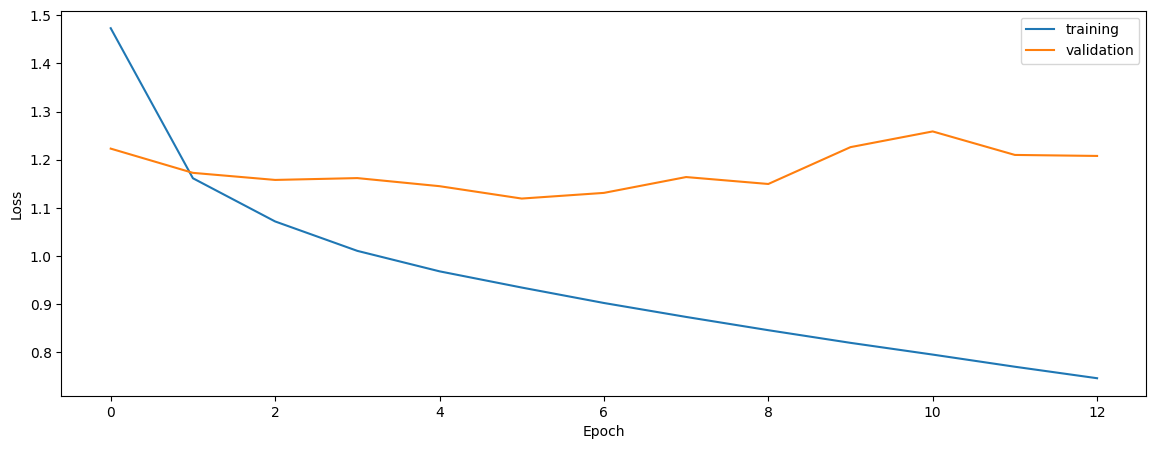

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6461761745774613
0.5659963303068415
0.5657579764100066


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5979466119096509
0.5802899096385542
0.5304087954277736


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5967804449497429
0.5707998679722742
0.5321205230244457


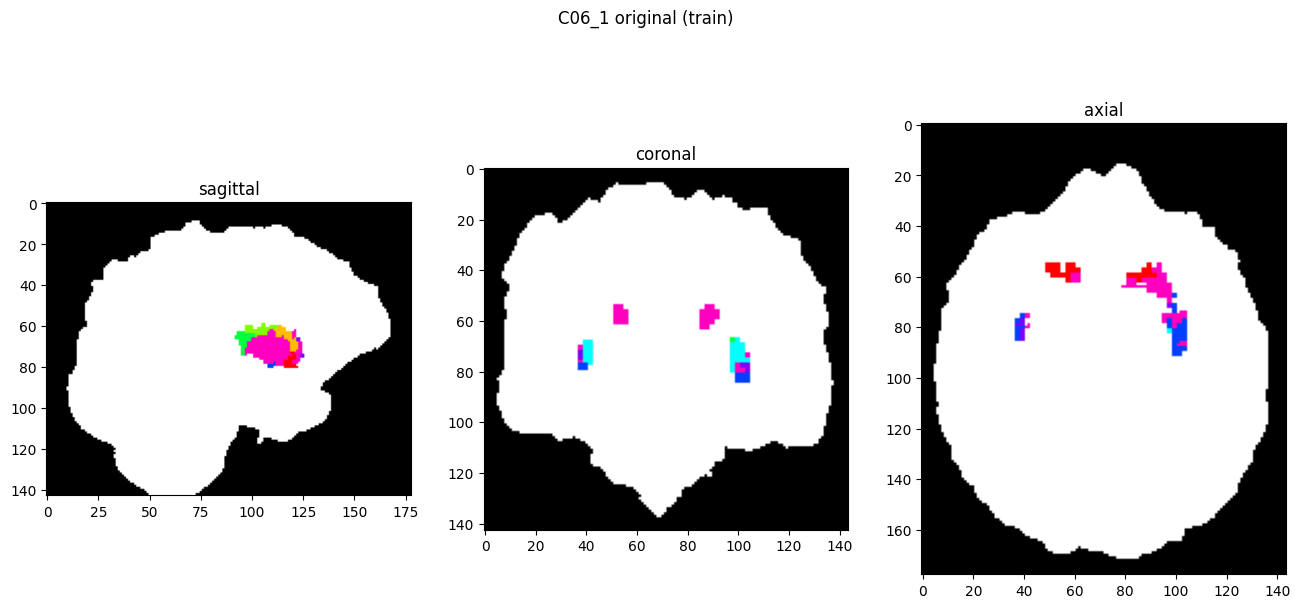

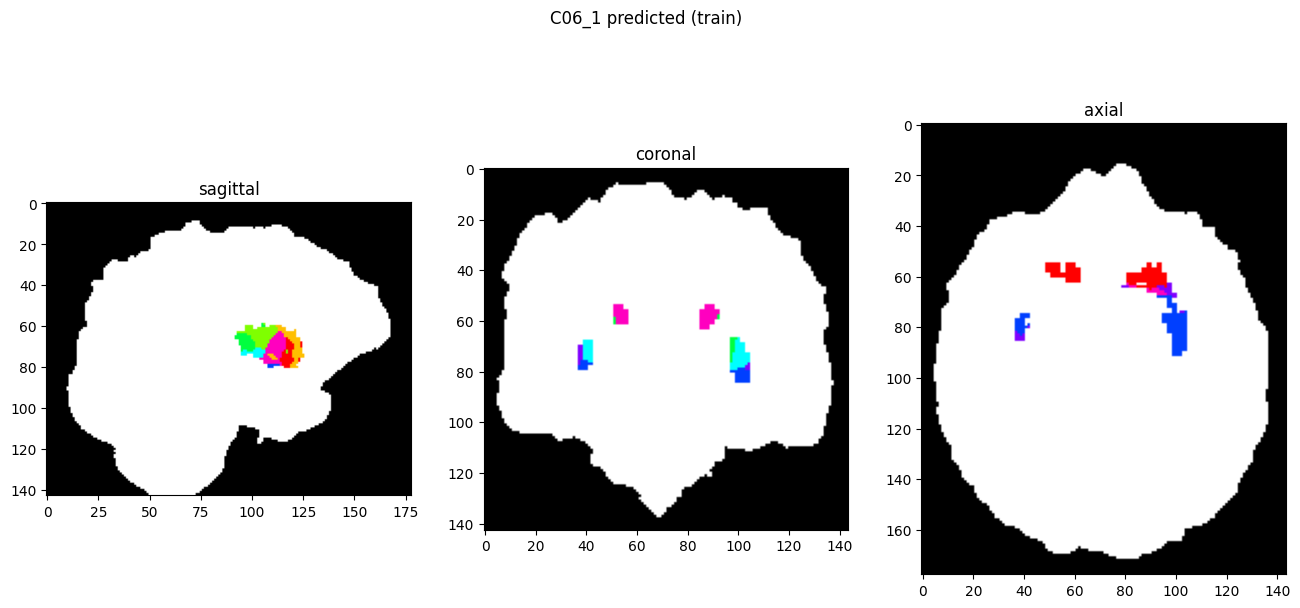

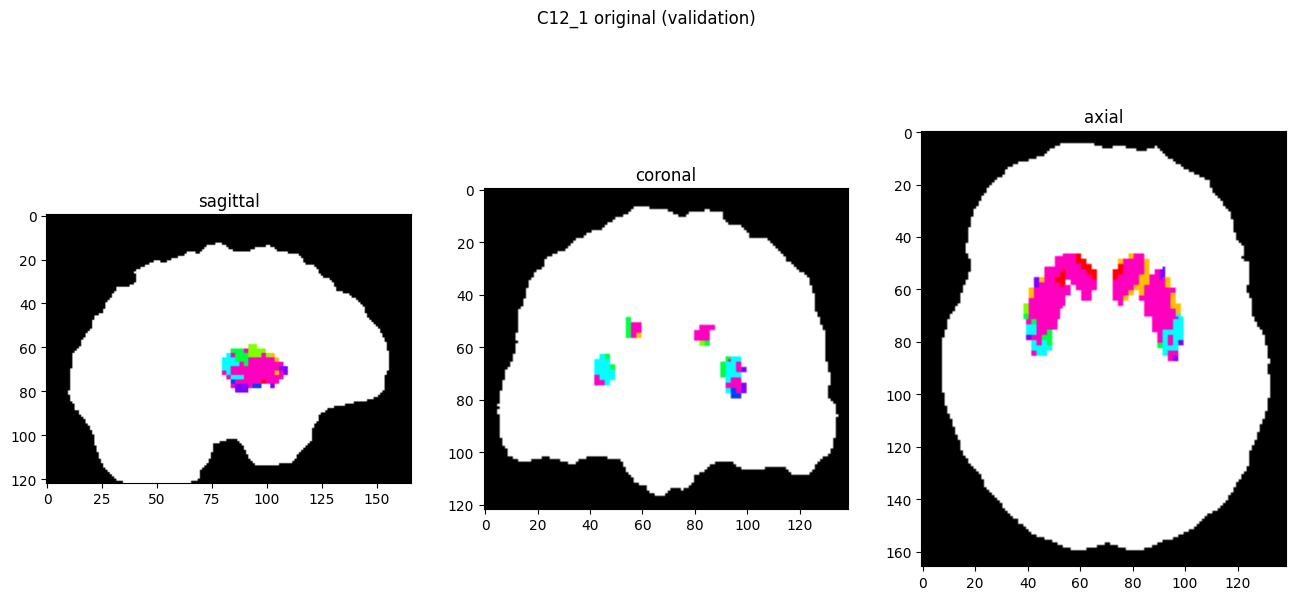

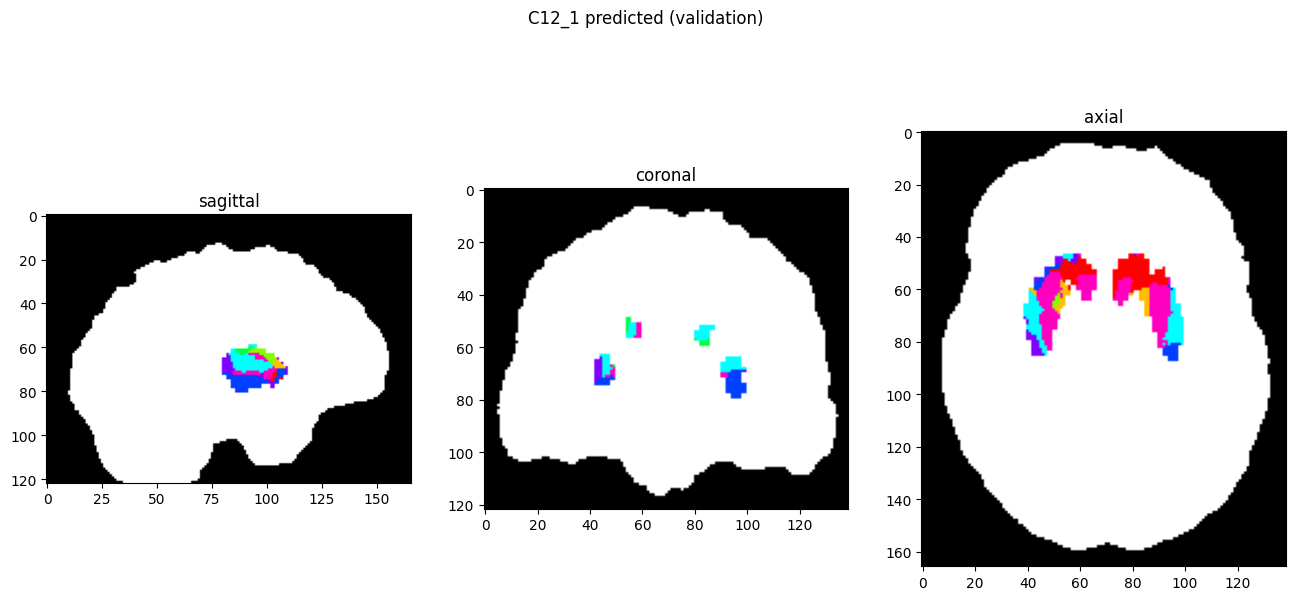

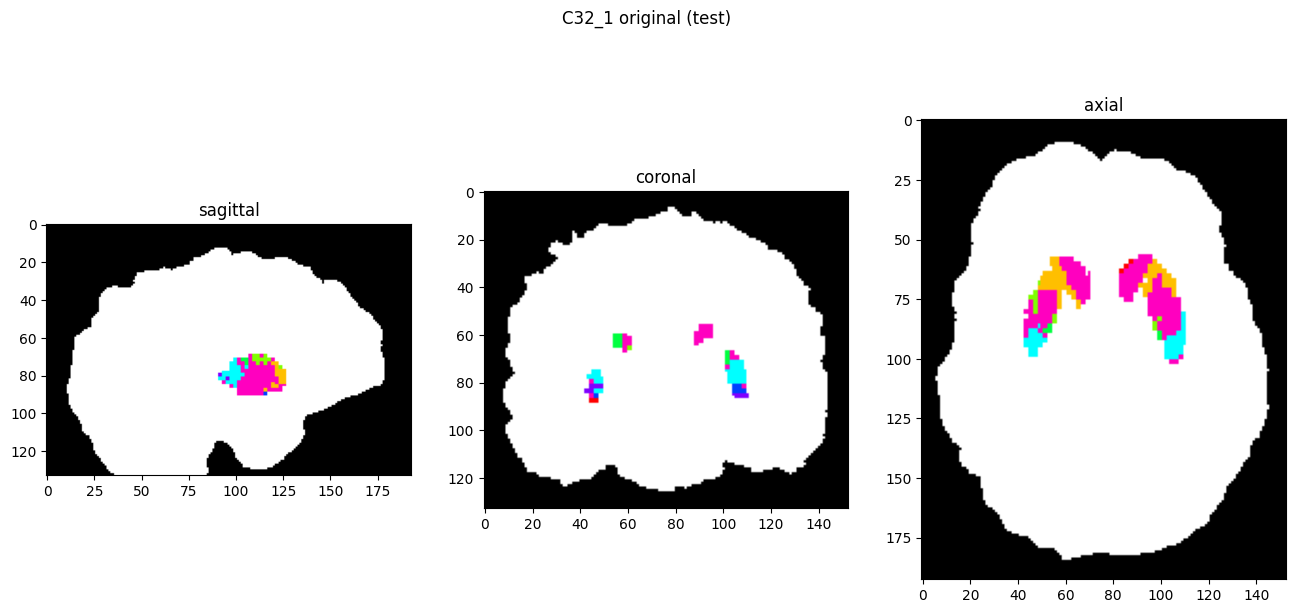

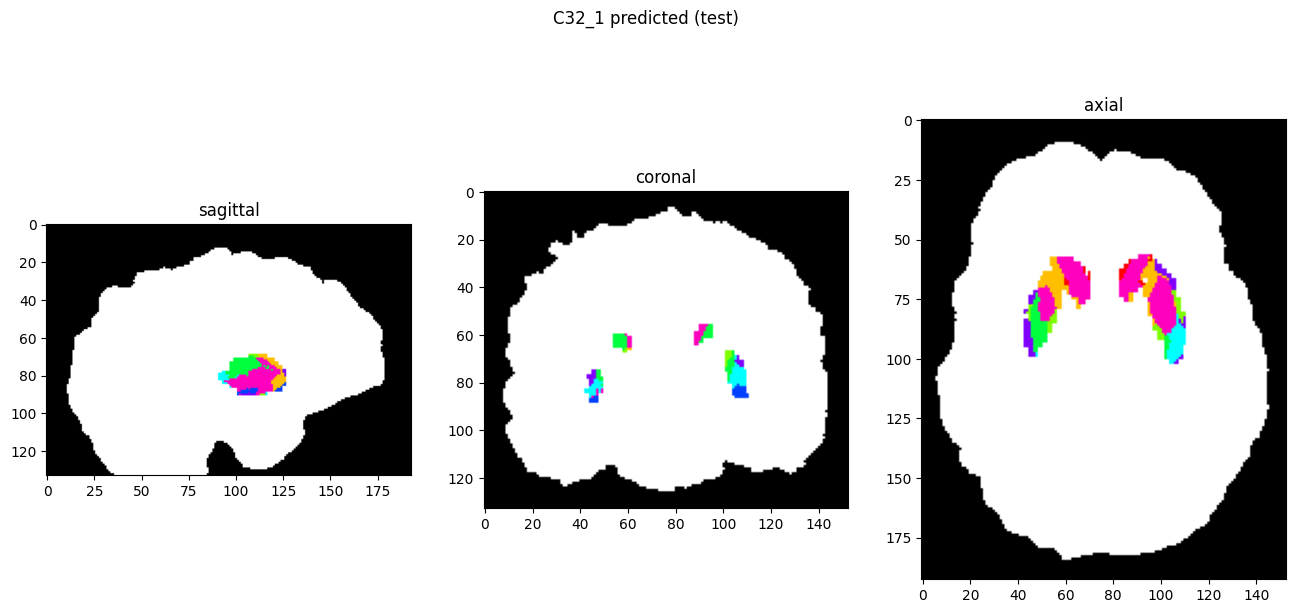

In [10]:
showResults(model, gen, threshold=0)